<a href="https://colab.research.google.com/github/ziiunlai/VaccineAcceptanceDeprivation/blob/main/Deprivation_and_Covid19_Vaccine_Acceptance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Why Aren't The Poor Getting Vaccinated Against COVID?

By: Zi Iun Lai and Jun Yang Ang


In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-project-sandbox"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
# import python libraries
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
import seaborn as sns

## 1 Project Overview

---

This project explores the central question of how socioeconomic status affects COVID-19 vaccination rates. For our project, we focus on US county level data, using the Area Deprivation Index (ADI) statistic as a proxy for how poor a region is, alongside other datasets for data on COVD-19 vaccination rates, vaccine hesitancy, vaccine access, among others.

We first attempt to understand how county-level COVID-19 vaccination rates correlate with the poverty level in each county. Then, in order to understand the causal effect of socioeconomic status on COVID-19 vaccination, we explore the following supplemental questions:
1. Do poorer counties have more limited access to COVID-19 vaccination?
2. Do poorer counties have higher COVID-19 vaccine hesitancy?
3. Are there county-level COVID vaccine policy differences between rich and poor counties?

First, a quick primer or refresher about COVID-19 vaccination. There are multiple different brands of COVID-19 vaccines, many of which have different instructions on how these vaccines should be administered. We say that the "primary series" of any COVID-19 vaccine is the manufacturer-recommended number of vaccine doses that an uninoculated individual should receive in order to be considered fully inoculated against COVID-19. For instance, the popular Pfizer-BioNTech and Moderna vaccines have two separate doses (separated by a distinct period of time) in their primary series. We also say that the "booster shot" of any COVID-19 vaccine is any vaccine dose taken beyond the requisute number in the primary series. For instance, taking a third, fourth, or fifth dose of the Pfizer-BioNTech vaccine counts as taking a booster dose.

Next, a quick but important note: there are two main ways of labelling geographical areas in the US. **ZIP Codes**, which we should all be familiar with, were developed by the US Postal Service, and are 5-digit numbers used to uniquely identify different mail delivery areas. On the other hand, the lesser known **Federal Information Processing Standard (FIPS) codes** are 5 or 6-digit numbers (depending on whether a leading ``0`` is included or omitted) used to uniquely identify different counties.

It is important to note that a FIPS code (county) often encompasses multiple ZIP Codes (mail delivery areas). For instance, the FIPS code for Santa Clara county is 06085. However, there are many distinct ZIP codes within Santa Clara County: 94202, 94023, 94204, 94035, 94039, 94040, 94041, 94042, 94043, 94085, 94086, 94087, 94088, 94089, 94090, 94301, 94302, 94303, 94304, 94305 (us!), 94306, 94309, 94310, ... (This isn't even an exhaustive list!) From here on, we say that ***a FIPS code represents a county***, and ***a ZIP Code represents a subcounty***.

---


## 2 Analysis of Datasets

----
### 2.1 Broadstreet ADI dataset
----

Area Deprivation Index (ADI) is a measure of the level of poverty in an area.  ADI ranges from 0-100; higher scores indicate higher deprivation (poverty). Scores are calculated using 17 indicators from the American Community Survey; these indicators include income, education, unemployment rate and category, regional income disparity, home valuation and ownership rate, rate of single parenthood, and rate of ownership of different facilities (vehicles, telephones, plumbing).

This dataset is quite small (~5MB), and contains three tables that list the ADI by different geographical clusters. The tables of interest are
1. ``area_deprivation_index_by_county``, which has keys ``state_fips_code`` (the first three digits of the FIPS code), ``county_fips_code`` (the last three digits of the FIPS code), ``county_name``, ``state_name`` (the full name), ``state`` (the two-letter abbreviation), ``year``, and ``area_deprivation_index_percent``.
2. ``area_deprivation_index_by_zipcode``, which has keys ``zipcode``, ``year`` and ``area_deprivation_index_percent`` as columns.

Surveyed years are 2018 to 2020. There are some rows with unrecorded ADI scores (appears as ``NaN``) --- we will later filter those rows out and get the most recent non-NaN score, and create two tables: one listing the ADI for each ZIP Code, and another listing the ADI for each FIPS county cide. There are 32989 unique ZIP Codes and 3142 unique FIPS codes, which correspond to the number of rows for both tables.

Data source: https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=broadstreet_adi&page=dataset (available through BigQuery as ``bigquery-public-data.broadstreet_adi``)

First, let's confirm that the dataset actually contains information from 2018 through 2020.

In [ ]:
%%bigquery --project $project_id

SELECT
   distinct year
FROM
  `bigquery-public-data.broadstreet_adi.area_deprivation_index_by_zipcode`

Query is running:   0%|          |

Downloading:   0%|          |

,year
0,2018
1,2019
2,2020


Then, we can try to see the number of unique ZIP Codes there are in the dataset.

In [ ]:
%%bigquery --project $project_id

SELECT
  count(distinct zipcode) as num_zipcodes
FROM
  `bigquery-public-data.broadstreet_adi.area_deprivation_index_by_zipcode`

Query is running:   0%|          |

Downloading:   0%|          |

,num_zipcodes
0,32989


Now, we make a simple modification to our dataset: we cast the ``area_deprivation_index_percent`` values in the tables, which were initially stored as floating point numbers, to be integers.

In [ ]:
%%bigquery --project $project_id

SELECT
   *
FROM
  `bigquery-public-data.broadstreet_adi.area_deprivation_index_by_zipcode`
where
  (cast(area_deprivation_index_percent as int64) != area_deprivation_index_percent
  or area_deprivation_index_percent < 0
  or area_deprivation_index_percent > 100)
  or safe_cast(area_deprivation_index_percent as int64) is null

Query is running:   0%|          |

Downloading:   0%|          |

,geo_id,zipcode,description,year,area_deprivation_index_percent
0,86000US01199,01199,ZCTA5 01199,2018,NaN
1,86000US01199,01199,ZCTA5 01199,2019,NaN
2,86000US01199,01199,ZCTA5 01199,2020,NaN
3,86000US02203,02203,ZCTA5 02203,2018,NaN
4,86000US02643,02643,ZCTA5 02643,2019,NaN
...,...,...,...,...,...
966,86000US99704,99704,ZCTA5 99704,2020,NaN
967,86000US99732,99732,ZCTA5 99732,2018,NaN
968,86000US99903,99903,ZCTA5 99903,2020,NaN
969,86000US99923,99923,ZCTA5 99923,2018,NaN


From above, we see the raw dataset contains 32989 different ZIP Codes. We see each ZIP Code has scores for different years (2018 - 2020). Also, it looks like we don't have any area_deprivation_index_percent values which aren't integers between 0-100 inclusive. But, for 971 rows, we have area_deprivation_index_percent of ``NaN`` values. Let's remove the ``NaN`` value rows, and get the zipcode and ADI score for the most recent year where value is non-``NaN``.

In [ ]:
%%bigquery --project $project_id
with mostRecentADI as (
  select
  zipcode, year, area_deprivation_index_percent, row_number() over (PARTITION BY zipcode ORDER BY year DESC) AS rowNum
  from
  `bigquery-public-data.broadstreet_adi.area_deprivation_index_by_zipcode`
  where area_deprivation_index_percent is not NULL
)
SELECT
  zipcode, year, area_deprivation_index_percent
FROM
  mostRecentADI
  where rowNum = 1

Query is running:   0%|          |

Downloading:   0%|          |

,zipcode,year,area_deprivation_index_percent
0,94024,2020,0.0
1,02067,2020,2.0
2,06830,2020,2.0
3,11023,2020,2.0
4,33076,2020,2.0
...,...,...,...
32723,38643,2020,99.0
32724,48502,2020,99.0
32725,74946,2020,99.0
32726,78580,2020,99.0


In [ ]:
%%bigquery --project $project_id
with mostRecentADI as (
  select
  zipcode, year, area_deprivation_index_percent, row_number() over (PARTITION BY zipcode ORDER BY year DESC) AS rowNum
  from
  `bigquery-public-data.broadstreet_adi.area_deprivation_index_by_zipcode`
  where area_deprivation_index_percent is not NULL
)
SELECT
  distinct year
FROM
  mostRecentADI
  where rowNum = 1

Query is running:   0%|          |

Downloading:   0%|          |

,year
0,2020
1,2019
2,2018


After removing ``NaN`` rows, we have 32728 unique ZIP Codes. The original dataset had 32989 unique ZIP Codes, meaning 261 ZIP Codes were in the table without scores in all three years. 2018, 2019 and 2020 were found in the filtered table, suggesting some ZIP Codes had scores on one of the years. Let's see which year had the most ``NaN`` values.

In [ ]:
%%bigquery --project $project_id
with nanRows as (
SELECT
   *
FROM
  `bigquery-public-data.broadstreet_adi.area_deprivation_index_by_zipcode`
where
  (cast(area_deprivation_index_percent as int64) != area_deprivation_index_percent
  or area_deprivation_index_percent < 0
  or area_deprivation_index_percent > 100)
  or safe_cast(area_deprivation_index_percent as int64) is null)
select year, count(*) as num_Nans
from nanRows
group by year

Query is running:   0%|          |

Downloading:   0%|          |

,year,num_Nans
0,2018,325
1,2019,321
2,2020,325


I was expecting a larger number of NaN rows to occur in 2020, because the COVID-19 pandemic might have hindered researchers' direct access to communities for data collectio , but it seems like that wasn't the case. All three years had roughly equal numbers of zipcodes with NaN results.

Anyway, let's store the filtered zipcodes, years and ADI scores into a new table, ``proj2_exploration.zipcode_adi``.

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `proj2_exploration.zipcode_adi`
AS
with mostRecentADI as (
  select
  zipcode, year, area_deprivation_index_percent, row_number() over (PARTITION BY zipcode ORDER BY year DESC) AS rowNum
  from
  `bigquery-public-data.broadstreet_adi.area_deprivation_index_by_zipcode`
  where area_deprivation_index_percent is not NULL
)
SELECT
  zipcode, year, area_deprivation_index_percent
FROM
  mostRecentADI
  where rowNum = 1

Query is running:   0%|          |

""


In BigQuery, we created a similar table ``proj2_exploration.fipscode_adi`` for non-``NaN`` FIPS code data (code is similar to above, omitted here for brevity).

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  `cs145-project-sandbox.proj2_exploration.fipscode_adi`
LIMIT
  5

----
### 2.2 COVID-19 Vaccination Rates by County
----

This dataset is from CDC's Open Data Network. The original dataset is massive, with 1.9 million rows. That's because it records the data every week for every county. In this project, we are only interested in the final available record on 2023-05-10.

We first create a table in our project with 5000 rows (an overestimate for number of rows on the last date) consisting of percentage of county population who received different doses of COVID-19 vaccines via json. We don't know how many rows are from the last date, but it's probably less than 5000. We identify the unique date values, and keep rows where date = last_date. Some rows have the FIPS code as ``UNK`` (unknown) or ``NULL`` percent values; let's remove those too.

The final table has 4777 rows, with size about 1MB. The keys are
1. ``recip_county`` (county name);
2. ``fips`` (FIPS code);
3. ``administered_dose1_pop_pct`` (the percentage of the county population who has received at least one dose of the vaccine);
4. ``series_complete_pop_pct`` (the percentage of the county population who has received at least the full primary series of the vaccine); and
5. ``booster_doses_vax_pct`` (the percentage of the county population who has received at least the full primary series of the vaccine and one booster dose)

Data source: https://www.opendatanetwork.com/dataset/data.cdc.gov/8xkx-amqh

In [ ]:
import requests
import json

# URL of the JSON data
url = 'https://data.cdc.gov/resource/8xkx-amqh.json?$limit=5000'

# Fetch the data from the URL
response = requests.get(url)

json_data = response.json()
df = pd.DataFrame(json_data)
df.to_gbq(destination_table=f'proj2_exploration.us_county_vaccinations_test', project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 8176.03it/s]


In [ ]:
df.shape

(5000, 80)

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE
  `proj2_exploration.us_county_vaccinations_test` AS
SELECT
  recip_county,
  fips,
  administered_dose1_pop_pct,
  series_complete_pop_pct,
  booster_doses_vax_pct
FROM
  `cs145-project-sandbox.proj2_exploration.us_county_vaccinations_test`
WHERE
  date = '2023-05-10T00:00:00.000'
  AND fips IS NOT NULL
  AND administered_dose1_pop_pct IS NOT NULL
  AND series_complete_pop_pct IS NOT NULL
  AND booster_doses_vax_pct IS NOT NULL
  AND fips != 'UNK';

Query is running:   0%|          |

""


time: 2.82 s (started: 2023-11-29 01:28:28 +00:00)


----
### 2.3 COVID-19 Vaccination Search Insights
----

This dataset is compiled by a team at Google and tracks the proportion of Google searches related to COVID-19 vaccination. This data is broken down by ZIP code, and compiled on a weekly basis.

This dataset has one table and is 213 MB in size. The keys are
1. ``date``;
2. ``country_region`` (full name of the country) and ``country_region_code`` (abbreviation);
3. ``sub_region1`` (full name of the state) and ``sub_region1_code`` (abbreviation);
4. ``sub_region2`` (full name of the county) and ``sub_region2_code`` (FIPS code or equivalent for other countries);
5. ``sub_region3`` (full name of the subcounty) and ``sub_region3_code`` (ZIP Code or postcode for other countries);
6. ``place_id`` (the Google place ID for the most specific subregion);
7. ``sni_covid19_vaccination`` (the scaled normalized interest related to all COVID-19 vaccination for the region and date);
8. ``sni_vaccination_intent`` (the scaled normalized interest related to vaccination intent for the region and date); and
9. ``sni_safety_side_effects`` (the scaled normalized interest related to safety and side effects of the vaccines for the region and date)

We're interested in  ``sni_covid19_vaccination``, ``sni_vaccination_intent``, ``sni_safety_side_effects``, which are scaled metrics for search interests for general vaccine information, intention to receive vaccinations and concerns over vaccine safety for each county, at every week.

One issue with this table is the number of missing data for the three search interest metrics. From the original 1803069 rows, there are only 921622 rows (or around half) where three metrics are not ``NULL``.

Quick explorations show data starts the week of 2021-01-04 to 2023-10-30, with 148 unique dates. There are 12099 unique ZIP Codes in the data. Later, we'll take the average search scores across all weeks for each county, to estimate average search insights over almost three years.

Data source: https://console.cloud.google.com/marketplace/product/bigquery-public-datasets/covid19-vaccination-search-insights (available through BigQuery as ``bigquery-public-data.covid19_vaccination_search_insights``)

More reading: https://storage.googleapis.com/gcs-public-datasets/COVID-19%20Vaccination%20Search%20Insights%20documentation.pdf

----
### 2.4 COVID-19 Hesitancy Poll by County
----

This dataset, developed by the Delphi Group at Carnegie Mellon University and Facebook, estimates COVID-19 vaccine hesitancy in different US subcounties through polls conducted in early 2021, before vaccines were widely available in all US states. The dataset lists the approximate percentage of county population who are vaccine hesitant.

This dataset has one table and is 13.52 MB in size. The keys are
1. ``week``, ``start_date`` (of the week), and ``end_date`` (of the week)
2. ``zip_code``, ``county_name``, and ``state_name``
3. ``final_zip_pred`` (the proportion of county population that is vaccine hesitant).

Quick exploration shows 1877 unique counties in dataset. We keep data obtaned in the last week. There are 88348 rows (each county has several rows corresponding to different ZIP Codes)

Polling survey example: https://www.healthdata.org/news-events/insights-blog/acting-data/estimating-covid-19-vaccine-hesitancy

Data source: https://www.healthdata.org/news-events/insights-blog/acting-data/covid-19-vaccine-hesitancy-us-county-and-zip-code

----
### 2.5 County Level COVID-19 Assistance Policies
----

This dataset, from US COVID County Policies Database, measures the level of COVID-19 assistance policies in different counties in the US. The analysis was conducted during Jan-March 2021, in 171 counties in California, Louisiana, Mississippi, New Jersey, New York, Texas, and Utah. While these listed counties are not completely representative of US as a whole, they cover >25% of US population and represent diverse ethnic/political groups.

Quick explorations show data is clean, with no missing data (171 rows). There are many (around 100) keys, so we won't list them all out here, but we're interested in relief/informative efforts by counties, which are in the ``housing_support_c``, ``utility_support_c``, and ``public_info_campaigns_c`` columns. Utility and housing support efforts were categorized as ``0`` or ``1`` for absence and presence of assistance, or ``9`` for unknown. COVID education efforts were categorized as ``0``, ``1``, ``2``, or ``9`` for no information, some information, comprehensive information or unknown respectively. Table size is small (~1MB).

This dataset is very small, but we'll find some interesting trends. Of course, more data is required if our claims are to be re-examined in the future.

Data source: https://bmcpublichealth.biomedcentral.com/articles/10.1186/s12889-022-14132-6

----
### 2.6. Negative Sentiments regarding COVID-19 on Twitter
----

This dataset comes from Hohl et al. (2023), a study which examined the extentr of negative sentiments (anger, disgust, fear, sadness) towards COVID-19 through public tweets on Twitter (currently known as X, for some reason). Scores are normalized by the total number of tweets. The tweet sentiment analysis includes data from 1801 unique counties, 3108 unique FIPS codes, and covers a time period from 2019-11-01 till 2020-09-15. There are approx ~500 entries per county - we'll take the average sentiment for each county across time.

This dataset contains one table with 994,560 rows, for a total size of 145MB. The keys are
1. ``FIPS``, ``County``, and ``Date``;
2. ``anger``, ``anticipation``, ``disgust``, ``fear``, ``joy``, ``sadness``, ``surprise``, ``trust`` (the relative levels of various emotions)
3. ``positive`` (the relative levels of ``anticipation``, ``joy``, ``surprise``, or ``trust``)
4. ``negative`` (the relative levels of ``anger``, ``disgust``, ``fear``, or ``sadness``)

Full Methodology: https://www.researchgate.net/publication/373350709_COVID-19_adverse_population_sentiment_and_place-based_associations_with_socioeconomic_and_demographic_factors

Data source: https://github.com/alexandster/covid19sentiment/blob/main/README.md



----
### 2.7 COVID-19 Vaccination Access dataset
----

This dataset contains detailed locations of vaccination facilities in each county, and the estimated travel duration to the vaccination facility within the community it was intended to serve, as of Nov 2021.

This dataset contains four tables, each of which tracks the estimated time it takes to travel to the vaccination center through a specific mode of transport. Specifically, one table uses ``drive`` transportation, another uses ``transit`` (i.e. public transit), another uses ``walk``, and the last table combines the data from all three prior tables into one.

The table of primary interest is ``facility_boundary_us_drive`` (765.29 MB in size with 580,650 rows), with the following keys
1. ``facility_place_id`` (the Google Place ID of the vaccination site), ``facility_provider_id`` (the VaccineFinder ID of the provider),  ``facility_name``;
2. ``facility_latitude``, ``facility_longitude``;
3. ``facility_country_region`` (full name of country), ``facility_country_region_code`` (abbreviation);
4. ``facility_sub_region_1`` (full name of state), ``facility_sub_region_1_code`` (abbreviation);
5. ``facility_sub_region_2`` (full name of county), ``facility_sub_region_2_code`` (FIPS code or equivalent for other countries);
6. ``mode_of_transportation`` and ``travel_time_threshold_minutes``; and
7. ``facility_catchment_boundary`` (GeoJSON representation of the catchment area boundary of the vaccination site).

However, the data seems slightly contrived here. For instance, the ``travel_time_threshold_minute`` is bucketed into discrete categories of ``15``, ``30``, and ``45``. The lack of fine-grained continuous data makes this dataset less useful for our later ML model, particularly as there are so few categories that no clear trends can be drawn between ADI and travel time to a vaccination center.

Data source: https://console.cloud.google.com/marketplace/product/bigquery-public-datasets/covid19-vaccination-access (available through BigQuery as ``bigquery-public-data.covid19_vaccination_access``)

----
### 2.8 COVID-19 Symptom Search
----

This dataset is a large collection of normalized searches for different health symptoms across multiple countries.

The dataset contains 6 tables, each of which corresponds to a different way of breaking down the search trends by geographic region (``country``-level, ``sub_region_1`` or state-level, and ``sub_region_2`` or county-level) and by time (``daily`` and ``weekly``).

We'll use the ``symptom_search_sub_region_2_weekly`` table (breaking down search trends by county-level on a weekly basis), which contains 1,202,166 rows, and has size 2.55 GB. The keys are:
1. ``country_region`` (full name of the country) and ``country_region_code`` (abbreviation);
2. ``sub_region1`` (full name of the state) and ``sub_region1_code`` (abbreviation);
3. ``sub_region2`` (full name of the county) and ``sub_region2_code`` (FIPS code or equivalent for other countries);
4. ``sub_region3`` (full name of the subcounty) and ``sub_region3_code`` (ZIP Code or postcode for other countries);
5. ``place_id`` (the Google place ID for the most specific subregion);
6. ``date``; and
7. over 100 keys, each of which tracks the relative number of searches for a specific symptom (e.g. ``symptom_Dizziness`` tracks the relative number of searches for dizziness).

Rather than repeatedly querying this large table, we'll create a new table for US queries only, with columns for search trends for a smaller subset of symptoms that are more directly related to COVID-19 and mental health conditions (depression, guilt, panic attack and insomnia). Our smaller table is 199.39 MB.

Data source: https://console.cloud.google.com/marketplace/product/bigquery-public-datasets/covid19-search-trends (available through BigQuery as ``bigquery-public-data.covid19_symptom_search``)

----
### 2.9 Summary of Dataset Analysis
----
To summarize, we intend to use seven main datasets:
1. Area Deprivation Index by county and subcounty
2. COVID-19 vaccination rates
3. COVID-19 vaccination search trends on Google
4. COVID-19 vaccination hesitancy (polled)
5. COVID-19 assistance policies by county
6. Negative sentiments on COVID-19 from Twitter
7. COVID-19 vaccine center accessibility
8. COVID-19 symptom search trends on Google

All of the datasets we intend to use include geographical data for relevant COVID-related statistics. Notably, however, many datasets don't contain data on the subcounty (ZIP Code) level, and only contains data on the county (FIPS code) level. Given this, we intend to use FIPS code as the foreign key with which to link all of the datasets together in our subsequent exploration.

## 3 Exploration & Visualizations

### 3.1 County Deprivation and Vaccination Rates

First, we conduct some simple visualizations to investigate whether and what sort of a trend exists between county deprivation and COVID-19 vaccination rate.

We run a SQL query to obtain a table containing COVID-19 vaccination rates. The query below generates a table containing the percentage of population who received first vaccine dose, completed both primary doses, and attained booster shots for each FIPS code. We've removed ``NULL`` / ``NaN`` rows and rows where the FIPS code is unknown.

In [ ]:
%%bigquery --project $project_id

SELECT
  fips,
  administered_dose1_pop_pct,
  series_complete_pop_pct,
  booster_doses_vax_pct
FROM
  `cs145-project-sandbox.proj2_exploration.us_county_vaccinations_test`
WHERE
  fips IS NOT NULL
  AND administered_dose1_pop_pct IS NOT NULL
  AND series_complete_pop_pct IS NOT NULL
  AND booster_doses_vax_pct IS NOT NULL
  AND fips != 'UNK';

Query is running:   0%|          |

Downloading:   0%|          |

,fips,administered_dose1_pop_pct,series_complete_pop_pct,booster_doses_vax_pct
0,51690,45.5,39.2,1
1,51580,41.1,34,1
2,51830,45.4,40,6
3,51175,45.7,37.6,13
4,51037,44.2,38.8,17
...,...,...,...,...
3132,38097,64.5,56.5,53.6
3133,46091,64.5,55.4,58.3
3134,39043,64.5,60.9,59.2
3135,27149,64.5,60.5,59.4


Now, let's merge the vaccination rate table with our county ADI table, and see if ADI has correlation with vaccination rates.

In [ ]:
query = """
WITH
  t AS (
  SELECT
    fips,
    administered_dose1_pop_pct,
    series_complete_pop_pct,
    booster_doses_vax_pct
  FROM
    `cs145-project-sandbox.proj2_exploration.us_county_vaccinations_test`
  WHERE
    fips IS NOT NULL
    AND administered_dose1_pop_pct IS NOT NULL
    AND series_complete_pop_pct IS NOT NULL
    AND booster_doses_vax_pct IS NOT NULL
    AND fips != 'UNK')
SELECT
  fips,
  administered_dose1_pop_pct,
  series_complete_pop_pct,
  booster_doses_vax_pct,
  area_deprivation_index_percent
FROM
  t
JOIN
  `cs145-project-sandbox.proj2_exploration.fipscode_adi` AS adi
ON
  t.fips = adi.county_fips_code
"""

df = pd.io.gbq.read_gbq(query, project_id=project_id)

Now, we convert the merged table into a Pandas DataFrame object, and try to visualize the data using some simple plotting.

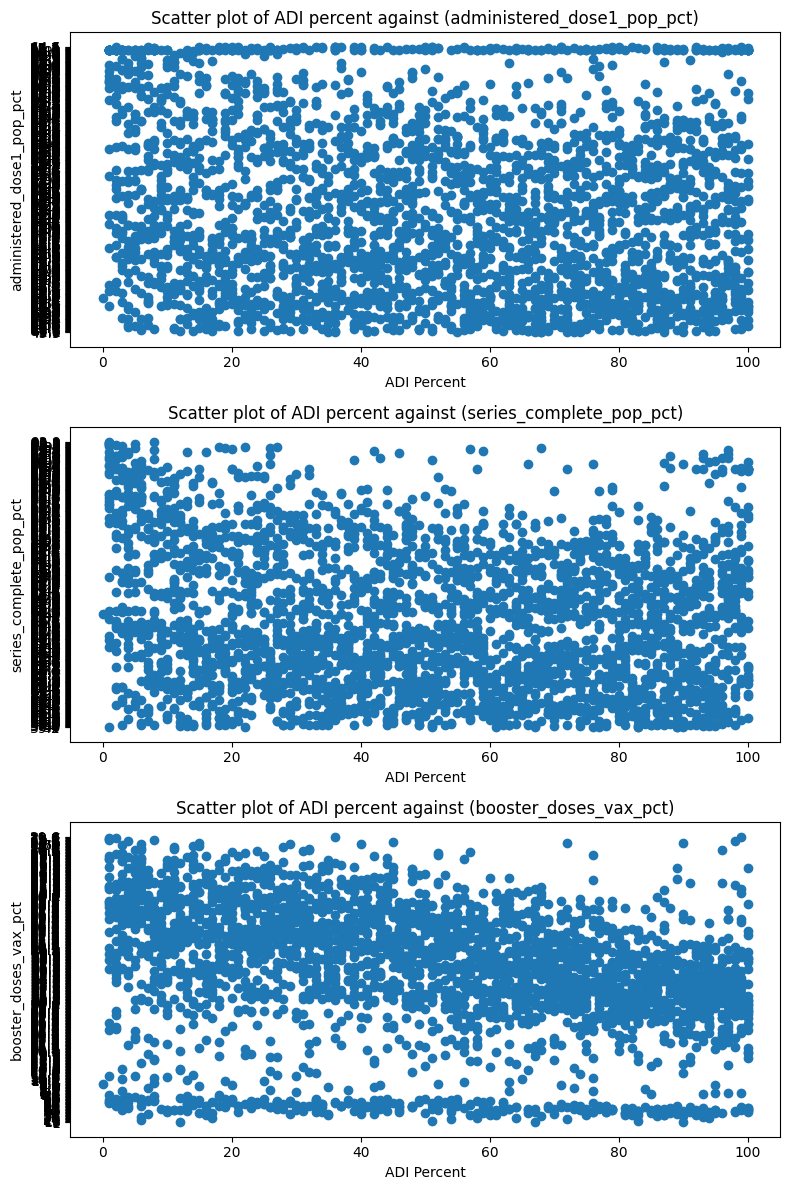

In [ ]:
rates = ['administered_dose1_pop_pct',	'series_complete_pop_pct',	'booster_doses_vax_pct']

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

for i, rate in enumerate(rates):
    # Scatter plot
    axs[i].scatter(df['area_deprivation_index_percent'], df[rate], label='Data')

    # X = df['area_deprivation_index_percent'].values.reshape(-1, 1)
    # y = df[rate].values
    # model = LinearRegression().fit(X, y)
    # y_pred = model.predict(X)

    # axs[i].plot(df['area_deprivation_index_percent'], y_pred, color='red', linewidth=2, label='Best fit line')

    axs[i].set_xlabel('ADI Percent')
    axs[i].set_ylabel(rate)
    axs[i].set_title(f'Scatter plot of ADI percent against ({rate})')
    # axs[i].legend()

plt.tight_layout()
plt.show()

The above three plots indicate the ADI and vaccination rates of every county. It's pretty messy, and it's difficult to visually extract a trend from whatever is going on in this plot. Let's simplify it by taking the average vaccination rates of every county rounded by ADI score. For instance, suppose our dataset consists of only the following two datapoints:

``county_A | 40% vaccinated | ADI score of 19``

``county_B | 60% vaccinated | ADI score of 19``

then, we say that the **average vaccination rate** of counties with ADI score of 19 is 50%. We do this for every ADI score. In other words, we bucket every county according to ADI score (integers from 0 to 100) and plot the average vaccination rates.

In [ ]:
query = """
with h as (WITH
  t AS (
  SELECT
    fips,
    administered_dose1_pop_pct,
    series_complete_pop_pct,
    booster_doses_vax_pct
  FROM
    `cs145-project-sandbox.proj2_exploration.us_county_vaccinations_test`
  WHERE
    fips IS NOT NULL
    AND administered_dose1_pop_pct IS NOT NULL
    AND series_complete_pop_pct IS NOT NULL
    AND booster_doses_vax_pct IS NOT NULL
    AND fips != 'UNK')
SELECT
  fips,
  administered_dose1_pop_pct,
  series_complete_pop_pct,
  booster_doses_vax_pct,
  area_deprivation_index_percent
FROM
  t
JOIN
  `cs145-project-sandbox.proj2_exploration.fipscode_adi` AS adi
ON
  t.fips = adi.county_fips_code)
  SELECT
  area_deprivation_index_percent,
  AVG(CAST(administered_dose1_pop_pct AS FLOAT64)) AS avg_administered_dose1_pop_pct,
  AVG(CAST(series_complete_pop_pct AS FLOAT64)) AS avg_series_complete_pop_pct,
  AVG(CAST(booster_doses_vax_pct AS FLOAT64)) AS avg_booster_doses_vax_pct
FROM
  h
GROUP BY
  area_deprivation_index_percent
 having area_deprivation_index_percent > 0
"""

df = pd.io.gbq.read_gbq(query, project_id=project_id)

In [ ]:
df.head()

,area_deprivation_index_percent,avg_administered_dose1_pop_pct,avg_series_complete_pop_pct,avg_booster_doses_vax_pct
0,90.0,57.270968,49.612903,38.709677
1,67.0,56.238710,49.564516,45.700000
2,12.0,64.613793,56.941379,47.982759
3,51.0,58.863333,52.323333,45.953333
4,83.0,51.909375,44.543750,41.325000


Text(0.5, 0, 'ADI')

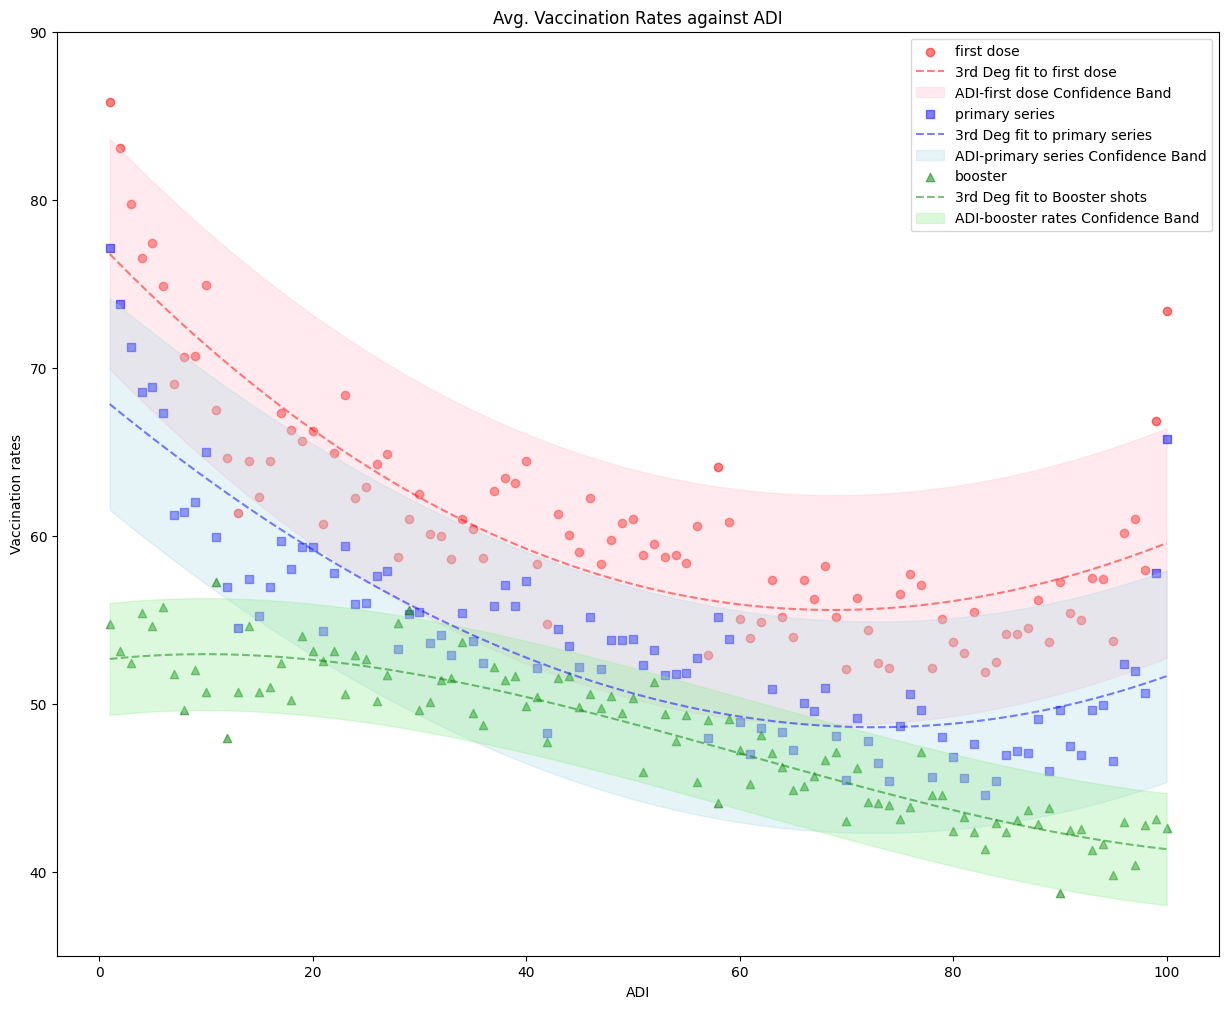

In [ ]:
degree = 3
plt.figure(figsize=(15, 12))

plt.scatter(df['area_deprivation_index_percent'], df['avg_administered_dose1_pop_pct'], color='red', alpha=0.5, label='first dose')
p = np.polyfit(df['area_deprivation_index_percent'], df['avg_administered_dose1_pop_pct'], degree)
p_func = np.poly1d(p)

# Generate x values for the line
x_values = np.linspace(df['area_deprivation_index_percent'].min(), df['area_deprivation_index_percent'].max(), 100)

# Calculate the y values using the polynomial function
y_values = p_func(x_values)

# Plot the polynomial lin
plt.plot(x_values, y_values, color='red', label='3rd Deg fit to first dose',  alpha = 0.5, linestyle = '--')

# Calculate confidence intervals
y_pred = np.polyval(p, df['area_deprivation_index_percent'])
residuals = df['avg_administered_dose1_pop_pct'] - y_pred
std_err = np.std(residuals)
conf = 1.96 * std_err  # 95% confidence interval

# Plot confidence band
plt.fill_between(x_values, y_values - conf, y_values + conf, color='pink', alpha=0.3, label='ADI-first dose Confidence Band')

# --------------------------------------

plt.scatter(df['area_deprivation_index_percent'], df['avg_series_complete_pop_pct'], color='blue', marker = 's', alpha=0.5, label = 'primary series')
p = np.polyfit(df['area_deprivation_index_percent'], df['avg_series_complete_pop_pct'], degree)
p_func = np.poly1d(p)

# Generate x values for the line
x_values = np.linspace(df['area_deprivation_index_percent'].min(), df['area_deprivation_index_percent'].max(), 100)

# Calculate the y values using the polynomial function
y_values = p_func(x_values)

# Plot the polynomial lin
plt.plot(x_values, y_values, color='blue', label='3rd Deg fit to primary series',  alpha = 0.5, linestyle = '--')

# Calculate confidence intervals
y_pred = np.polyval(p, df['area_deprivation_index_percent'])
residuals = df['avg_series_complete_pop_pct'] - y_pred
std_err = np.std(residuals)
conf = 1.96 * std_err  # 95% confidence interval

# Plot confidence band
plt.fill_between(x_values, y_values - conf, y_values + conf, color='lightblue', alpha=0.3, label='ADI-primary series Confidence Band')
# --------------------------------------------------------------------------

degree = 3
plt.scatter(df['area_deprivation_index_percent'], df['avg_booster_doses_vax_pct'], color='green',marker = '^', alpha=0.5, label='booster')
p = np.polyfit(df['area_deprivation_index_percent'], df['avg_booster_doses_vax_pct'], degree)
p_func = np.poly1d(p)

# Generate x values for the line
x_values = np.linspace(df['area_deprivation_index_percent'].min(), df['area_deprivation_index_percent'].max(), 100)

# Calculate the y values using the polynomial function
y_values = p_func(x_values)

# Plot the polynomial lin
plt.plot(x_values, y_values, color='green', label='3rd Deg fit to Booster shots', alpha = 0.5, linestyle = '--')

# Calculate confidence intervals
y_pred = np.polyval(p, df['area_deprivation_index_percent'])
residuals = df['avg_booster_doses_vax_pct'] - y_pred
std_err = np.std(residuals)
conf = 1.96 * std_err  # 95% confidence interval

# Plot confidence band
plt.fill_between(x_values, y_values - conf, y_values + conf, color='lightgreen', alpha=0.3, label='ADI-booster rates Confidence Band')
# -------------------------------------
plt.title('Avg. Vaccination Rates against ADI')
plt.legend()
plt.ylim(35, 90)
plt.ylabel('Vaccination rates')
plt.xlabel('ADI')

In [ ]:
spearman_corr, p_value = spearmanr(df['area_deprivation_index_percent'], df['avg_administered_dose1_pop_pct'], alternative='less')
print("Spearman's correlation coefficient between area_deprivation_index_percent and avg_administered_dose1_pop_pct:", spearman_corr)
print("with p value : ", p_value)
print()
spearman_corr, p_value = spearmanr(df['area_deprivation_index_percent'], df['avg_series_complete_pop_pct'], alternative='less')
print("Spearman's correlation coefficient between area_deprivation_index_percent and avg_series_complete_pop_pct:", spearman_corr)
print("with p value : ", p_value)
print()
spearman_corr, p_value = spearmanr(df['area_deprivation_index_percent'], df['avg_booster_doses_vax_pct'], alternative='less')
print("Spearman's correlation coefficient between area_deprivation_index_percent and avg_booster_doses_vax_pct:", spearman_corr)
print("with p value : ", p_value)
print()

Spearman's correlation coefficient between area_deprivation_index_percent and avg_administered_dose1_pop_pct: -0.7486228622862285
with p value :  1.7165530834686188e-19

Spearman's correlation coefficient between area_deprivation_index_percent and avg_series_complete_pop_pct: -0.7959195919591958
with p value :  2.193631922198383e-23

Spearman's correlation coefficient between area_deprivation_index_percent and avg_booster_doses_vax_pct: -0.9091749174917491
with p value :  2.2811813536453166e-39



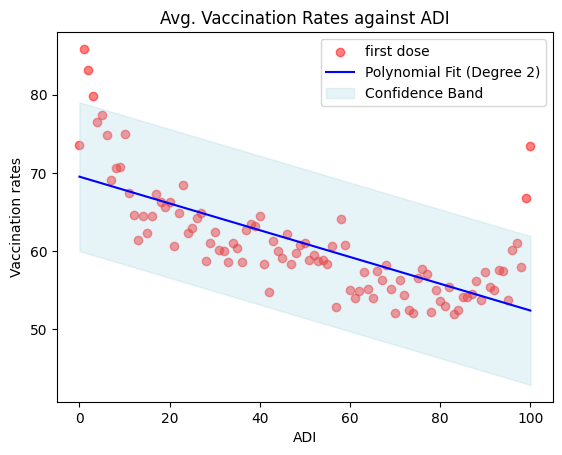

In [ ]:
plt.scatter(df['area_deprivation_index_percent'], df['avg_administered_dose1_pop_pct'], color='red', alpha=0.5, label='first dose')

# Fit a polynomial of degree 2 to your data
degree = 1
p = np.polyfit(df['area_deprivation_index_percent'], df['avg_administered_dose1_pop_pct'], degree)
p_func = np.poly1d(p)

# Generate x values for the line
x_values = np.linspace(df['area_deprivation_index_percent'].min(), df['area_deprivation_index_percent'].max(), 100)

# Calculate the y values using the polynomial function
y_values = p_func(x_values)

# Plot the polynomial lin
plt.plot(x_values, y_values, color='blue', label='Polynomial Fit (Degree 2)')

# Calculate confidence intervals
y_pred = np.polyval(p, df['area_deprivation_index_percent'])
residuals = df['avg_administered_dose1_pop_pct'] - y_pred
std_err = np.std(residuals)
conf = 1.96 * std_err  # 95% confidence interval

# Plot confidence band
plt.fill_between(x_values, y_values - conf, y_values + conf, color='lightblue', alpha=0.3, label='Confidence Band')

plt.title('Avg. Vaccination Rates against ADI')
plt.ylabel('Vaccination rates')
plt.xlabel('ADI')

plt.legend()
plt.show()

Now, this table contains much cleaner-looking data! We can now generate plots for vaccination rate against ADI.

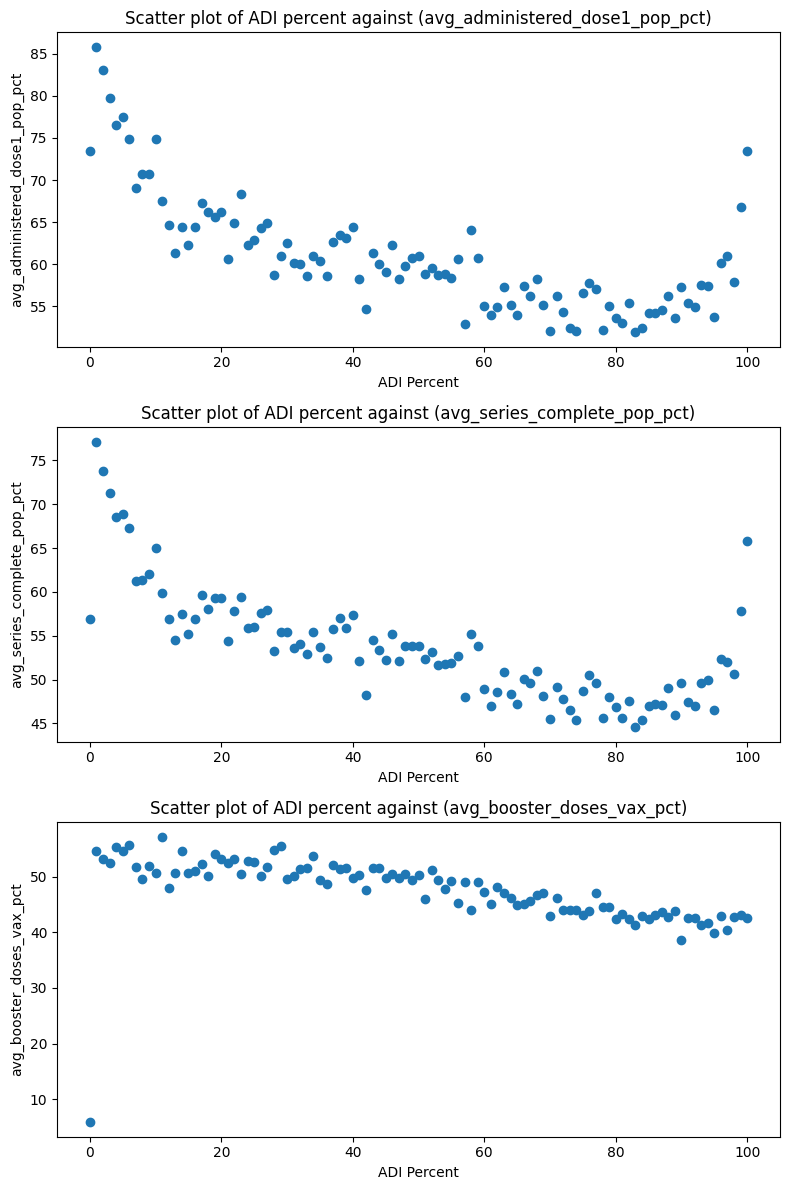

In [ ]:
rates = ['avg_administered_dose1_pop_pct',	'avg_series_complete_pop_pct',	'avg_booster_doses_vax_pct']

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

for i, rate in enumerate(rates):
    axs[i].scatter(df['area_deprivation_index_percent'], df[rate])
    axs[i].set_xlabel('ADI Percent')
    axs[i].set_ylabel(rate)
    axs[i].set_title(f'Scatter plot of ADI percent against ({rate})')

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import pearsonr

rates = ['avg_administered_dose1_pop_pct',	'avg_series_complete_pop_pct',	'avg_booster_doses_vax_pct']

for i, rate in enumerate(rates):
  r_value, _ = pearsonr(df['area_deprivation_index_percent'], df[rate])
  print(f'Correlation of {r_value:.2f} for ADI percent against {rate}')

Correlation of -0.72 for ADI percent against avg_administered_dose1_pop_pct
Correlation of -0.75 for ADI percent against avg_series_complete_pop_pct
Correlation of -0.52 for ADI percent against avg_booster_doses_vax_pct


**We see rather strong trends between regional deprivation and lower COVID vaccination rates!** Recall that higher ADI percent (to the right of graph) indicates higher deprivation. In all three of the plots above, we see that as ADI (county-level poverty) increases, COVID-19 vaccination rates (whether for first dose, second dose, or booster doses) decrease.

There are some caveats, nonetheless. The linear downward-sloping trend seems to fit the booster dose data the best; for first dose and primary series completion, the plots appear more messy. In particular:
1. The datapoint corresponding to 0% ADI (i.e. the richest counties in the US) has startlingly low vaccination rates in all three plots. This could potentially be a simple outlier in the data
2. The datapoints correspoding to 99%-100% ADI (i.e. the poorest counties in the US) has surprisingly high first-dose and primary-series vaccination rates.


In [ ]:
%%bigquery --project $project_id

SELECT county_name, state_name, area_deprivation_index_percent
FROM bigquery-public-data.broadstreet_adi.area_deprivation_index_by_county as t
WHERE area_deprivation_index_percent = 0
AND year = 2020

Query is running:   0%|          |

Downloading:   0%|          |

,county_name,state_name,area_deprivation_index_percent
0,Falls Church city,Virginia,0.0


In [ ]:
%%bigquery --project $project_id

SELECT county_name, state_name, area_deprivation_index_percent
FROM bigquery-public-data.broadstreet_adi.area_deprivation_index_by_county as t
WHERE area_deprivation_index_percent >= 99
AND year = 2020

Query is running:   0%|          |

Downloading:   0%|          |

,county_name,state_name,area_deprivation_index_percent
0,Clark County,Idaho,99.0
1,Brooks County,Texas,100.0
2,Cameron County,Texas,99.0
3,Culberson County,Texas,99.0
4,Dimmit County,Texas,99.0
...,...,...,...
58,Oglala Lakota County,South Dakota,100.0
59,Todd County,South Dakota,100.0
60,Ziebach County,South Dakota,99.0
61,McDowell County,West Virginia,99.0


It appears that only one county shown to have 0% ADI is [Falls Church city](https://en.wikipedia.org/wiki/Falls_Church,_Virginia) in Virginia. Falls Church city has a population of over 10,000 and is a predominantly white and overwhelmingly Democratic county, which makes it even more puzzling as to why its vaccination rate is so low. We currently have no explanation for this, except that it is possible the data collected from this county is somehow skewed or misreported.

As for the other end of the socioeconomic spectrum, it appears that there are 63 counties with an ADI between 99% and 100%. We likewise have no explanation for why these specific counties have higher vaccination rates.

Nonetheless, the fact remains that **there exists a strong negative correlation between ADI and all metrics of vaccination rate**. Let's explore further as to why that might be the case.

### 3.2 COVID-19 Vaccination Site Accessibility and ADI


One possible reason might be that its physically harder for those in poorer regions to access vaccination sites, especially those living in rural areas. Let's see if there's any correlation between vaccination site accessibility and ADI of counties.

In [ ]:
%%bigquery --project $project_id

SELECT
   distinct facility_place_id as uniq_place_ids
FROM
  `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_all`

Query is running:   0%|          |

Downloading:   0%|          |

,uniq_place_ids
0,ChIJAQAAANfpFogRjmEdiZ7FYFE
1,ChIJ4Y9VFvBgBYgRDRMMPxpzW6M
2,ChIJK1RrBW2F7ocRGb3B2PCDy24
3,ChIJfU-rMMmr-IgRQg3m2N7c3hE
4,ChIJm5ZVcXG3hVQRN6CqAW29gjw
...,...
58060,ChIJ0_8DKU_hrIkRmDMrTFtzM9k
58061,ChIJE9KOHibH6IcRLAi8VAJRJXs
58062,ChIJI1L0Tyy8xokREdqDIFmBLPI
58063,ChIJByP7xYPzk4cRZK19vJiVO4Q


In [ ]:
%%bigquery --project $project_id

SELECT
  COUNT(DISTINCT CONCAT(CAST(facility_latitude AS STRING), ',', CAST(facility_longitude AS STRING))) as num_distinct_lat_long
FROM
  `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_all`

Query is running:   0%|          |

Downloading:   0%|          |

,num_distinct_lat_long
0,55479


There are 58065 distinct vaccination facilities, but 55479 unique pairs of latitude-longitude. From the data, we see that latitude and longitude each have up to 4 decimal place precision, or roughly 11 meters (36 feet) precision. Having more unique facility_id than lat-long pairs suggest there are 2 or more vaccination sites within 100 square meters of each other in some instances.

Let's try to understand why there are 174195 rows in the dataset, but 58065 unique facilities.

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_all`
where facility_place_id in (
  select facility_place_id
  from
  `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_all`
  group by facility_place_id
  having count(*) > 1
)
order by facility_place_id

Query is running:   0%|          |

Downloading:   0%|          |

,facility_place_id,facility_provider_id,facility_name,facility_latitude,facility_longitude,facility_country_region,facility_country_region_code,facility_sub_region_1,facility_sub_region_1_code,facility_sub_region_2,facility_sub_region_2_code,facility_region_place_id,mode_of_transportation,travel_time_threshold_minutes,facility_catchment_boundary
0,ChIJ--0pSxV3PIgRog1ixJFwR1U,81fff7e4-bbce-4578-be2c-efb75664bf2b,Rite Aid,41.5660,-83.6549,United States,US,Ohio,US-OH,Lucas County,39095,ChIJS5kUC-SAO4gRIxIketBtTLY,walk,30,"POLYGON((-83.666758 41.5870797, -83.6687522 41..."
1,ChIJ--0pSxV3PIgRog1ixJFwR1U,81fff7e4-bbce-4578-be2c-efb75664bf2b,Rite Aid,41.5660,-83.6549,United States,US,Ohio,US-OH,Lucas County,39095,ChIJS5kUC-SAO4gRIxIketBtTLY,walk,60,"POLYGON((-83.6767281 41.5944653, -83.6820449 4..."
2,ChIJ--0pSxV3PIgRog1ixJFwR1U,81fff7e4-bbce-4578-be2c-efb75664bf2b,Rite Aid,41.5660,-83.6549,United States,US,Ohio,US-OH,Lucas County,39095,ChIJS5kUC-SAO4gRIxIketBtTLY,drive,45,"POLYGON((-84.1547253 41.7619115, -84.1863706 4..."
3,ChIJ--0pSxV3PIgRog1ixJFwR1U,81fff7e4-bbce-4578-be2c-efb75664bf2b,Rite Aid,41.5660,-83.6549,United States,US,Ohio,US-OH,Lucas County,39095,ChIJS5kUC-SAO4gRIxIketBtTLY,drive,30,"MULTIPOLYGON(((-83.6408283 41.9128468, -83.678..."
4,ChIJ--0pSxV3PIgRog1ixJFwR1U,81fff7e4-bbce-4578-be2c-efb75664bf2b,Rite Aid,41.5660,-83.6549,United States,US,Ohio,US-OH,Lucas County,39095,ChIJS5kUC-SAO4gRIxIketBtTLY,drive,15,"MULTIPOLYGON(((-83.6248662 41.4777533, -83.644..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580645,ChIJzzxlFwzj64cRJtO0GEadh8c,228ac2da-b1aa-4249-8d69-7a8ef739b807,Walmart Pharmacy,41.0232,-93.8004,United States,US,Iowa,US-IA,Clarke County,19039,ChIJW1ZqSlXi64cRg54QiSHqaaI,drive,30,"MULTIPOLYGON(((-93.8343617 40.631476, -93.8458..."
580646,ChIJzzxlFwzj64cRJtO0GEadh8c,228ac2da-b1aa-4249-8d69-7a8ef739b807,Walmart Pharmacy,41.0232,-93.8004,United States,US,Iowa,US-IA,Clarke County,19039,ChIJW1ZqSlXi64cRg54QiSHqaaI,walk,15,"POLYGON((-93.8152883 41.0161301, -93.7936803 4..."
580647,ChIJzzxlFwzj64cRJtO0GEadh8c,228ac2da-b1aa-4249-8d69-7a8ef739b807,Walmart Pharmacy,41.0232,-93.8004,United States,US,Iowa,US-IA,Clarke County,19039,ChIJW1ZqSlXi64cRg54QiSHqaaI,transit,45,GEOMETRYCOLLECTION EMPTY
580648,ChIJzzxlFwzj64cRJtO0GEadh8c,228ac2da-b1aa-4249-8d69-7a8ef739b807,Walmart Pharmacy,41.0232,-93.8004,United States,US,Iowa,US-IA,Clarke County,19039,ChIJW1ZqSlXi64cRg54QiSHqaaI,drive,15,"POLYGON((-93.7327191 41.1810083, -93.7847856 4..."


So we see that for each ``facility_id``, the thresholds to get to it depends on not just mode of transit (walk, drive or transit), but also depends on which boundary point we're looking at.

In [ ]:
%%bigquery --project $project_id
with t as (
SELECT
  ST_GEOGPOINT(facility_longitude, facility_latitude) as point, travel_time_threshold_minutes, mode_of_transportation
FROM
  `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_all`)
select zip_code, travel_time_threshold_minutes, mode_of_transportation
from `bigquery-public-data.geo_us_boundaries.zip_codes`
join t
on ST_WITHIN(point, zip_code_geom)

Query is running:   0%|          |

Downloading:   0%|          |

,zip_code,travel_time_threshold_minutes,mode_of_transportation
0,33324,15,walk
1,63090,15,walk
2,72023,15,walk
3,87532,15,walk
4,39211,15,walk
...,...,...,...
580455,11735,60,walk
580456,04860,60,walk
580457,02148,60,walk
580458,97223,60,walk


Let's generate three tables for different modes of transportation: walking, taking public transit and driving.

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `proj2_exploration.zipcode_vac_time_drive`
AS
with q as
(with t as (
SELECT
  ST_GEOGPOINT(facility_longitude, facility_latitude) as point, travel_time_threshold_minutes, mode_of_transportation
FROM
  `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_all`)
select zip_code, travel_time_threshold_minutes, mode_of_transportation
from `bigquery-public-data.geo_us_boundaries.zip_codes`
join t
on ST_WITHIN(point, zip_code_geom))

SELECT
  zip_code, avg(travel_time_threshold_minutes) as avg_travel_time
FROM
  q
  where mode_of_transportation = 'drive'
  group by zip_code

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `proj2_exploration.zipcode_vac_time_walk`
AS
with q as
(with t as (
SELECT
  ST_GEOGPOINT(facility_longitude, facility_latitude) as point, travel_time_threshold_minutes, mode_of_transportation
FROM
  `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_all`)
select zip_code, travel_time_threshold_minutes, mode_of_transportation
from `bigquery-public-data.geo_us_boundaries.zip_codes`
join t
on ST_WITHIN(point, zip_code_geom))

SELECT
  zip_code, avg(travel_time_threshold_minutes) as avg_travel_time
FROM
  q
  where mode_of_transportation = 'walk'
  group by zip_code

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `proj2_exploration.zipcode_vac_time_transit`
AS
with q as
(with t as (
SELECT
  ST_GEOGPOINT(facility_longitude, facility_latitude) as point, travel_time_threshold_minutes, mode_of_transportation
FROM
  `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_all`)
select zip_code, travel_time_threshold_minutes, mode_of_transportation
from `bigquery-public-data.geo_us_boundaries.zip_codes`
join t
on ST_WITHIN(point, zip_code_geom))

SELECT
  zip_code, avg(travel_time_threshold_minutes) as avg_travel_time
FROM
  q
  where mode_of_transportation = 'transit'
  group by zip_code

Query is running:   0%|          |

""


Let's look at summary statistics and visualizations for these data.

In [ ]:
query = """
with q as
(with t as (
SELECT
  ST_GEOGPOINT(facility_longitude, facility_latitude) as point, travel_time_threshold_minutes, mode_of_transportation
FROM
  `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_all`)
select zip_code, travel_time_threshold_minutes, mode_of_transportation
from `bigquery-public-data.geo_us_boundaries.zip_codes`
join t
on ST_WITHIN(point, zip_code_geom))

SELECT
  zip_code, (travel_time_threshold_minutes) as avg_travel_time
FROM
  q
  where mode_of_transportation = 'drive'

"""
print("summary statistics for time taken to drive to vaccination centres")
df = pd.io.gbq.read_gbq(query, project_id=project_id)
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

summary statistics for time taken to drive to vaccination centres


,avg_travel_time
count,174138.00
mean,30.00
std,12.25
min,15.00
25%,15.00
50%,30.00
75%,45.00
max,45.00


In [ ]:
query = """
with q as
(with t as (
SELECT
  ST_GEOGPOINT(facility_longitude, facility_latitude) as point, travel_time_threshold_minutes, mode_of_transportation
FROM
  `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_all`)
select zip_code, travel_time_threshold_minutes, mode_of_transportation
from `bigquery-public-data.geo_us_boundaries.zip_codes`
join t
on ST_WITHIN(point, zip_code_geom))

SELECT
  zip_code, (travel_time_threshold_minutes) as avg_travel_time
FROM
  q
  where mode_of_transportation = 'walk'

"""

print("summary statistics for time taken to walk to vaccination centres")
df = pd.io.gbq.read_gbq(query, project_id=project_id)
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

summary statistics for time taken to walk to vaccination centres


,avg_travel_time
count,232184.00
mean,37.50
std,16.77
min,15.00
25%,26.25
50%,37.50
75%,48.75
max,60.00


In [ ]:
query = """
with q as
(with t as (
SELECT
  ST_GEOGPOINT(facility_longitude, facility_latitude) as point, travel_time_threshold_minutes, mode_of_transportation
FROM
  `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_all`)
select zip_code, travel_time_threshold_minutes, mode_of_transportation
from `bigquery-public-data.geo_us_boundaries.zip_codes`
join t
on ST_WITHIN(point, zip_code_geom))

SELECT
  zip_code, (travel_time_threshold_minutes) as avg_travel_time
FROM
  q
  where mode_of_transportation = 'transit'

"""

print("summary statistics for time taken to take public transit to vaccination centres")
df = pd.io.gbq.read_gbq(query, project_id=project_id)
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

summary statistics for time taken to take public transit to vaccination centres


,avg_travel_time
count,174138.00
mean,45.00
std,12.25
min,30.00
25%,30.00
50%,45.00
75%,60.00
max,60.00


Now, we begin to notice an immediate problem: the travel times shown here are highly discretized. Drive time takes on only three possible values (15, 30, 45) and similarly for public transit time (30, 45, 60). Only walk time seems to have more granularity, and even then it doesn't seem to be highly continuous.

In [ ]:
query = """
with walkTime as (with q as
(with t as (
SELECT
  ST_GEOGPOINT(facility_longitude, facility_latitude) as point, travel_time_threshold_minutes, mode_of_transportation
FROM
  `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_all`)
select zip_code, travel_time_threshold_minutes, mode_of_transportation
from `bigquery-public-data.geo_us_boundaries.zip_codes`
join t
on ST_WITHIN(point, zip_code_geom))

SELECT
  zip_code, (travel_time_threshold_minutes) as avg_travel_time
FROM
  q
  where mode_of_transportation = 'walk'
  )
select adi.zipcode, adi.area_deprivation_index_percent, walkTime.avg_travel_time as avg_walk_travel_time
from
proj2_exploration.zipcode_adi as adi
join walkTime
on
adi.zipcode = walkTime.zip_code
"""

df = pd.io.gbq.read_gbq(query, project_id=project_id)
df.head()

,zipcode,area_deprivation_index_percent,avg_walk_travel_time
0,85009,100.0,15
1,45232,100.0,15
2,45232,100.0,60
3,45232,100.0,45
4,45232,100.0,45


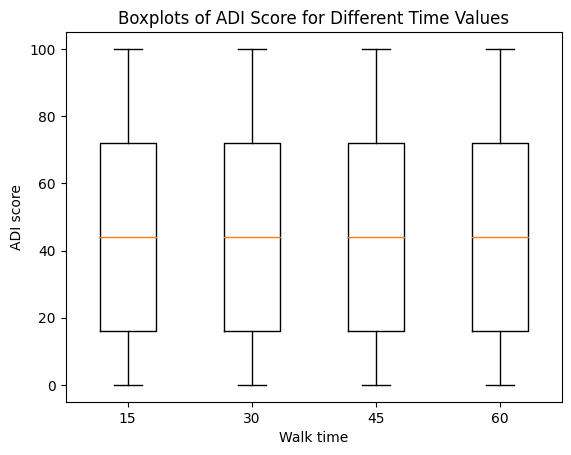

In [ ]:
time_values = [15, 30, 45, 60]

# Create a list to store the filtered DataFrames
time_filtered_dfs = [df[df['avg_walk_travel_time'] == t] for t in time_values]

# Create side-by-side boxplots
plt.boxplot([time_df['area_deprivation_index_percent'] for time_df in time_filtered_dfs], labels=time_values)
plt.xlabel('Walk time')
plt.ylabel('ADI score')
plt.title('Boxplots of ADI Score for Different Time Values')
plt.show()

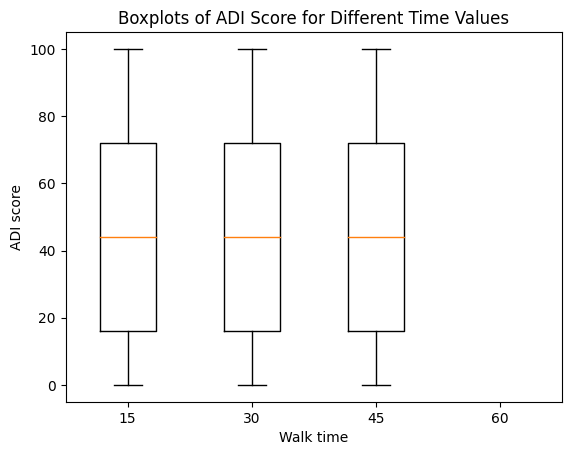

In [ ]:
query = """
with walkTime as (with q as
(with t as (
SELECT
  ST_GEOGPOINT(facility_longitude, facility_latitude) as point, travel_time_threshold_minutes, mode_of_transportation
FROM
  `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_all`)
select zip_code, travel_time_threshold_minutes, mode_of_transportation
from `bigquery-public-data.geo_us_boundaries.zip_codes`
join t
on ST_WITHIN(point, zip_code_geom))

SELECT
  zip_code, (travel_time_threshold_minutes) as avg_travel_time
FROM
  q
  where mode_of_transportation = 'drive'
  )
select adi.zipcode, adi.area_deprivation_index_percent, walkTime.avg_travel_time as avg_walk_travel_time
from
proj2_exploration.zipcode_adi as adi
join walkTime
on
adi.zipcode = walkTime.zip_code
"""

df = pd.io.gbq.read_gbq(query, project_id=project_id)
time_values = [15, 30, 45, 60]

# Create a list to store the filtered DataFrames
time_filtered_dfs = [df[df['avg_walk_travel_time'] == t] for t in time_values]

# Create side-by-side boxplots
plt.boxplot([time_df['area_deprivation_index_percent'] for time_df in time_filtered_dfs], labels=time_values)
plt.xlabel('Walk time')
plt.ylabel('ADI score')
plt.title('Boxplots of ADI Score for Different Time Values')
plt.show()

Hmm. The above boxplots look *too* clean. This is probably the result of the discretization of the walk times in the underlying ``bigquery-public-data.covid19_vaccination_access`` dataset.

Finally, let's consider the average number of vaccination sites for all counties rounded by their ADI score.

Text(0, 0.5, 'Avg num of vaccination sites')

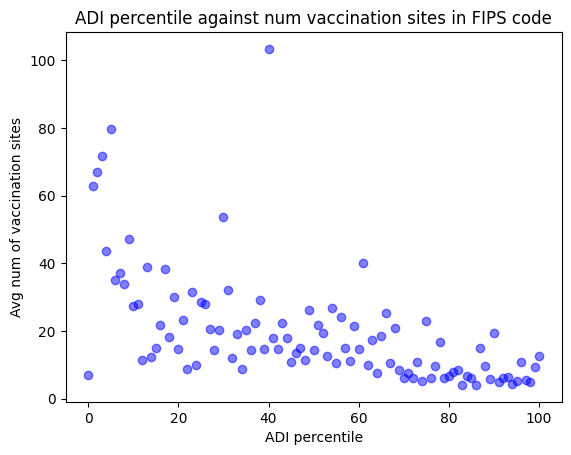

In [ ]:
query = """
WITH
  r AS (
  WITH
    t AS (
    SELECT
      facility_sub_region_2_code,
      COUNT(DISTINCT facility_place_id) AS unique_place_count
    FROM
      `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_walk`
    GROUP BY
      facility_sub_region_2_code)
  SELECT
    t.facility_sub_region_2_code,
    t.unique_place_count,
    q.area_deprivation_index_percent
  FROM
    t
  JOIN
    `cs145-project-sandbox.proj2_exploration.fipscode_adi` AS q
  ON
    t.facility_sub_region_2_code = q.county_fips_code)
SELECT
  AVG(r.unique_place_count) AS avg_places,
  r.area_deprivation_index_percent
FROM
  r
GROUP BY
  r.area_deprivation_index_percent
"""

df = pd.io.gbq.read_gbq(query, project_id=project_id)

plt.scatter(df['area_deprivation_index_percent'], df['avg_places'], color='blue', alpha=0.5)
plt.title('ADI percentile against num vaccination sites in FIPS code')
plt.xlabel('ADI percentile')
plt.ylabel('Avg num of vaccination sites')

Let's see the spearman's rho and p value, and coefficient of determinant

In [ ]:
query = """
WITH
  r AS (
  WITH
    t AS (
    SELECT
      facility_sub_region_2_code,
      COUNT(DISTINCT facility_place_id) AS unique_place_count
    FROM
      `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_walk`
    GROUP BY
      facility_sub_region_2_code)
  SELECT
    t.facility_sub_region_2_code,
    t.unique_place_count,
    q.area_deprivation_index_percent
  FROM
    t
  JOIN
    `cs145-project-sandbox.proj2_exploration.fipscode_adi` AS q
  ON
    t.facility_sub_region_2_code = q.county_fips_code)
SELECT
  *
  from r
"""

df = pd.io.gbq.read_gbq(query, project_id=project_id)

spearman_corr, p_value = spearmanr(df['unique_place_count'], df['area_deprivation_index_percent'], alternative='less')

In [ ]:
spearman_corr, p_value

(-0.2805225567336802, 3.321062581746152e-53)

While seems to be a trend between number of vaccination sites and ADI, the disparity could possibly be due to other factors (differences in population, for example). Furthermore, the positioning of sites could have been decided by other factors; for instance, in the CDC Vaccination Program Operational Guidance, it emphasizes vaccination for critical populations (healthcare workers, elderly) first. It's possible that vaccination locations were decided to reduce disparity between accessibility, while considering societal efficacy. Furthermore, the travel time resolution (15 minutes) and range (15-60 minutes) isn't too precise. All in all, we can't infer any conclusions from this data.

CDC Vaccination Program Handbook: https://www.cdc.gov/vaccines/imz-managers/downloads/Covid-19-Vaccination-Program-Interim_Playbook.pdf

We further compare population of county against number of vaccination sites. County population was adopted from: https://www2.census.gov/programs-surveys/popest/datasets/2020-2022/counties/totals/

fipscode was processed through simple concat in excel. new table in bigquery created with below:

In [ ]:
query = """create or replace table proj2_exploration.county_pop as
SELECT format("%05d", fipscode) as fipscode, POPESTIMATE2022
 FROM `cs145-project-sandbox.proj2_exploration.county_pop` order by fipscode"""

Text(0, 0.5, 'Avg num of vaccination sites per 10k population')

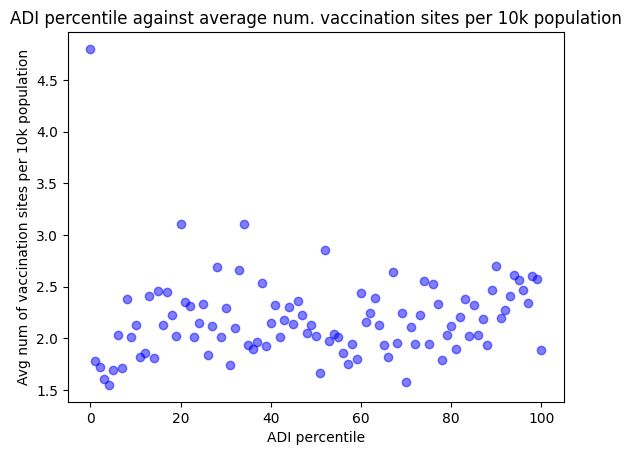

In [ ]:
query = """
with v as (WITH
  r AS (
  WITH
    t AS (
    SELECT
      facility_sub_region_2_code,
      COUNT(DISTINCT facility_place_id) AS unique_place_count
    FROM
      `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_walk`
    GROUP BY
      facility_sub_region_2_code)
  SELECT
    t.facility_sub_region_2_code,
    t.unique_place_count,
    q.area_deprivation_index_percent
  FROM
    t
  JOIN
    `cs145-project-sandbox.proj2_exploration.fipscode_adi` AS q
  ON
    t.facility_sub_region_2_code = q.county_fips_code)
SELECT
   r.*, pop.POPESTIMATE2022, r.unique_place_count / (pop.POPESTIMATE2022 / 10000) as sites_per_10k
   from r
   join `cs145-project-sandbox.proj2_exploration.county_pop` as pop
   on r.facility_sub_region_2_code = cast(pop.fipscode as string)
   )
   select avg(v.sites_per_10k) as sites_per_10k,v.area_deprivation_index_percent
   from v
   group by v.area_deprivation_index_percent
"""

df = pd.io.gbq.read_gbq(query, project_id=project_id)

plt.scatter(df['area_deprivation_index_percent'], df['sites_per_10k'], color='blue', alpha=0.5)
plt.title('ADI percentile against average num. vaccination sites per 10k population')
plt.xlabel('ADI percentile')
plt.ylabel('Avg num of vaccination sites per 10k population')

### 3.3 COVID-19 Vaccination Search Insights across ADI

Another possible explanation is that there are differences in interest and willingness to receive vaccinations betweebn the rich and poor. Here, we'll explore how vaccine interest, estimated by search terms, correlates with ADI of a region.

In [ ]:
query = """
SELECT
  adi.zipcode,
  AVG(adi.area_deprivation_index_percent) AS avg_area_deprivation_index_percent,
  AVG(insights.sni_covid19_vaccination) AS avg_vaccination_score,
  AVG(insights.sni_vaccination_intent) AS avg_intention_score,
  AVG(insights.sni_safety_side_effects) AS avg_safety_concern_score
FROM
  `proj2_exploration.us_covid_search_insights` AS insights
JOIN
  proj2_exploration.zipcode_adi AS adi
ON
  insights.sub_region_3_code = adi.zipcode
GROUP BY
  adi.zipcode
"""

df = pd.io.gbq.read_gbq(query, project_id=project_id)

In [ ]:
df.head()

,zipcode,avg_area_deprivation_index_percent,avg_vaccination_score,avg_intention_score,avg_safety_concern_score
0,01001,25.0,28.263710,14.824912,8.782339
1,01002,31.0,32.123020,9.890742,4.846328
2,01005,15.0,35.394680,18.944245,9.464680
3,01007,11.0,34.714759,16.133900,8.083392
4,01008,12.0,77.561958,59.088647,28.350600


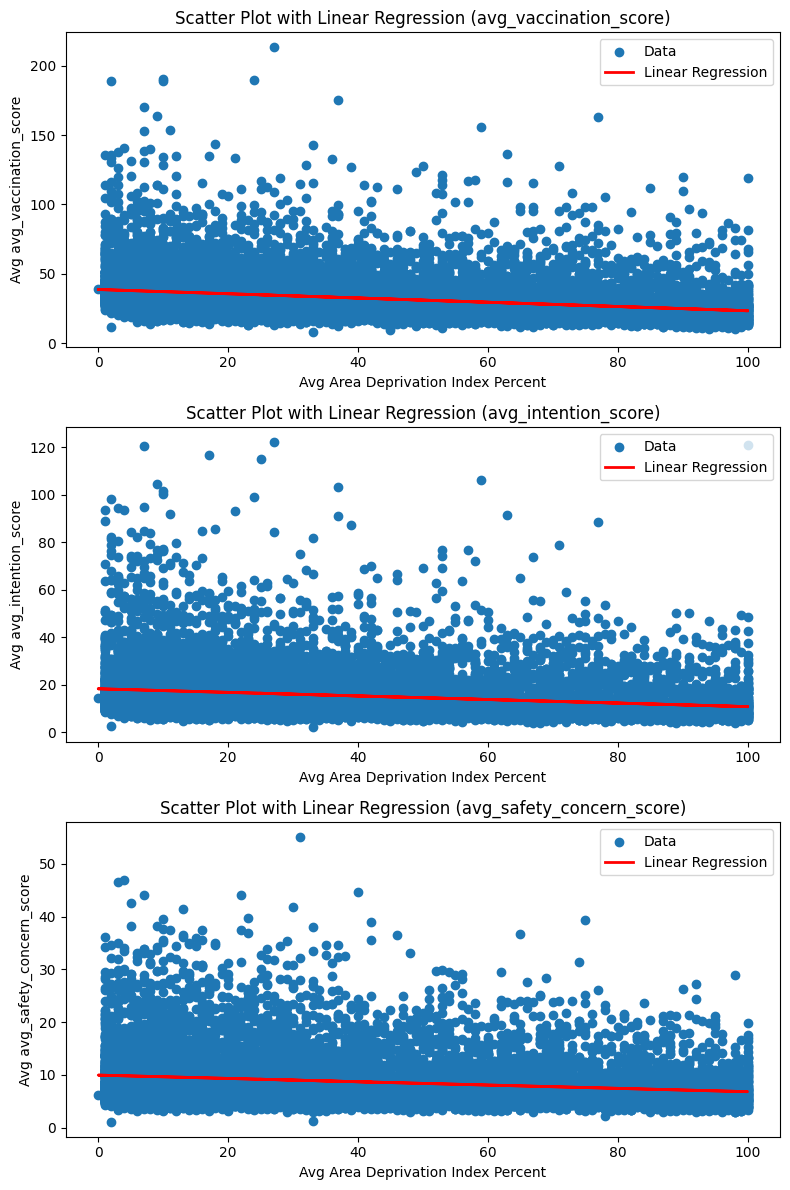

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Assuming 'df' is your DataFrame with the specified columns
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# List of scores
scores = ['avg_vaccination_score', 'avg_intention_score', 'avg_safety_concern_score']

for i, score in enumerate(scores):
    # Filter out NaN values
    mask = ~np.isnan(df['avg_area_deprivation_index_percent']) & ~np.isnan(df[score])
    X = df['avg_area_deprivation_index_percent'][mask].values.reshape(-1, 1)
    y = df[score][mask].values

    # Scatter plot
    axs[i].scatter(X, y, label='Data')

    # Linear regression
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # Plot linear regression line
    axs[i].plot(X, y_pred, color='red', linewidth=2, label='Linear Regression')

    axs[i].set_xlabel('Avg Area Deprivation Index Percent')
    axs[i].set_ylabel(f'Avg {score}')
    axs[i].set_title(f'Scatter Plot with Linear Regression ({score})')
    axs[i].legend()

plt.tight_layout()
plt.show()

As a quick notational clarification,
1. ``avg_vaccination_score`` refers to the relative number of Google searches related to COVID-19 vaccines.
2. ``avg_intention_score`` refers to the relative number of Google searches about **how to receive** COVID-19 vaccines.
3. ``avg_safety_concern_score`` refers to the relative number of Google searches about **safety concerns related to** COVID-19 vaccines.

To elucidate this further, googling "COVID-19 vaccination rate" counts under #1; googling "COVID-19 vaccine sites near me" counts under #1 and #2, and "COVID-19 vaccine autism" counts under #1 and #3.

In all three plots above, each point represents a county, with its general interest, intention and safety concern scores for COVID-19 vaccines. Its hard to see what's going on -- let's bucket the scores according to ADI scores, as we did for vaccination rates previously.

In [ ]:
query = """
with T as (SELECT
  adi.zipcode,
  AVG(adi.area_deprivation_index_percent) AS avg_area_deprivation_index_percent,
  AVG(insights.sni_covid19_vaccination) AS avg_vaccination_score,
  AVG(insights.sni_vaccination_intent) AS avg_intention_score,
  AVG(insights.sni_safety_side_effects) AS avg_safety_concern_score
FROM
  `proj2_exploration.us_covid_search_insights` AS insights
JOIN
  proj2_exploration.zipcode_adi AS adi
ON
  insights.sub_region_3_code = adi.zipcode
GROUP BY
  adi.zipcode)
select avg_area_deprivation_index_percent as area_deprivation_index_percent, avg(avg_vaccination_score) as avg_vaccine_score, avg(avg_intention_score) as avg_intention_score,
avg(avg_safety_concern_score) as avg_safety_concern_score
from T
group by avg_area_deprivation_index_percent
having avg_area_deprivation_index_percent > 0
"""

df = pd.io.gbq.read_gbq(query, project_id=project_id)

In [ ]:
df

,area_deprivation_index_percent,avg_vaccine_score,avg_intention_score,avg_safety_concern_score
0,25.0,33.831934,15.850787,8.980133
1,31.0,34.368484,16.451520,9.671964
2,15.0,33.762864,15.711466,9.074738
3,11.0,34.791803,16.486955,8.905191
4,12.0,35.615267,16.774531,8.964473
...,...,...,...,...
95,97.0,21.271671,9.621548,5.956427
96,85.0,25.737273,10.253612,6.600706
97,66.0,29.166932,14.019681,8.130836
98,83.0,27.008221,12.172705,7.726141


Text(0.5, 0, 'ADI')

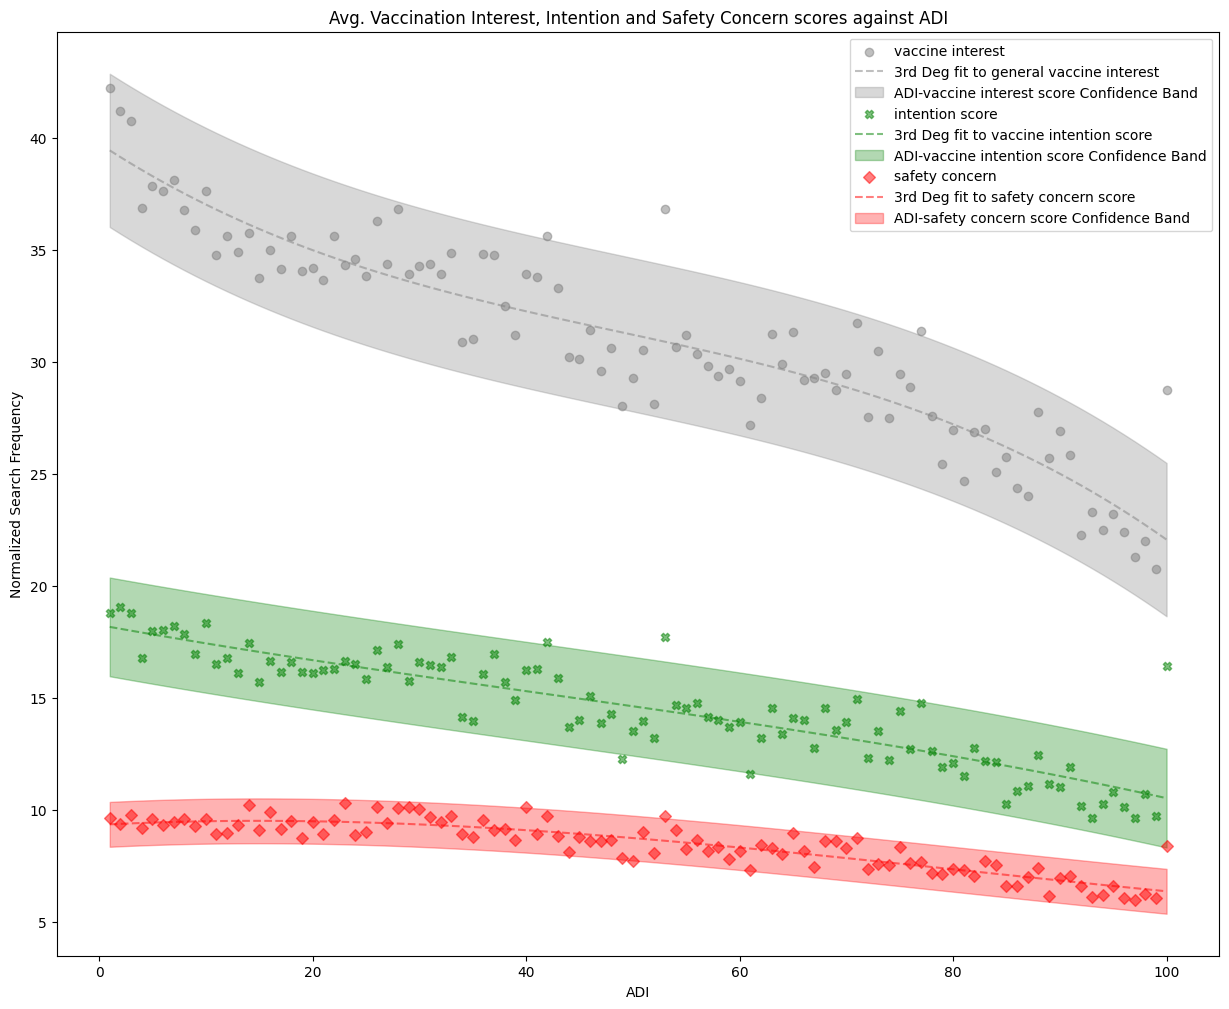

In [ ]:
degree = 3
color = 'gray'
plt.figure(figsize=(15, 12))

plt.scatter(df['area_deprivation_index_percent'], df['avg_vaccine_score'], color=color, alpha=0.5, label='vaccine interest')
p = np.polyfit(df['area_deprivation_index_percent'], df['avg_vaccine_score'], degree)
p_func = np.poly1d(p)

# Generate x values for the line
x_values = np.linspace(df['area_deprivation_index_percent'].min(), df['area_deprivation_index_percent'].max(), 100)

# Calculate the y values using the polynomial function
y_values = p_func(x_values)

# Plot the polynomial lin
plt.plot(x_values, y_values, color=color, label='3rd Deg fit to general vaccine interest',  alpha = 0.5, linestyle = '--')

# Calculate confidence intervals
y_pred = np.polyval(p, df['area_deprivation_index_percent'])
residuals = df['avg_vaccine_score'] - y_pred
std_err = np.std(residuals)
conf = 1.96 * std_err  # 95% confidence interval

# Plot confidence band
plt.fill_between(x_values, y_values - conf, y_values + conf, color=color, alpha=0.3, label='ADI-vaccine interest score Confidence Band')

# --------------------------------------
color='green'
plt.scatter(df['area_deprivation_index_percent'], df['avg_intention_score'], color=color, marker = 'X', alpha=0.5, label = 'intention score')
p = np.polyfit(df['area_deprivation_index_percent'], df['avg_intention_score'], degree)
p_func = np.poly1d(p)

# Generate x values for the line
x_values = np.linspace(df['area_deprivation_index_percent'].min(), df['area_deprivation_index_percent'].max(), 100)

# Calculate the y values using the polynomial function
y_values = p_func(x_values)

# Plot the polynomial lin
plt.plot(x_values, y_values, color=color, label='3rd Deg fit to vaccine intention score',  alpha = 0.5, linestyle = '--')

# Calculate confidence intervals
y_pred = np.polyval(p, df['area_deprivation_index_percent'])
residuals = df['avg_intention_score'] - y_pred
std_err = np.std(residuals)
conf = 1.96 * std_err  # 95% confidence interval

# Plot confidence band
plt.fill_between(x_values, y_values - conf, y_values + conf, color=color, alpha=0.3, label='ADI-vaccine intention score Confidence Band')
# --------------------------------------------------------------------------
color = 'red'
degree = 3
plt.scatter(df['area_deprivation_index_percent'], df['avg_safety_concern_score'], color=color,marker = 'D', alpha=0.5, label='safety concern')
p = np.polyfit(df['area_deprivation_index_percent'], df['avg_safety_concern_score'], degree)
p_func = np.poly1d(p)

# Generate x values for the line
x_values = np.linspace(df['area_deprivation_index_percent'].min(), df['area_deprivation_index_percent'].max(), 100)

# Calculate the y values using the polynomial function
y_values = p_func(x_values)

# Plot the polynomial lin
plt.plot(x_values, y_values, color=color, label='3rd Deg fit to safety concern score', alpha = 0.5, linestyle = '--')

# Calculate confidence intervals
y_pred = np.polyval(p, df['area_deprivation_index_percent'])
residuals = df['avg_safety_concern_score'] - y_pred
std_err = np.std(residuals)
conf = 1.96 * std_err  # 95% confidence interval

# Plot confidence band
plt.fill_between(x_values, y_values - conf, y_values + conf, color=color, alpha=0.3, label='ADI-safety concern score Confidence Band')
# -------------------------------------
plt.title('Avg. Vaccination Interest, Intention and Safety Concern scores against ADI')
plt.legend()
# plt.ylim(35, 90)
plt.ylabel('Normalized Search Frequency')
plt.xlabel('ADI')

In [ ]:
spearman_corr, p_value = spearmanr(df['area_deprivation_index_percent'], df['avg_vaccine_score'], alternative='less')
print("Spearman's correlation coefficient between area_deprivation_index_percent and avg_vaccine_score:", spearman_corr)
print("with p value : ", p_value)
print()
spearman_corr, p_value = spearmanr(df['area_deprivation_index_percent'], df['avg_intention_score'], alternative='less')
print("Spearman's correlation coefficient between area_deprivation_index_percent and avg_intention_score:", spearman_corr)
print("with p value : ", p_value)
print()
spearman_corr, p_value = spearmanr(df['area_deprivation_index_percent'], df['avg_safety_concern_score'], alternative='less')
print("Spearman's correlation coefficient between area_deprivation_index_percent and avg_safety_concern_score:", spearman_corr)
print("with p value : ", p_value)
print()

Spearman's correlation coefficient between area_deprivation_index_percent and avg_vaccine_score: -0.9196519651965196
with p value :  7.268875206030114e-42

Spearman's correlation coefficient between area_deprivation_index_percent and avg_intention_score: -0.8725352535253524
with p value :  1.4970601422951285e-32

Spearman's correlation coefficient between area_deprivation_index_percent and avg_safety_concern_score: -0.8614461446144613
with p value :  6.752268266210692e-31



In [ ]:
# let's see strenght of correlation:
from scipy.stats import pearsonr

scores = ['avg_vaccine_score',	'avg_intention_score',	'avg_safety_concern_score']

for i, score in enumerate(scores):
  r_value, _ = pearsonr(adi_percent_scores['adi_percent'], adi_percent_scores[score])
  print(f'Correlation of {r_value:.2f} for ADI percent against {score}')

Correlation of -0.92 for ADI percent against avg_vaccine_score
Correlation of -0.87 for ADI percent against avg_intention_score
Correlation of -0.80 for ADI percent against avg_safety_concern_score


**We see that poorer regions have less relative searches on COVID-19 in general, as well as significantly less indication of vaccination intention, and slightly less indication of vaccine safety concerns, according to search history.** (Recall that higher ADI indicates poorer regions). Strong negative linear correlation exists between deprivation scores and interest in COVID-19 vaccination.

Naturally, we again have the same outliers on the extreme ends of the ADI spectrum popping up
1. Falls Church city (0% ADI) seems to have high number of searches about COVID-19 vaccines in general, but few searches about vaccine intention and safety concerns. This could mean that the county as a whole is generally disinterested in obtaining COVID-19 vaccines, and rules out the possibility that they're avoiding the vaccine because of safety concerns. Notably, this is the second dataset we've seen where Falls Church city emerged as an outlier, suggesting that it is not an issue with the data collection process used in any single dataset, but rather something intrinsic to the county itself that is causing it to be an outlier.
2. The many counties with 99-100% ADI have higher-than-expected searches about vaccines in all three categories. This shows that such counties display significant interest in the vaccine -- both the intention to obtain the vaccine, and concerns about its safety.

### 3.4 Vaccine Hesitancy Polls across ADI

Polled vaccine hesitancy might be another insightful metric; compared to analyzing search terms, it's a more direct measure of vaccination willingness. Let's see if there's any correlation between vaccine hesitancy and ADI.

Text(0, 0.5, 'Pct Pop. vaccine hesitant')

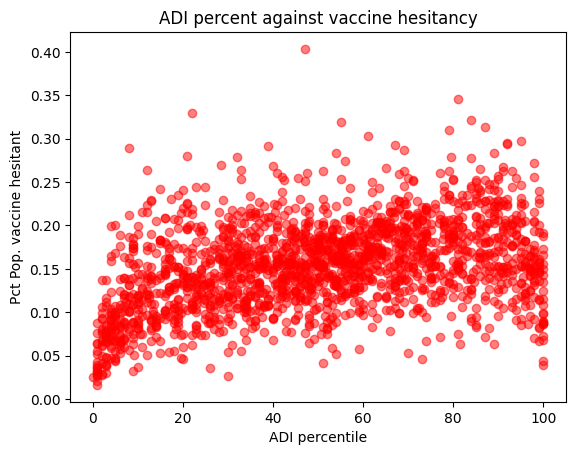

In [ ]:
query = """
WITH
  fipscode_hesitancy AS (
  WITH
    t AS (
    SELECT
      (lsad_name) AS county,
      (county_fips_code) AS fipscode
    FROM
      `bigquery-public-data.geo_us_boundaries.counties` ),
    q AS (
    SELECT
      AVG(final_zip_pred) AS avg_hesitancy,
      county_name
    FROM
      `cs145-project-sandbox.proj2_exploration.vaccine_hesitancy_poll_county`
    GROUP BY
      county_name )
  SELECT
    q.avg_hesitancy,
    county_name,
    fipscode
  FROM
    q
  JOIN
    t
  ON
    q.county_name = t.county)
SELECT
  avg_hesitancy,
  county_name,
  AVG(area_deprivation_index_percent) AS avg_county_adi
FROM
  cs145-project-sandbox.proj2_exploration.fipscode_adi AS adi
JOIN
  fipscode_hesitancy
ON
  adi.county_fips_code = fipscode_hesitancy.fipscode
GROUP BY
  avg_hesitancy,
  county_name
"""

df = pd.io.gbq.read_gbq(query, project_id=project_id)

plt.scatter(df['avg_county_adi'], df['avg_hesitancy'], color='red', alpha=0.5)
plt.title('ADI percent against vaccine hesitancy')
plt.xlabel('ADI percentile')
plt.ylabel('Pct Pop. vaccine hesitant')


The above are percentage of people polled as hesitant against ADI of that county. Once again, let's discretize average ADI into nearest integers, and get the average vaccine hesitancy for each ADI score.

Text(0.5, 0, 'ADI')

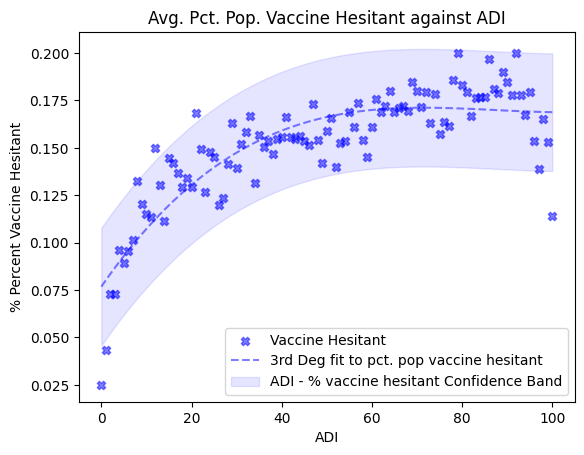

In [ ]:
query = """
with R as (WITH
  fipscode_hesitancy AS (
  WITH
    t AS (
    SELECT
      (lsad_name) AS county,
      (county_fips_code) AS fipscode
    FROM
      `bigquery-public-data.geo_us_boundaries.counties` ),
    q AS (
    SELECT
      AVG(final_zip_pred) AS avg_hesitancy,
      county_name
    FROM
      `cs145-project-sandbox.proj2_exploration.vaccine_hesitancy_poll_county`
    GROUP BY
      county_name )
  SELECT
    q.avg_hesitancy,
    county_name,
    fipscode
  FROM
    q
  JOIN
    t
  ON
    q.county_name = t.county)
SELECT
  avg_hesitancy,
  county_name,
  AVG(area_deprivation_index_percent) AS avg_county_adi
FROM
  cs145-project-sandbox.proj2_exploration.fipscode_adi AS adi
JOIN
  fipscode_hesitancy
ON
  adi.county_fips_code = fipscode_hesitancy.fipscode
GROUP BY
  avg_hesitancy,
  county_name)
SELECT
  ROUND(avg_county_adi) AS avg_county_adi,
  AVG(avg_hesitancy) AS avg_hesitancy
FROM
  R
GROUP BY
  avg_county_adi
ORDER BY
  avg_county_adi
"""

df = pd.io.gbq.read_gbq(query, project_id=project_id)

# plt.scatter(df['rounded_avg_county_adi'], df['average_hesitancy'], color='red', alpha=0.5)
# plt.title('ADI percentile against average vaccine hesitancy')
# plt.xlabel('ADI percentile (nearest integer)')
# plt.ylabel('Avg vaccine hesitant pct. pop for counties at ADI')


color='blue'
plt.scatter(df['avg_county_adi'], df['avg_hesitancy'], color=color, marker = 'X', alpha=0.5, label = 'Vaccine Hesitant')
p = np.polyfit(df['avg_county_adi'], df['avg_hesitancy'], degree)
p_func = np.poly1d(p)

# Generate x values for the line
x_values = np.linspace(df['avg_county_adi'].min(), df['avg_county_adi'].max(), 100)

# Calculate the y values using the polynomial function
y_values = p_func(x_values)

# Plot the polynomial lin
plt.plot(x_values, y_values, color=color, label='3rd Deg fit to pct. pop vaccine hesitant',  alpha = 0.5, linestyle = '--')

# Calculate confidence intervals
y_pred = np.polyval(p, df['avg_county_adi'])
residuals = df['avg_hesitancy'] - y_pred
std_err = np.std(residuals)
conf = 1.96 * std_err  # 95% confidence interval

# Plot confidence band
plt.fill_between(x_values, y_values - conf, y_values + conf, color=color, alpha=0.1, label='ADI - % vaccine hesitant Confidence Band')


plt.title('Avg. Pct. Pop. Vaccine Hesitant against ADI')
plt.legend()
# plt.ylim(35, 90)
plt.ylabel('% Percent Vaccine Hesitant')
plt.xlabel('ADI')

In [ ]:
spearman_corr, p_value = spearmanr(df['avg_county_adi'], df['avg_hesitancy'], alternative='greater')
print("Spearman's correlation coefficient between avg_county_adi and avg_hesitancy:", spearman_corr)
print("with p value : ", p_value)
print()

Spearman's correlation coefficient between avg_county_adi and avg_hesitancy: 0.7667559697146185
with p value :  4.5314356414807425e-21



It does look like there's a slight trend. Counties with higher deprivation tend to have higher percentage of population who are vaccine hesitant, apart from the 99%-100% ADI counties. All in all, this inverted U-shaped curve is oddly reminiscent of the curve for vaccination rates some sections ago.

So far, it does seem like deprivation is associated with lower interest and willingness to receive vaccinations. The following sections explore potential reasons for this trend.

### 3.5 Tweet Sentiment analysis

A possible hypothesis would be that populations in poorer regions are unwilling to comply with societial encouragements to become vaccinated, or do not feel comfortable receiving vaccines. One proxy to examine could be Twitter sentiments regarding COVID-19. If adverse sentiments such as anger or disgust could indicate distrust for COVID-19 developments and/or vaccinations among communities.

In [ ]:
query = """
WITH
  T AS (
  SELECT
    round(AVG(anger), 4) AS anger,
    round(AVG(disgust), 4) AS disgust,
    round(AVG(fear), 4) AS fear,
    round(AVG(sadness), 4) AS sadness,
    FIPS AS fipscode
  FROM
    `cs145-project-sandbox.proj2_exploration.tweet_data`
  GROUP BY
    FIPS)
SELECT
  fipscode,
  anger,
  disgust,
  fear,
  sadness,
  area_deprivation_index_percent
FROM
  T
JOIN
  cs145-project-sandbox.proj2_exploration.fipscode_adi AS adi
ON
  T.fipscode = CAST(adi.county_fips_code AS int64)
"""
df = pd.io.gbq.read_gbq(query, project_id=project_id)

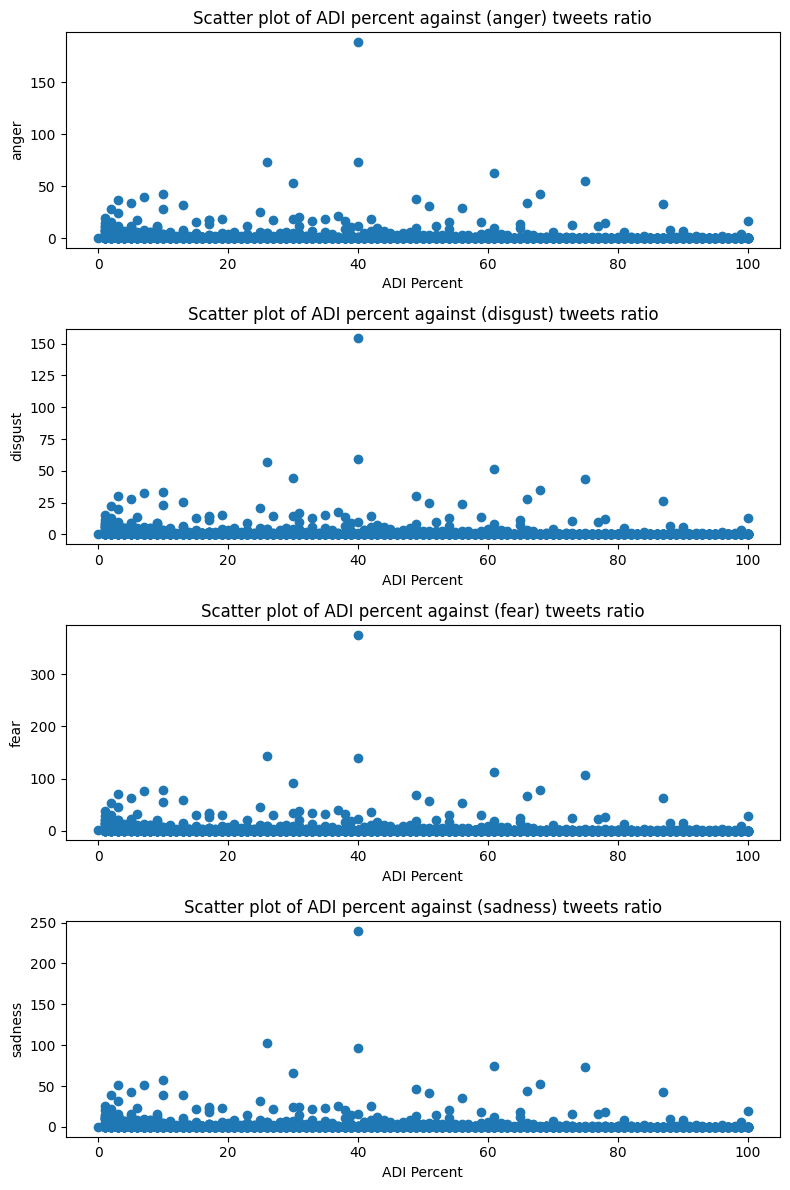

In [ ]:
emotions = ['anger' , 'disgust' , 'fear' , 'sadness']

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(8, 12))

for i, emotion in enumerate(emotions):
    filtered_df = df[['area_deprivation_index_percent', emotion]].dropna()

    axs[i].scatter(filtered_df['area_deprivation_index_percent'], filtered_df[emotion], label='Data')

    X = filtered_df['area_deprivation_index_percent'].values.reshape(-1, 1)
    y = filtered_df[emotion].values
    axs[i].set_xlabel('ADI Percent')
    axs[i].set_ylabel(emotion)
    axs[i].set_title(f'Scatter plot of ADI percent against ({emotion}) tweets ratio')
    # axs[i].legend()

plt.tight_layout()
plt.show()

As always, let's examine average scores among counties by ADI percent.

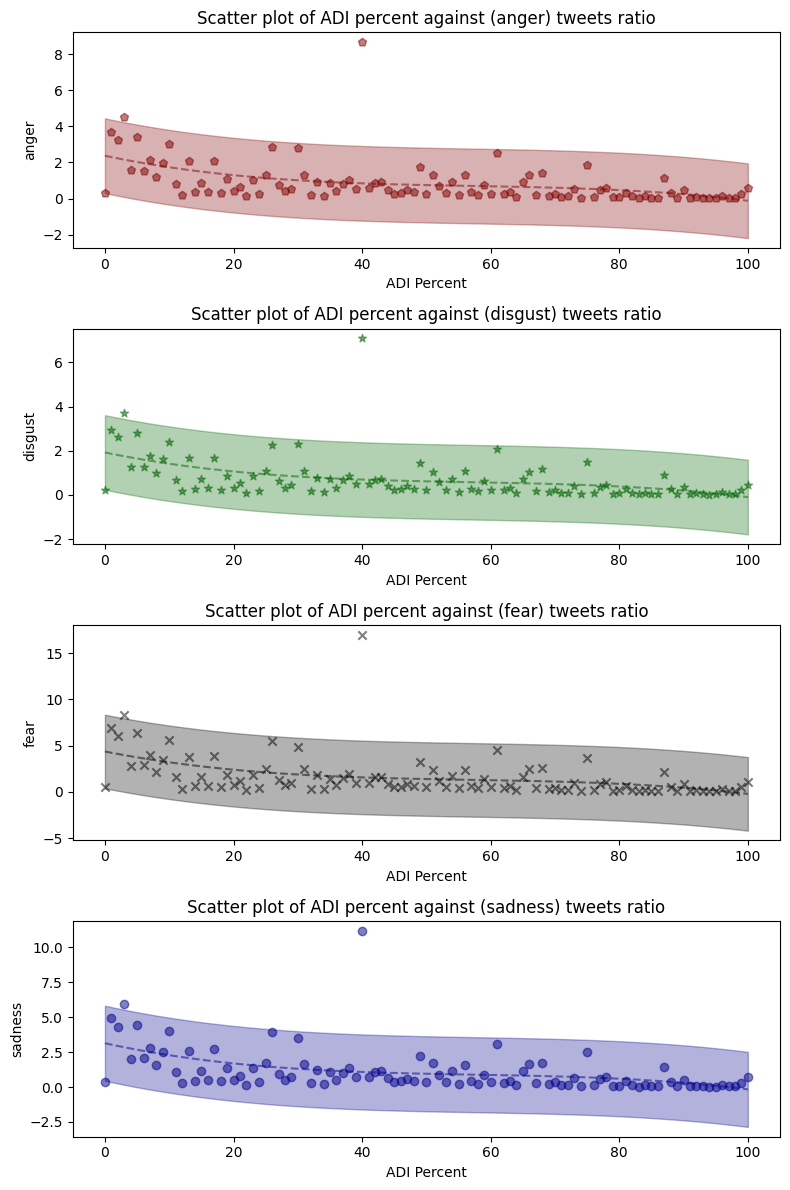

In [ ]:
query = """
WITH
  Q AS (
  WITH
    T AS (
    SELECT
      ROUND(AVG(anger), 4) AS anger,
      ROUND(AVG(disgust), 4) AS disgust,
      ROUND(AVG(fear), 4) AS fear,
      ROUND(AVG(sadness), 4) AS sadness,
      FIPS AS fipscode
    FROM
      `cs145-project-sandbox.proj2_exploration.tweet_data`
    GROUP BY
      FIPS)
  SELECT
    fipscode,
    anger,
    disgust,
    fear,
    sadness,
    area_deprivation_index_percent
  FROM
    T
  JOIN
    cs145-project-sandbox.proj2_exploration.fipscode_adi AS adi
  ON
    T.fipscode = CAST(adi.county_fips_code AS int64))
SELECT
  AVG(anger) AS anger,
  AVG(disgust) AS disgust,
  AVG(fear) AS fear,
  AVG(sadness) AS sadness,
  area_deprivation_index_percent
FROM
  Q
GROUP BY
  area_deprivation_index_percent
"""
df = pd.io.gbq.read_gbq(query, project_id=project_id)
fig, axs = plt.subplots(4, 1, figsize=(8, 12))
emotions = ['anger' , 'disgust' , 'fear' , 'sadness']
colors = ['maroon', 'darkgreen', 'black', 'darkblue']
markers = ['p', '*', 'x', 'o']
for i, emotion in enumerate(emotions):
    degree = 3
    p = np.polyfit(df['area_deprivation_index_percent'], df[emotion], degree)
    p_func = np.poly1d(p)

    x_values = np.linspace(df['area_deprivation_index_percent'].min(), df['area_deprivation_index_percent'].max(), 100)
    y_values = p_func(x_values)

    # Calculate confidence intervals
    y_pred = np.polyval(p, df['area_deprivation_index_percent'])
    residuals = df[emotion] - y_pred
    std_err = np.std(residuals)
    conf = 1.96 * std_err  # 95% confidence interval

    axs[i].scatter(df['area_deprivation_index_percent'], df[emotion], color=colors[i], marker=markers[i], alpha=0.5, label=emotion)
    axs[i].plot(x_values, y_values, color=colors[i], label=f'3rd Deg fit to {emotion}', alpha=0.5, linestyle='--')
    axs[i].fill_between(x_values, y_values - conf, y_values + conf, color=colors[i], alpha=0.3, label=f'ADI-{emotion} Confidence Band')

    axs[i].set_xlabel('ADI Percent')
    axs[i].set_ylabel(emotion)
    axs[i].set_title(f'Scatter plot of ADI percent against ({emotion}) tweets ratio')
    # axs[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
emotions = ['anger' , 'disgust' , 'fear' , 'sadness']

for i, emotion in enumerate(emotions):
    spearman_corr, p_value = spearmanr(df['area_deprivation_index_percent'], df[emotion])
    print(f"Spearman's correlation coefficient between area_deprivation_index_percent and {emotion}:", spearman_corr)
    print("with p value : ", p_value)
    print()


Spearman's correlation coefficient between area_deprivation_index_percent and anger: -0.6242166569598135
with p value :  3.0723912017179324e-12

Spearman's correlation coefficient between area_deprivation_index_percent and disgust: -0.6266278392545137
with p value :  2.3954618921865507e-12

Spearman's correlation coefficient between area_deprivation_index_percent and fear: -0.614828188701223
with p value :  7.93613771983559e-12

Spearman's correlation coefficient between area_deprivation_index_percent and sadness: -0.6328246942341292
with p value :  1.25103033043399e-12



It doesn't seem like poorer counties express adverse sentiments (anger, sadness, fear, disgust) on Twitter more than richer ones. In fact, it seems to be the other way around. Our initial hypothesis is not supported.

A more curious question to ask would be: why do rich counties seem to express so much more negative sentiment than poor counties? One possible explanation (the simplest explanation, and also the one we posit) is simply that the rich folks are the ones who have the time to sit at home and tweeting some nonsense about how difficult their lives are. Those who are in less fortunate circumstances are probably more busy making a living than tweeting.

### 3.6 Mental Health Search Queries across ADI

Now, let's look at mental health search queries by counties with various ADI.

In [ ]:
query = """
WITH
  q AS (
  WITH
    t AS (
    SELECT
      fips_code,
      AVG(search_trends_panic_attack) AS panic,
      AVG(search_trends_depression) AS depression,
      AVG(search_trends_insomnia) AS insomnia,
      AVG(search_trends_guilt) AS guilt
    FROM
      `cs145-project-sandbox.proj2_exploration.us_searches`
    GROUP BY
      fips_code)
  SELECT
    t.fips_code,
    t.panic,
    t.depression,
    t.insomnia,
    t.guilt,
    p.area_deprivation_index_percent
  FROM
    t
  JOIN
    cs145-project-sandbox.proj2_exploration.fipscode_adi AS p
  ON
    t.fips_code = p.county_fips_code)
SELECT
  q.area_deprivation_index_percent,
  AVG(q.panic) as avg_panic,
  AVG(q.depression) as avg_depression,
  AVG(q.insomnia) as avg_insomnia,
  AVG(q.guilt) as avg_guilt
FROM
  q
GROUP BY
  area_deprivation_index_percent
"""

df = pd.io.gbq.read_gbq(query, project_id=project_id)



In [ ]:
df.head()

,area_deprivation_index_percent,avg_panic,avg_depression,avg_insomnia,avg_guilt
0,51.0,1.537837,4.233802,2.902109,0.311947
1,43.0,1.587432,4.750692,3.124595,0.376424
2,1.0,1.493834,4.561492,2.912969,0.385125
3,5.0,1.488979,4.393122,2.908247,0.346754
4,70.0,1.641807,4.543002,3.110229,0.373617


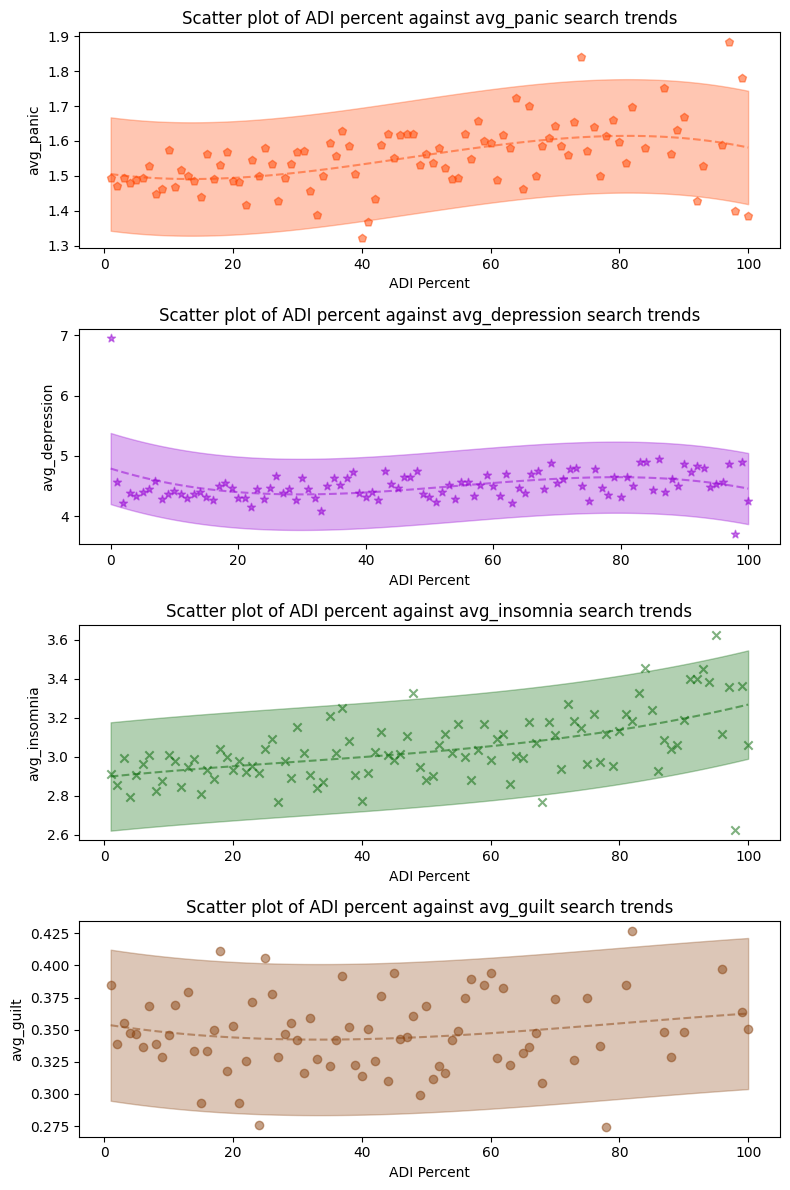

In [ ]:
query = """
WITH
  q AS (
  WITH
    t AS (
    SELECT
      fips_code,
      AVG(search_trends_panic_attack) AS panic,
      AVG(search_trends_depression) AS depression,
      AVG(search_trends_insomnia) AS insomnia,
      AVG(search_trends_guilt) AS guilt
    FROM
      `cs145-project-sandbox.proj2_exploration.us_searches`
    GROUP BY
      fips_code)
  SELECT
    t.fips_code,
    t.panic,
    t.depression,
    t.insomnia,
    t.guilt,
    p.area_deprivation_index_percent
  FROM
    t
  JOIN
    cs145-project-sandbox.proj2_exploration.fipscode_adi AS p
  ON
    t.fips_code = p.county_fips_code)
SELECT
  q.area_deprivation_index_percent,
  AVG(q.panic) as avg_panic,
  AVG(q.depression) as avg_depression,
  AVG(q.insomnia) as avg_insomnia,
  AVG(q.guilt) as avg_guilt
FROM
  q
GROUP BY
  area_deprivation_index_percent
"""
dfmain = pd.io.gbq.read_gbq(query, project_id=project_id)
fig, axs = plt.subplots(4, 1, figsize=(8, 12))
mental_health_search_terms = ['avg_panic',	'avg_depression',	'avg_insomnia',	'avg_guilt']

colors = ['orangered', 'darkviolet', 'darkgreen', 'saddlebrown']
markers = ['p', '*', 'x', 'o']
for i, mental_health_search_term in enumerate(mental_health_search_terms):
    df = dfmain[['area_deprivation_index_percent', mental_health_search_term]].dropna()

    degree = 3
    p = np.polyfit(df['area_deprivation_index_percent'], df[mental_health_search_term], degree)
    p_func = np.poly1d(p)

    x_values = np.linspace(df['area_deprivation_index_percent'].min(), df['area_deprivation_index_percent'].max(), 100)
    y_values = p_func(x_values)

    # Calculate confidence intervals
    y_pred = np.polyval(p, df['area_deprivation_index_percent'])
    residuals = df[mental_health_search_term] - y_pred
    std_err = np.std(residuals)
    conf = 1.96 * std_err  # 95% confidence interval

    axs[i].scatter(df['area_deprivation_index_percent'], df[mental_health_search_term], color=colors[i], marker=markers[i], alpha=0.5, label=mental_health_search_term)

    # X = df['area_deprivation_index_percent'].values.reshape(-1, 1)
    # y = df[mental_health_search_term].values
    # model = LinearRegression().fit(X, y)
    # y_pred = model.predict(X)
    # axs[i].plot(df['area_deprivation_index_percent'], y_pred, color='red', alpha =0.5 linestyle='--', label=f'Best fit line for ADI-{mental_health_search_term}')



    axs[i].plot(x_values, y_values, color=colors[i], label=f'3rd Deg fit to {mental_health_search_term}', alpha=0.5, linestyle='--')
    axs[i].fill_between(x_values, y_values - conf, y_values + conf, color=colors[i], alpha=0.3, label=f'ADI-{mental_health_search_term} Confidence Band')

    axs[i].set_xlabel('ADI Percent')
    axs[i].set_ylabel(mental_health_search_term)
    axs[i].set_title(f'Scatter plot of ADI percent against {mental_health_search_term} search trends')
    # axs[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
mental_health_search_terms = ['avg_panic',	'avg_depression',	'avg_insomnia',	'avg_guilt']


for i, mental_health_search_term in enumerate(mental_health_search_terms):
    df = dfmain[['area_deprivation_index_percent', mental_health_search_term]].dropna()

    spearman_corr, p_value = spearmanr(df['area_deprivation_index_percent'], df[mental_health_search_term])
    print(f"Spearman's correlation coefficient between area_deprivation_index_percent and {mental_health_search_term}:", spearman_corr)
    print("with p value : ", p_value)
    print()

Spearman's correlation coefficient between area_deprivation_index_percent and avg_panic: 0.49070548712206047
with p value :  5.141773239974259e-07

Spearman's correlation coefficient between area_deprivation_index_percent and avg_depression: 0.3681770529994175
with p value :  0.000151840007263193

Spearman's correlation coefficient between area_deprivation_index_percent and avg_insomnia: 0.5748334833483347
with p value :  3.991778401665593e-10

Spearman's correlation coefficient between area_deprivation_index_percent and avg_guilt: 0.05928282244071717
with p value :  0.6085482733747005



**We see some correlation between deprivation and search trends for ``insomnia`` and ``panic attack`` symptoms**, and not so much for ``guilt`` or ``depression``. We hypothesize that this could possibly be due to guilt or depression not being as significantly influenced by COVID-19 as insomnia or panic. For instance, we might imagine someone from a less fortunate background panicking over potential layoffs, or having insomnia over the stress of job finding. However, it would be more of a stretch to claim that people less wealthy would specifically be impacted by depression or guilt any more or less than those more wealthy.

Furthermore, we are unable to find pre-COVID-19 search trends, so we can't say for certain that it is COVID-19 and its socioeconomic ramifications that affected mental health of poorer populations more. The trends shown in the plots above could have existed before the pandemic had even hit. But the above does suggest that poorer regions faced more mental health challenges, possibly due to worrying about impacts of COVID-19 on livelihood.

### 3.7 Disparities in Polled vs Actual Vaccination Rates and County Policies

Another interesting facet to explore is how well people follow through on their intention to get vaccinatedl. We have polled vaccination intention data from early 2021, and actual vaccination rates in 2023. Can we look into changes in vaccine sentiments in counties?

Let's plot the actual vaccination rates against polled non-hesitant population for each county.

In [ ]:
query = """
WITH
  q AS (
  SELECT
    AVG(final_zip_pred) AS avg_hesitancy,
    county_name
  FROM
    `cs145-project-sandbox.proj2_exploration.vaccine_hesitancy_poll_county`
  GROUP BY
    county_name ),
  t AS (
  SELECT
    recip_county,
    administered_dose1_pop_pct
  FROM
    `cs145-project-sandbox.proj2_exploration.us_county_vaccinations_test`
  WHERE
    recip_county != 'Unknown County'
    AND administered_dose1_pop_pct IS NOT NULL )
SELECT
  recip_county,
  q.avg_hesitancy * 100 as pct_hesitant,
  100-(q.avg_hesitancy * 100) as pct_non_hesitant,
   cast(administered_dose1_pop_pct as float64) as pct_received_first_dose,
  (100-(q.avg_hesitancy * 100)) - cast(administered_dose1_pop_pct as float64) as pct_not_hesitant_but_no_vaccine
FROM
  t
JOIN
  q
ON
  t.recip_county = q.county_name
"""

df = pd.io.gbq.read_gbq(query, project_id=project_id)

In [ ]:
fig = px.scatter(df, x='pct_non_hesitant', y='pct_received_first_dose', text='recip_county', title='Pct of county polled as non-hesitant vs pct who got first dose',
                 labels={'pct_non_hesitant': 'pct_non_hesitant', 'pct_received_first_dose': 'pct_received_first_dose'})

# Update layout to display the name when hovering over each point
fig.update_traces(hoverinfo='text', mode='markers')


(hover over each point on the above plot to see county name, actual and polled vaccination rates)

Some of the counties have higher actual percentage vaccinated than polled non-hesitant, but for most counties, the portion of polled non-hesitant is larger than actual vaccination rates. We can take a closer look at this engineered feature.



Let's bring in county policy dataset, and compare how housing assistance, utility assistance and information policies affect this disparity.

Note that there aren't a ton of data in this dataset - about 170 rows. We have to do some preprocessing to categorize data values for ``utility_support_c``, `housing_support_c``, and ``public_info_campaigns_c``. Recall that
1. ``utility_support_c`` and ``housing_support_c`` are categorized as ``0`` or ``1`` for absence and presence of assistance, or ``9`` for unknown.
2. COVID education efforts were categorized as ``0``, ``1``, ``2``, or ``9`` for no information, some information, comprehensive information or unknown respectively.

Counties in this dataset are not representative, and are selected from small number of states. Despite that, let's see whether housing, utility and public info policies affected difference between whether residents were hesitant in accepting a vaccine (polled in 2020) and whether they eventually got vaccinated (in 2022). These policy surveys were done around Jan 2021.

We first run a (rather complicated) SQL query to preprocess the data.

In [ ]:

query = """
WITH
  T AS (
  WITH
    R AS (
    WITH
      D AS (
      WITH
        q AS (
        SELECT
          AVG(final_zip_pred) AS avg_hesitancy,
          county_name,
        FROM
          `cs145-project-sandbox.proj2_exploration.vaccine_hesitancy_poll_county`
        GROUP BY
          county_name ),
        t AS (
        SELECT
          recip_county,
          administered_dose1_pop_pct
        FROM
          `cs145-project-sandbox.proj2_exploration.us_county_vaccinations_test`
        WHERE
          recip_county != 'Unknown County'
          AND administered_dose1_pop_pct IS NOT NULL )
      SELECT
        recip_county,
        q.avg_hesitancy * 100 AS pct_hesitant,
        100-(q.avg_hesitancy * 100) AS pct_non_hesitant,
        CAST(administered_dose1_pop_pct AS float64) AS pct_received_first_dose,
        (100-(q.avg_hesitancy * 100)) - CAST(administered_dose1_pop_pct AS float64) AS pct_not_hesitant_but_no_vaccine
      FROM
        t
      JOIN
        q
      ON
        t.recip_county = q.county_name),
      fips_name AS (
      SELECT
        (lsad_name) AS county,
        (county_fips_code) AS fipscode
      FROM
        `bigquery-public-data.geo_us_boundaries.counties`)
    SELECT
      CAST(fipscode AS int64) AS fipscode,
      recip_county,
      pct_non_hesitant,
      D.pct_received_first_dose,
      D.pct_not_hesitant_but_no_vaccine
    FROM
      fips_name
    JOIN
      D
    ON
      fips_name.county = D.recip_county),
    L AS (
    SELECT
      CAST(fips AS int64) AS fips,
      CAST(LEFT(housing_support_c, 1) AS int64) AS housing,
      CAST(LEFT(utility_support_c, 1) AS int64) AS utility,
      CAST(LEFT (public_info_campaigns_c, 1) AS int64) AS info
    FROM
      `cs145-project-sandbox.proj2_exploration.county_policy_response` )
  SELECT
    fips,
    housing,
    utility,
    info,
    AVG(pct_non_hesitant) AS pct_non_hesitant,
    AVG(pct_received_first_dose) AS pct_received_first_dose,
    AVG(pct_not_hesitant_but_no_vaccine) AS pct_not_hesitant_but_no_vaccine
  FROM
    R
  JOIN
    L
  ON
    R.fipscode = L.fips
  GROUP BY
    fips,
    housing,
    utility,
    info )
SELECT
  fips,
  housing,
  utility,
  info,
  pct_non_hesitant,
  pct_received_first_dose,
  pct_not_hesitant_but_no_vaccine,
  area_deprivation_index_percent
FROM
  T
JOIN
  cs145-project-sandbox.proj2_exploration.fipscode_adi AS adi
ON
  T.fips = CAST(adi.county_fips_code AS int64)

"""
df = pd.io.gbq.read_gbq(query, project_id=project_id)
df.head()

,fips,housing,utility,info,pct_non_hesitant,pct_received_first_dose,pct_not_hesitant_but_no_vaccine,area_deprivation_index_percent
0,36085,0,0,1,87.655114,64.075000,23.580114,8.0
1,34039,1,0,2,85.956452,60.776471,25.179981,11.0
2,48339,1,9,2,87.065612,63.566667,23.498945,10.0
3,22031,9,9,0,74.749325,49.900000,24.849325,87.0
4,48097,9,9,2,81.923264,46.400000,35.523264,50.0


In [ ]:
df.shape

(171, 8)

Next, we can see some summary statistics for the number of counties that provide specific policies (or don't provide those policies).

In [ ]:
print("Number of rows with housing policy = 0: ", (df['housing'] == 0).sum())
print("Number of rows with housing policy = 1: ", (df['housing'] == 1).sum())

print("Number of rows with utility policy = 0: ", (df['utility'] == 0).sum())
print("Number of rows with utility policy = 1: ", (df['utility'] == 1).sum())

print("Number of rows with info policy = 0: ", (df['info'] == 0).sum())
print("Number of rows with info policy = 1: ", (df['info'] == 1).sum())
print("Number of rows with info policy = 2: ", (df['info'] == 2).sum())

Number of rows with housing policy = 0:  39
Number of rows with housing policy = 1:  59
Number of rows with utility policy = 0:  39
Number of rows with utility policy = 1:  46
Number of rows with info policy = 0:  20
Number of rows with info policy = 1:  30
Number of rows with info policy = 2:  120


Finally, we can link the intention-vaccination disparity to the presence (or absence) of specific county-level policies.

In [ ]:
print("avg difference between polled non-hesitant vs actual first dose received for housing = 0: ",
      df[df['housing'] == 0]['pct_not_hesitant_but_no_vaccine'].mean())
print("avg difference between polled non-hesitant vs actual first dose received for housing = 1: ",
      df[df['housing'] == 1]['pct_not_hesitant_but_no_vaccine'].mean())
print('-------------')
print("avg difference between polled non-hesitant vs actual first dose received for utility = 0: ",
      df[df['utility'] == 0]['pct_not_hesitant_but_no_vaccine'].mean())
print("avg difference between polled non-hesitant vs actual first dose received for utility = 1: ",
      df[df['utility'] == 1]['pct_not_hesitant_but_no_vaccine'].mean())
print('-------------')
print("avg difference between polled non-hesitant vs actual first dose received for info = 0: ",
      df[df['info'] == 0]['pct_not_hesitant_but_no_vaccine'].mean())
print("avg difference between polled non-hesitant vs actual first dose received for info = 1: ",
      df[df['info'] == 1]['pct_not_hesitant_but_no_vaccine'].mean())
print("avg difference between polled non-hesitant vs actual first dose received for info = 2: ",
      df[df['info'] == 2]['pct_not_hesitant_but_no_vaccine'].mean())

avg difference between polled non-hesitant vs actual first dose received for housing = 0:  20.638138866014238
avg difference between polled non-hesitant vs actual first dose received for housing = 1:  13.87812259361283
-------------
avg difference between polled non-hesitant vs actual first dose received for utility = 0:  16.140834122846744
avg difference between polled non-hesitant vs actual first dose received for utility = 1:  15.852918763870525
-------------
avg difference between polled non-hesitant vs actual first dose received for info = 0:  27.795916153593264
avg difference between polled non-hesitant vs actual first dose received for info = 1:  24.17818000094258
avg difference between polled non-hesitant vs actual first dose received for info = 2:  17.17271840939642


It appears that the presence of a housing policy and education campaigns lessen the intention-vaccination disparity. We can gain some more intuition for this through some diagrams.

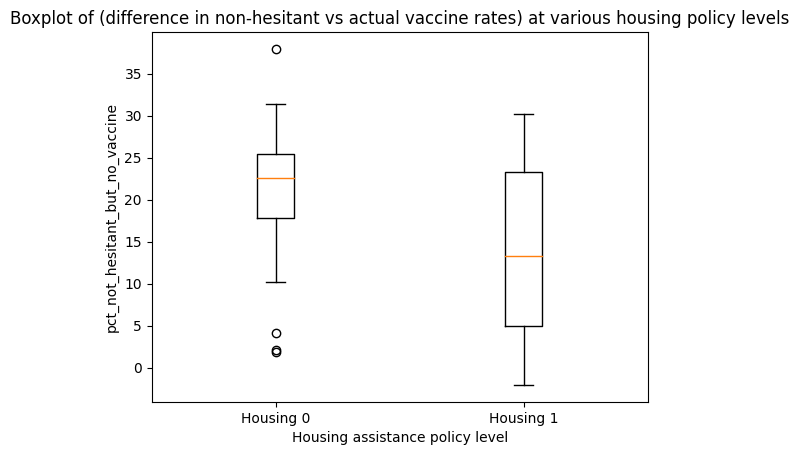

In [ ]:
subset_0 = df[df['housing'] == 0]['pct_not_hesitant_but_no_vaccine']
subset_1 = df[df['housing'] == 1]['pct_not_hesitant_but_no_vaccine']

fig, ax = plt.subplots()

ax.boxplot([subset_0, subset_1], labels=['Housing 0', 'Housing 1'])

ax.set_xlabel('Housing assistance policy level')
ax.set_ylabel('pct_not_hesitant_but_no_vaccine')
ax.set_title('Boxplot of (difference in non-hesitant vs actual vaccine rates) at various housing policy levels')

plt.show()

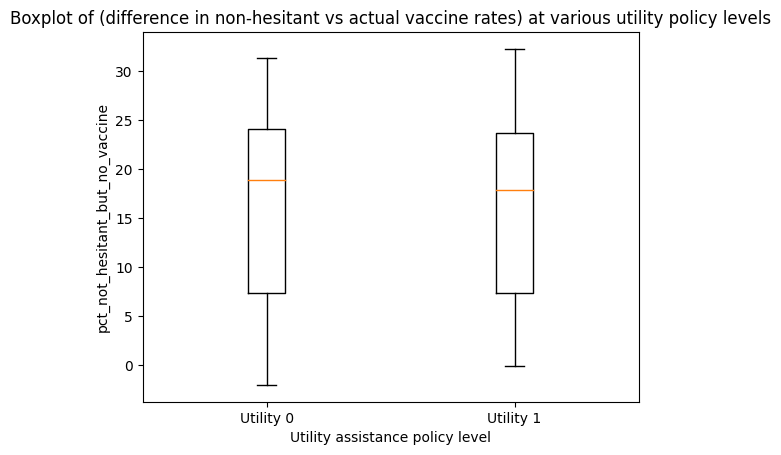

In [ ]:
subset_0 = df[df['utility'] == 0]['pct_not_hesitant_but_no_vaccine']
subset_1 = df[df['utility'] == 1]['pct_not_hesitant_but_no_vaccine']

fig, ax = plt.subplots()

ax.boxplot([subset_0, subset_1], labels=['Utility 0', 'Utility 1'])

ax.set_xlabel('Utility assistance policy level')
ax.set_ylabel('pct_not_hesitant_but_no_vaccine')
ax.set_title('Boxplot of (difference in non-hesitant vs actual vaccine rates) at various utility policy levels')

plt.show()

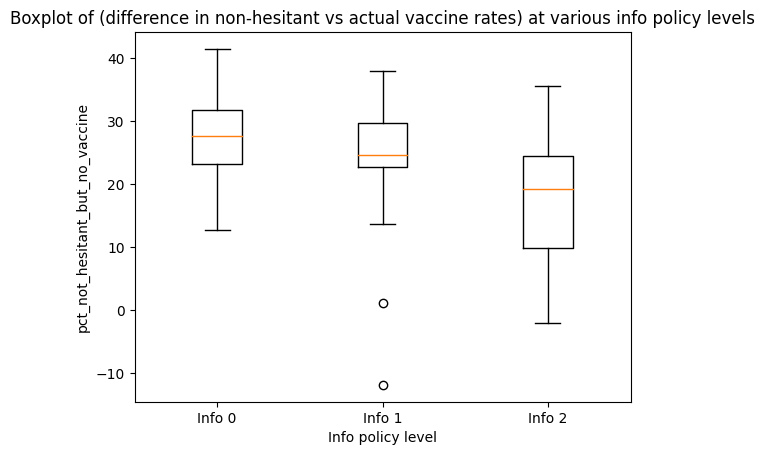

In [ ]:
subset_0 = df[df['info'] == 0]['pct_not_hesitant_but_no_vaccine']
subset_1 = df[df['info'] == 1]['pct_not_hesitant_but_no_vaccine']
subset_2 = df[df['info'] == 2]['pct_not_hesitant_but_no_vaccine']

fig, ax = plt.subplots()

ax.boxplot([subset_0, subset_1, subset_2], labels=['Info 0', 'Info 1', 'Info 2'])

# Set labels and title
ax.set_xlabel('Info policy level')
ax.set_ylabel('pct_not_hesitant_but_no_vaccine')
ax.set_title('Boxplot of (difference in non-hesitant vs actual vaccine rates) at various info policy levels')

# Show the plot
plt.show()

In [ ]:
print("ADI for housing = 0: ",
      df[df['housing'] == 0]['area_deprivation_index_percent'].mean())
print("ADI for housing = 1: ",
      df[df['housing'] == 1]['area_deprivation_index_percent'].mean())

print("ADI for utility = 0: ",
      df[df['utility'] == 0]['area_deprivation_index_percent'].mean())
print("ADI for utility = 1: ",
      df[df['utility'] == 1]['area_deprivation_index_percent'].mean())

print("ADI for info = 0: ",
      df[df['info'] == 0]['area_deprivation_index_percent'].mean())
print("ADI for info = 1: ",
      df[df['info'] == 1]['area_deprivation_index_percent'].mean())
print("ADI for info = 2: ",
      df[df['info'] == 2]['area_deprivation_index_percent'].mean())

ADI for housing = 0:  28.82051282051282
ADI for housing = 1:  31.576271186440678
ADI for utility = 0:  28.102564102564102
ADI for utility = 1:  35.02173913043478
ADI for info = 0:  67.5
ADI for info = 1:  50.13333333333333
ADI for info = 2:  32.05833333333333


**Counties with housing assistance and information policies were found to have lower disparities between polled willingness and actual vaccination rates.** (Recall that lower disparities are generally more desireable, since it represents percent who are not hesitant minus percent who actually received first vaccination shots).

This effect is clearest for information campaigns, suggesting that strong outreach efforts are able to convert people from passivity (being merely willing to take the vaccine) into action (actually taking the vaccine). This suggests that public information is critical in convincing people to follow through with their intentions, and translate this into concrete action.

As for housing assistance, one possible explanation for this trend could be this -- people who become unhoused during the pandemic (due to the lack of housing assistance) simply have more pressing concerns than getting vaccinated, and so don't end up following through. This explanation relies on the assumption that **people have limited attention or capacity to deal with the problems they face**. Given that the problems from becoming unhoused are more significant than the problems from contracting COVID-19, it would make sense that people would and should focus on finding permanent housing first. This line of reasoning further explains why there is no trend for utility assistance policies -- the problems from having to pay utility bills (gas, electric, phone) are less significant than the problems from contracting COVID-19, therefore leading people to get vaccinated at the same rate regardless.

Another point that should be noted is that this analysis relies on a very small underlying dataset -- only about 170 counties. While the counties are diverse, the extremely small sample size relative to the over 30,000 counties in the US makes this analysis highly tentative. The trends documented here could very well fail to generalize to other US counties.

----
### 3.8 Summary of Exploration
----

This has been a very long exploration, so at this stage we find it apt to provide a cheat sheet summary of what we've done so far.

Our main takeaways from each of the exploration sections are listed below.
1. There exists a generally **negative** correlation between ADI and three measures of vaccination rate (first dose, primary series, and booster dose), although some outliers exist.
2. There exists a generally **negative** correlation between ADI and number of vaccination sites. However, there is no clear correlation between ADI and travel time to the nearest vaccination site
3. There exists a generally **negative** correlation between ADI and three measures of vaccination search interest: general interest, intention to vaccinate, and safety concerns.
4. There exists a generally **positive** correlation between ADI and vaccine hesitancy, although the counties with the highest ADI display lower hesitancy than median ADI counties.
5. There exists a generally **negative** correlation between ADI and the extent of negative sentiments expressed through tweets. This can be explained by our rich-people-whine-more-while-tweeting hypothesis, as explained above in section 3.5.
6. There exists a generally **positive** correlation between ADI and searches for specific mental health symptoms (e.g. ``panic``), although this correlation disappears for other symptoms (e.g. ``depression``). It is unclear whether this correlation is the result of COVID-19, or had also existed prior to the pandemic.
7. The exists a generally **positive** correlation between the presence of specific policies (housing and information), and vaccination follow-through. However, this is based on only a very small sample of counties, and may not fully generalize to all US counties.





### 3.9 Further Explorations

- number of vaccination sites per 10k population
- meal gap index (2021 data) against ADI of counties

In [ ]:
query = """
with t as (SELECT format("%05d", FIPS) as fipscode, Year, food_insecurity_rate FROM `cs145-project-sandbox.proj2_exploration.mealgap` where Year = 2021),
q as (SELECT
  fips,
  administered_dose1_pop_pct,
  series_complete_pop_pct,
  booster_doses_vax_pct
FROM
  `cs145-project-sandbox.proj2_exploration.us_county_vaccinations_test`
WHERE
  fips IS NOT NULL
  AND administered_dose1_pop_pct IS NOT NULL
  AND series_complete_pop_pct IS NOT NULL
  AND booster_doses_vax_pct IS NOT NULL
  AND fips != 'UNK')
  select * from
  t join q on
  t.fipscode = q.fips
"""
df = pd.io.gbq.read_gbq(query, project_id=project_id)

print('correlations for all ', len(df), ' counties')

spearman_corr, p_value = spearmanr(df['food_insecurity_rate'], df['administered_dose1_pop_pct'], alternative='less')
print("Spearman's correlation coefficient between food insecurity and administered_dose1_pop_pct:", spearman_corr)
print("with p value : ", p_value)
print()
spearman_corr, p_value = spearmanr(df['food_insecurity_rate'], df['series_complete_pop_pct'], alternative='less')
print("Spearman's correlation coefficient between food insecurity and series_complete_pop_pct:", spearman_corr)
print("with p value : ", p_value)
print()
spearman_corr, p_value = spearmanr(df['food_insecurity_rate'], df['booster_doses_vax_pct'], alternative='less')
print("Spearman's correlation coefficient between food insecurity and booster_doses_vax_pct:", spearman_corr)
print("with p value : ", p_value)


correlations for all  3057  counties
Spearman's correlation coefficient between food insecurity and administered_dose1_pop_pct: -0.2620934074999111
with p value :  1.688087592240132e-49

Spearman's correlation coefficient between food insecurity and series_complete_pop_pct: -0.3195018297772596
with p value :  8.358128198928321e-74

Spearman's correlation coefficient between food insecurity and booster_doses_vax_pct: -0.452002819810057
with p value :  3.907154391268729e-154


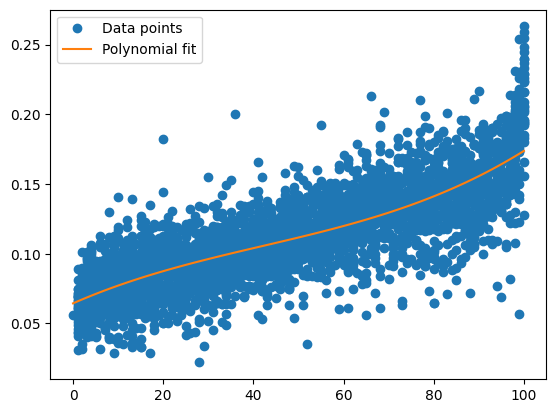

Polynomial coefficients: [ 1.24490507e-07 -1.56952571e-05  1.41815435e-03  6.44126140e-02]


In [ ]:
x = df['area_deprivation_index_percent'].to_numpy()
y = df['food_insecurity_rate'].to_numpy()

# Degree of the polynomial (adjust as needed)
degree = 3
# Fit the polynomial using numpy.polyfit
coefficients = np.polyfit(x, y, degree)

# Create the polynomial function
polynomial = np.poly1d(coefficients)

# Generate x values for plotting the curve
x_plot = np.linspace(x.min(), x.max(), 100)
y_plot = polynomial(x_plot)

# Plot the data and the polynomial curve
plt.plot(x, y, 'o', label='Data points')
plt.plot(x_plot, y_plot, label='Polynomial fit')
plt.legend()
plt.show()

# Get coefficients for reference
print(f"Polynomial coefficients: {coefficients}")

Corr between food insecurity and panic:  0.690615835777126
p value:  6.07847174349768e-06


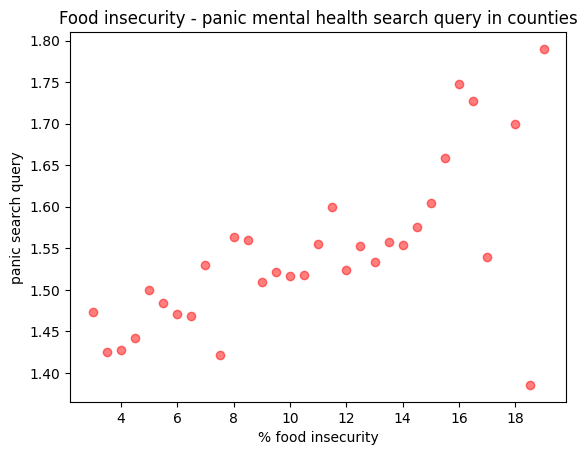

In [ ]:
query = """
with s as (with t as (SELECT format("%05d", FIPS) as fipscode, Year, food_insecurity_rate FROM `cs145-project-sandbox.proj2_exploration.mealgap` where Year = 2021),
r AS (
    SELECT
      fips_code,
      AVG(search_trends_panic_attack) AS panic,
      AVG(search_trends_depression) AS depression,
      AVG(search_trends_insomnia) AS insomnia,
      AVG(search_trends_guilt) AS guilt
    FROM
      `cs145-project-sandbox.proj2_exploration.us_searches`
    GROUP BY
      fips_code)
select round (t.food_insecurity_rate*200,0)/2 as food_insecurity_rate, r.panic
from t
join r
on t.fipscode = r.fips_code
where (panic is not null))
select food_insecurity_rate, avg(panic) as panic
from s
group by s.food_insecurity_rate
"""
df = pd.io.gbq.read_gbq(query, project_id=project_id)

plt.scatter(df['food_insecurity_rate'], df['panic'], color='red', alpha=0.5)
plt.title('Food insecurity - panic mental health search query in counties')
plt.xlabel('% food insecurity')
plt.ylabel('panic search query')

spearman_corr, p_value = spearmanr(df['food_insecurity_rate'], df['panic'], alternative='greater')

print("Corr between food insecurity and panic: ", spearman_corr)
print("p value: ", p_value)

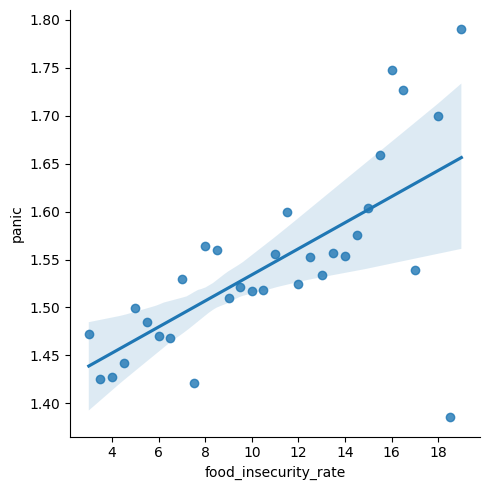

In [ ]:
sns.lmplot(x='food_insecurity_rate', y='panic', data=df, fit_reg=True, ci=95, n_boot=100)

Corr between food insecurity and insomnia:  0.9065637065637066
p value:  1.3647030029224454e-14


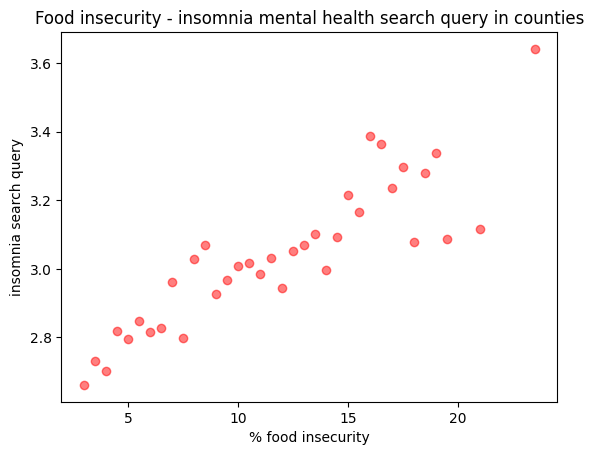

In [ ]:
query = """
with s as (with t as (SELECT format("%05d", FIPS) as fipscode, Year, food_insecurity_rate FROM `cs145-project-sandbox.proj2_exploration.mealgap` where Year = 2021),
r AS (
    SELECT
      fips_code,
      AVG(search_trends_panic_attack) AS panic,
      AVG(search_trends_depression) AS depression,
      AVG(search_trends_insomnia) AS insomnia,
      AVG(search_trends_guilt) AS guilt
    FROM
      `cs145-project-sandbox.proj2_exploration.us_searches`
    GROUP BY
      fips_code)
select round (t.food_insecurity_rate*200,0)/2 as food_insecurity_rate, r.insomnia
from t
join r
on t.fipscode = r.fips_code
where (insomnia is not null))
select food_insecurity_rate, avg(insomnia) as insomnia
from s
group by s.food_insecurity_rate
"""
df = pd.io.gbq.read_gbq(query, project_id=project_id)

plt.scatter(df['food_insecurity_rate'], df['insomnia'], color='red', alpha=0.5)
plt.title('Food insecurity - insomnia mental health search query in counties')
plt.xlabel('% food insecurity')
plt.ylabel('insomnia search query')

spearman_corr, p_value = spearmanr(df['food_insecurity_rate'], df['insomnia'], alternative='greater')

print("Corr between food insecurity and insomnia: ", spearman_corr)
print("p value: ", p_value)

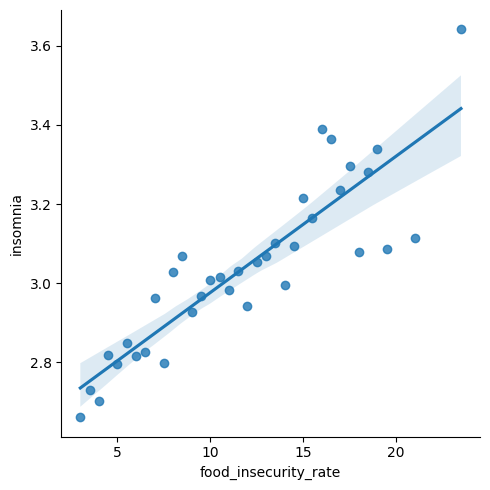

In [ ]:
sns.lmplot(x='food_insecurity_rate', y='insomnia', data=df, fit_reg=True, ci=95, n_boot=100)


## 4 Query vs ML Solution Cost Analysis

Let's look at predicting first dose vaccination rates for COVID-19 using some of the more promising features we've seen thus far. With reference to the cheat sheet right above (in the Summary of Exploration subsection), we intend to use the following features:

* ADI score
* Polled hesitancy
* Panic, Insomnia search query trends
* Vaccination, intention, safety concern search query trends
* Number of vaccination centers per square kilometer (1 square kilometer is approximately 0.386 square miles)
* Number of vaccination centers per person

ADI score and polled hesitancy can be taken directly from their respective datasets. For the five search query trends, however, we note that they vary not only over space (i.e. across counties) but also over time (i.e. over days or weeks). We aggregate the across-time readings by taking the average of these search trends over the entire tracking period (from the start of COVID until now). We can think of these engineered features as representing the average level of negative sentiment since the pandemic began.

Similarly, for the number of vaccination centers, we use the ``bigquery-public-data.covid19_vaccination_access.facility_boundary_us_drive`` table (which is essentially a list of all vaccination sites; more details in section 2.7 above), and then perform a SQL query to count the number of centers per FIPS Code, before dividing by land area and county population respectively. We can think of these engineered features as representing the geographic density of vaccination centers, as well as the "human" density of vaccination centers (i.e. how many people, on average, are served by one vaccination center),





In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE
  proj2_exploration.covidVacFeatureLabel AS (
  WITH features AS
  (
      WITH some_features AS
      (
        WITH search_adi AS
        (
          WITH r AS
          (
            SELECT
              fips_code,
              AVG(search_trends_panic_attack) AS panic,
              AVG(search_trends_depression) AS depression,
              AVG(search_trends_insomnia) AS insomnia,
              AVG(search_trends_guilt) AS guilt
            FROM
              `cs145-project-sandbox.proj2_exploration.us_searches`
            GROUP BY
              fips_code
          )
          SELECT
            r.fips_code,
            r.panic,
            r.depression,
            r.insomnia,
            r.guilt,
            q.area_deprivation_index_percent
          FROM r
          JOIN cs145-project-sandbox.proj2_exploration.fipscode_adi AS q
          ON r.fips_code = q.county_fips_code
        ),
        fipscode_hesitancy AS
        (
          WITH t AS
          (
            SELECT
              (x.lsad_name) AS county,
              (x.county_fips_code) AS fipscode,
              (x.area_land_meters / 1000000) AS land_area,
              y.total_pop AS pop
            FROM `bigquery-public-data.geo_us_boundaries.counties` as x
            JOIN `bigquery-public-data.census_bureau_acs.county_2020_5yr` as y
            ON x.county_fips_code = y.geo_id
          ),
          p AS
          (
            SELECT
              AVG(final_zip_pred) AS avg_hesitancy,
              county_name
            FROM `cs145-project-sandbox.proj2_exploration.vaccine_hesitancy_poll_county`
            GROUP BY county_name
          )
          SELECT
            p.avg_hesitancy,
            county_name,
            fipscode,
            t.land_area,
            t.pop
          FROM p
          JOIN t
          ON p.county_name = t.county
        ),
        search_fipscode AS
        (
          SELECT
            AVG(insights.sni_covid19_vaccination) AS avg_vaccination_score,
            AVG(insights.sni_vaccination_intent) AS avg_intention_score,
            AVG(insights.sni_safety_side_effects) AS avg_safety_concern_score,
            sub_region_2_code AS fipscode
          FROM `proj2_exploration.us_covid_search_insights` AS insights
          GROUP BY sub_region_2_code )
        SELECT
          fips_code,
          panic,
          insomnia,
          area_deprivation_index_percent,
          avg_hesitancy,
          avg_vaccination_score,
          avg_intention_score,
          avg_safety_concern_score,
          land_area,
          pop
        FROM search_adi
        JOIN fipscode_hesitancy
        ON search_adi.fips_code = fipscode_hesitancy.fipscode
        JOIN search_fipscode
        ON search_adi.fips_code = search_fipscode.fipscode
      ),
      times AS
      (
        WITH t AS
        (
          SELECT
            facility_sub_region_2_code,
            COUNT(DISTINCT facility_place_id) AS unique_place_count
          FROM `bigquery-public-data.covid19_vaccination_access.facility_boundary_us_drive`
          GROUP BY facility_sub_region_2_code
        )
        SELECT
          t.facility_sub_region_2_code,
          t.unique_place_count,
          q.area_deprivation_index_percent
        FROM t
        JOIN `cs145-project-sandbox.proj2_exploration.fipscode_adi` AS q
        ON t.facility_sub_region_2_code = q.county_fips_code
      )

      SELECT
        fips_code,
        panic,
        insomnia,
        some_features.area_deprivation_index_percent,
        avg_hesitancy,
        avg_vaccination_score,
        avg_intention_score,
        avg_safety_concern_score,
        unique_place_count / land_area AS num_vax_centers_per_sq_km,
        unique_place_count / pop AS num_vax_centers_per_pax
      FROM some_features
      JOIN times
      ON some_features.fips_code = times.facility_sub_region_2_code
    ),
    labels AS
    (
    SELECT
      fips,
      administered_dose1_pop_pct
    FROM
      `cs145-project-sandbox.proj2_exploration.us_county_vaccinations_test`
    WHERE
      fips IS NOT NULL
      AND administered_dose1_pop_pct IS NOT NULL
      AND fips != 'UNK')
  SELECT
    fips,
    panic,
    insomnia,
    area_deprivation_index_percent,
    features.avg_hesitancy,
    avg_vaccination_score,
    avg_intention_score,
    avg_safety_concern_score,
    num_vax_centers_per_sq_km,
    num_vax_centers_per_pax,
    administered_dose1_pop_pct
  FROM
    features
  JOIN
    labels
  ON
    features.fips_code = labels.fips)


Query is running:   0%|          |

""


Running the (rather monstrous) SQL query above outputs a nicely formatted table, ``covidVacFeatureLabel``, with 2,986 rows that have FIPS code as primary key, 8 feature columns, and ``administered_dose1_pop_pct`` as label column

### 4.1 KNN in SQL Baseline

Let's use K Nearest Neighbours to predict the percent of first COVID-19 vaccine dose, given the features. We'll do this in SQL.

We first create a new table from our features. Next, we calculate the Euclidean distance for all the features to all rows in our data. Note that since we have many null values for mental health queries (panic and insomnia columns) and vaccine search queries (avg_vaccination_score, avg_intention_score, avg_safety_concern_score), we let them be 0 if they are null. We define all these feature euclidean distances as 'distance', and get the top 5 most similar rows. Our estimated label is the average of these 5 rates. (Note we can change the number of nearest neighbours by changing LIMIT)

Let's say we have a county with panic=1.28, insomnia=2.58, ADI=4, hesitancy=0.15, vaccination search score = 16, vaccination intention score = 6, vaccine safety concern score = 4. We want to predict the percentage of this county's population who will receive their first COVID-19 dose (by May 2023).

In [ ]:
%%bigquery --project $project_id


WITH NewData AS (
  SELECT
    1.28 AS panic,
    2.58 AS insomnia,
    4 AS area_deprivation_index_percent,
    0.15 AS avg_hesitancy,
    16 AS avg_vaccination_score,
    6 AS avg_intention_score,
    4 AS avg_safety_concern_score,
    0.2 AS num_vax_centers_per_sq_km,
    0.017 AS num_vax_centers_per_pax
)
SELECT
  AVG(CAST(nn.administered_dose1_pop_pct AS FLOAT64)) AS predicted_administered_dose1_pop_pct
FROM (
  SELECT
    p1.*,
    SQRT(POW(COALESCE(p1.panic, 0) - COALESCE(p2.panic, 0), 2) +
         POW(COALESCE(p1.insomnia, 0) - COALESCE(p2.insomnia, 0), 2) +
         POW(p1.area_deprivation_index_percent - p2.area_deprivation_index_percent, 2) +
         POW(p1.avg_hesitancy - p2.avg_hesitancy, 2) +
         POW(COALESCE(p1.avg_vaccination_score, 0) - COALESCE(p2.avg_vaccination_score, 0), 2) +
         POW(COALESCE(p1.avg_intention_score, 0) - COALESCE(p2.avg_intention_score, 0), 2) +
         POW(COALESCE(p1.avg_safety_concern_score, 0) - COALESCE(p2.avg_safety_concern_score, 0), 2)+
         POW((p1.num_vax_centers_per_sq_km - p2.num_vax_centers_per_sq_km), 2) +
         POW((p1.num_vax_centers_per_pax - p2.num_vax_centers_per_pax), 2)) AS distance
  FROM proj2_exploration.covidVacFeatureLabel p1
  CROSS JOIN NewData p2
  WHERE p1.administered_dose1_pop_pct IS NOT NULL
    AND p2.panic IS NOT NULL
    AND p2.insomnia IS NOT NULL
) AS distances
JOIN proj2_exploration.covidVacFeatureLabel nn ON distances.fips = nn.fips
ORDER BY 1
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_administered_dose1_pop_pct
0,61.042338


Let's take a look at the 5 closest counties in our dataset

In [ ]:
%%bigquery --project $project_id


WITH NewData AS (
  SELECT
    1.28 AS panic,
    2.58 AS insomnia,
    4 AS area_deprivation_index_percent,
    0.15 AS avg_hesitancy,
    16 AS avg_vaccination_score,
    6 AS avg_intention_score,
    4 AS avg_safety_concern_score,
    0.2 AS num_vax_centers_per_sq_km,
    0.017 AS num_vax_centers_per_pax
)
SELECT
  nn.*,
  distances.distance
FROM (
  SELECT
    p1.*,
    SQRT(POW(COALESCE(p1.panic, 0) - COALESCE(p2.panic, 0), 2) +
         POW(COALESCE(p1.insomnia, 0) - COALESCE(p2.insomnia, 0), 2) +
         POW(p1.area_deprivation_index_percent - p2.area_deprivation_index_percent, 2) +
         POW(p1.avg_hesitancy - p2.avg_hesitancy, 2) +
         POW(COALESCE(p1.avg_vaccination_score, 0) - COALESCE(p2.avg_vaccination_score, 0), 2) +
         POW(COALESCE(p1.avg_intention_score, 0) - COALESCE(p2.avg_intention_score, 0), 2) +
         POW(COALESCE(p1.avg_safety_concern_score, 0) - COALESCE(p2.avg_safety_concern_score, 0), 2)++
         POW((p1.num_vax_centers_per_sq_km - p2.num_vax_centers_per_sq_km), 2) +
         POW((p1.num_vax_centers_per_pax - p2.num_vax_centers_per_pax), 2)) AS distance
  FROM proj2_exploration.covidVacFeatureLabel p1
  CROSS JOIN NewData p2
  WHERE p1.administered_dose1_pop_pct IS NOT NULL
    AND p2.panic IS NOT NULL
    AND p2.insomnia IS NOT NULL
) AS distances
JOIN proj2_exploration.covidVacFeatureLabel nn
ON distances.fips = nn.fips
ORDER BY distance
LIMIT 5;

Query is running:   0%|          |

Downloading:   0%|          |

,fips,panic,insomnia,area_deprivation_index_percent,avg_hesitancy,avg_vaccination_score,avg_intention_score,avg_safety_concern_score,num_vax_centers_per_sq_km,num_vax_centers_per_pax,administered_dose1_pop_pct,distance
0,46083,NaN,2.603677,3.0,0.157646,16.154135,4.774700,3.611653,0.007357,0.000187,86,2.086227
1,13073,1.836880,3.673431,6.0,0.117667,17.927966,5.524615,4.043276,0.038600,0.000188,63,3.078637
2,55131,1.285623,2.586450,4.0,0.141540,19.435034,6.309505,4.129651,0.019725,0.000162,63.9,3.456152
3,27141,1.485297,2.484337,5.0,0.199965,19.789932,5.864571,3.632587,0.005351,0.000062,52,3.950809
4,18059,1.271885,2.141840,6.0,0.132716,19.597628,5.768296,3.956629,0.017667,0.000183,76.4,4.150226


### 4.2 Linear Regression ML solution

We've seen a KNN baseline, can we do better with linear regression?

Let's first split our data into 70% training, 10% validation and 20% test datasets. Our first thought was to split according to FIPS codes, but we can't do that! Although we're not using this categorical data, it's possible that the FIPS code could affect vaccination rates (the FIPS code for counties in a red state could have different attitudes towards vaccines than the FIPS code for counties in a blue state, for instance).

Instead, let's assign each row a random value and split accordingly.

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE `proj2_exploration.covidVacFeatureLabelSplitting` AS

SELECT *,
    CASE
        WHEN split_field < 0.7 THEN 'training'
        WHEN split_field >= 0.7 and split_field <=0.8 THEN 'evaluation'
        WHEN split_field > 0.8 THEN 'testing'
    END AS subset

FROM (
    SELECT *,
        ROUND(ABS(RAND()),4) AS split_field
    FROM `proj2_exploration.covidVacFeatureLabel`
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id

WITH
  subset_counts AS (
  SELECT
    subset,
    COUNT(*) AS row_count
  FROM
    proj2_exploration.covidVacFeatureLabelSplitting
  GROUP BY
    subset),
  totals AS (
  SELECT
    COUNT(*) AS total_rows
  FROM
    proj2_exploration.covidVacFeatureLabelSplitting )
SELECT
  subset_counts.subset,
  subset_counts.row_count,
  ROUND((subset_counts.row_count / totals.total_rows)*100, 3) AS subset_percent
FROM
  subset_counts
CROSS JOIN
  totals

Query is running:   0%|          |

Downloading:   0%|          |

,subset,row_count,subset_percent
0,testing,495,19.753
1,training,1761,70.271
2,evaluation,250,9.976


Now that we've partitioned the data into training, validation, and test sets, we can proceed to try out different ML approaches. For each approach, we train the ML model on the same training set, and compare their performance against one another using the same validation set. We leave out the test set entirely, so as to avoid "leaking" information about the test set to our model.

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL
  proj2_exploration.covidVacModel OPTIONS (model_type='linear_reg') AS
SELECT
  COALESCE(panic, 0) AS panic,
  COALESCE(insomnia, 0) AS insomnia,
  area_deprivation_index_percent,
  avg_hesitancy,
  COALESCE(avg_vaccination_score, 0) AS avg_vaccination_score,
  COALESCE(avg_intention_score, 0) AS avg_intention_score,
  COALESCE(avg_safety_concern_score, 0) AS avg_safety_concern_score,
  num_vax_centers_per_sq_km,
  num_vax_centers_per_pax,
  CAST(administered_dose1_pop_pct AS float64) AS label
FROM
  proj2_exploration.covidVacFeatureLabelSplitting
WHERE
  subset='training'

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL proj2_exploration.covidVacModel, (
SELECT
  COALESCE(panic, 0) AS panic,
  COALESCE(insomnia, 0) AS insomnia,
  area_deprivation_index_percent,
  avg_hesitancy,
  COALESCE(avg_vaccination_score, 0) AS avg_vaccination_score,
  COALESCE(avg_intention_score, 0) AS avg_intention_score,
  COALESCE(avg_safety_concern_score, 0) AS avg_safety_concern_score,
  num_vax_centers_per_sq_km,
  num_vax_centers_per_pax,
  CAST(administered_dose1_pop_pct AS float64) AS label
FROM
   proj2_exploration.covidVacFeatureLabelSplitting
where subset='evaluation'))

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,8.444433,122.449099,0.034923,6.568129,0.408298,0.414138


OK, we've a trained model, and it using linear regression with our features, we have mean absolute error of 8.44 on the validation set.

The "absolute error" in mean absolute error is simply how far away our predicted vaccination rate is from the actual vaccination rate for any given datapoint. The "mean absolute error", therefore, is the average of the absolute errors for each datapoint in our test set. In the context of this set-up, we can think of mean absolute error as this: suppose the ML model has a mean absolute error of $\epsilon$, and the mode predicts a vaccination rate of $x$ percent for some county. On average, that county's true vaccination rate is $\epsilon$ percent off from what the model predicted.

The main reason why we chose to use mean absolute error as our main metric for comparison is because it is extremely intuitive. This is especially when compared to, say, mean squared error, root mean squared error, or r-squared, which might hold more statistical significance or usefulness, but would be difficult to have a good "gut feel" for.

But how good is our ML model, exactly? Let's compare with a very dumb baseline ML model: just taking the average of all ``administered_dose1_pop_pct``, and predicting that as the vaccination rate for every county we see.

In [ ]:
%%bigquery --project $project_id

# WITH
#   AvgPrediction AS (
#   SELECT
#     AVG(CAST(administered_dose1_pop_pct AS float64)) AS avg_predicted_dose1_pop_pct
#   FROM
#     proj2_exploration.covidVacFeatureLabelSplitting )
# SELECT
#   AVG(ABS(CAST(administered_dose1_pop_pct AS float64) - ap.avg_predicted_dose1_pop_pct)) AS absolute_mean_error
# FROM
#   proj2_exploration.covidVacFeatureLabelSplitting,
#   AvgPrediction ap

  with AvgPrediction as (SELECT
   AVG(CAST(administered_dose1_pop_pct AS float64)) AS avg_predicted_dose1_pop_pct
FROM
  `cs145-project-sandbox.proj2_exploration.covidVacFeatureLabelSplitting`
WHERE
  subset = 'training')

  SELECT
  AVG(ABS(CAST(administered_dose1_pop_pct AS float64) - ap.avg_predicted_dose1_pop_pct)) AS absolute_mean_error
FROM
  proj2_exploration.covidVacFeatureLabelSplitting as t,
  AvgPrediction ap
  where t.subset='testing'

Query is running:   0%|          |

Downloading:   0%|          |

,absolute_mean_error
0,11.328691


We see that this ML baseline yields a higher mean absolute error of 11.32. It does seem that our simple linear regression model is performing better than this baseline, although there still exists room for improvement.

Let's try to do better. Instead of replacing missing values of panic, insomnia, and search trend scores with 0, what happens if we replace them with average values?

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL
  proj2_exploration.covidVacModelReengineered OPTIONS (model_type='linear_reg') AS
(WITH
  Averages AS (
  SELECT
    AVG(panic) AS avg_panic,
    AVG(insomnia) AS avg_insomnia,
    AVG(avg_vaccination_score) AS avg_vaccination_score,
    AVG(avg_intention_score) AS avg_intention_score,
    AVG(avg_safety_concern_score) AS avg_safety_concern_score
  FROM
    proj2_exploration.covidVacFeatureLabelSplitting
  WHERE
    subset = 'training'
    AND panic IS NOT NULL
    AND insomnia IS NOT NULL
    AND avg_vaccination_score IS NOT NULL
    AND avg_intention_score IS NOT NULL
    AND avg_safety_concern_score IS NOT NULL
)

SELECT
  COALESCE(cvfls.panic, avg_panic) AS panic,
  COALESCE(cvfls.insomnia, avg_insomnia) AS insomnia,
  cvfls.area_deprivation_index_percent,
  cvfls.avg_hesitancy,
  COALESCE(cvfls.avg_vaccination_score, avgs.avg_vaccination_score) AS avg_vaccination_score,
  COALESCE(cvfls.avg_intention_score, avgs.avg_intention_score) AS avg_intention_score,
  COALESCE(cvfls.avg_safety_concern_score, avgs.avg_safety_concern_score) AS avg_safety_concern_score,
  cvfls.num_vax_centers_per_sq_km,
  cvfls.num_vax_centers_per_pax,
  CAST(cvfls.administered_dose1_pop_pct AS float64) AS label
FROM
  proj2_exploration.covidVacFeatureLabelSplitting cvfls
CROSS JOIN
  Averages avgs
WHERE
  cvfls.subset='training')

Query is running:   0%|          |

""


Let's run the model on evaluation set. If there are null values, let's replace them with averages calculated in the training set.

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL proj2_exploration.covidVacModelReengineered ,
(WITH Averages AS (
  SELECT
    AVG(panic) AS avg_panic,
    AVG(insomnia) AS avg_insomnia,
    AVG(avg_vaccination_score) AS avg_vaccination_score,
    AVG(avg_intention_score) AS avg_intention_score,
    AVG(avg_safety_concern_score) AS avg_safety_concern_score
  FROM proj2_exploration.covidVacFeatureLabelSplitting
  WHERE
    subset = 'training' AND
    panic IS NOT NULL AND
    insomnia IS NOT NULL AND
    avg_vaccination_score IS NOT NULL AND
    avg_intention_score IS NOT NULL AND
    avg_safety_concern_score IS NOT NULL
)

SELECT
  COALESCE(cvfls.panic, avg_panic) AS panic,
  COALESCE(cvfls.insomnia, avg_insomnia) AS insomnia,
  cvfls.area_deprivation_index_percent,
  cvfls.avg_hesitancy,
  COALESCE(cvfls.avg_vaccination_score, avgs.avg_vaccination_score) AS avg_vaccination_score,
  COALESCE(cvfls.avg_intention_score, avgs.avg_intention_score) AS avg_intention_score,
  COALESCE(cvfls.avg_safety_concern_score, avgs.avg_safety_concern_score) AS avg_safety_concern_score,
  cvfls.num_vax_centers_per_sq_km,
  cvfls.num_vax_centers_per_pax,
  CAST(cvfls.administered_dose1_pop_pct AS float64) AS label
FROM
  proj2_exploration.covidVacFeatureLabelSplitting cvfls
CROSS JOIN
  Averages avgs
WHERE
  cvfls.subset='evaluation'))

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,8.484124,125.073801,0.035966,6.298514,0.395614,0.406723


Seems like replacing null values with averages is slightly worse than replacing them with 0! What happens if we try using random forest regressor model while reverting replacing null values with 0?

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL
  proj2_exploration.covidVacZeroRF OPTIONS (model_type='RANDOM_FOREST_REGRESSOR') AS
SELECT
  COALESCE(panic, 0) AS panic,
  COALESCE(insomnia, 0) AS insomnia,
  area_deprivation_index_percent,
  avg_hesitancy,
  COALESCE(avg_vaccination_score, 0) AS avg_vaccination_score,
  COALESCE(avg_intention_score, 0) AS avg_intention_score,
  COALESCE(avg_safety_concern_score, 0) AS avg_safety_concern_score,
  num_vax_centers_per_sq_km,
  num_vax_centers_per_pax,
  CAST(administered_dose1_pop_pct AS float64) AS label
FROM
  proj2_exploration.covidVacFeatureLabelSplitting
WHERE
  subset='training'

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL proj2_exploration.covidVacZeroRF, (
SELECT
  COALESCE(panic, 0) AS panic,
  COALESCE(insomnia, 0) AS insomnia,
  area_deprivation_index_percent,
  avg_hesitancy,
  COALESCE(avg_vaccination_score, 0) AS avg_vaccination_score,
  COALESCE(avg_intention_score, 0) AS avg_intention_score,
  COALESCE(avg_safety_concern_score, 0) AS avg_safety_concern_score,
  num_vax_centers_per_sq_km,
  num_vax_centers_per_pax,
  CAST(administered_dose1_pop_pct AS float64) AS label
FROM
   proj2_exploration.covidVacFeatureLabelSplitting
where subset='evaluation'))

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,8.610665,127.490211,0.035206,6.888918,0.383938,0.38395


How about random forest regressor with replacing null with averages?

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL
  proj2_exploration.covidVacRFregressor OPTIONS (model_type='RANDOM_FOREST_REGRESSOR') AS
(WITH
  Averages AS (
  SELECT
    AVG(panic) AS avg_panic,
    AVG(insomnia) AS avg_insomnia,
    AVG(avg_vaccination_score) AS avg_vaccination_score,
    AVG(avg_intention_score) AS avg_intention_score,
    AVG(avg_safety_concern_score) AS avg_safety_concern_score
  FROM
    proj2_exploration.covidVacFeatureLabelSplitting
  WHERE
    subset = 'training'
    AND panic IS NOT NULL
    AND insomnia IS NOT NULL
    AND avg_vaccination_score IS NOT NULL
    AND avg_intention_score IS NOT NULL
    AND avg_safety_concern_score IS NOT NULL )
SELECT
  COALESCE(cvfls.panic, avg_panic) AS panic,
  COALESCE(cvfls.insomnia, avg_insomnia) AS insomnia,
  cvfls.area_deprivation_index_percent,
  cvfls.avg_hesitancy,
  COALESCE(cvfls.avg_vaccination_score, avgs.avg_vaccination_score) AS avg_vaccination_score,
  COALESCE(cvfls.avg_intention_score, avgs.avg_intention_score) AS avg_intention_score,
  COALESCE(cvfls.avg_safety_concern_score, avgs.avg_safety_concern_score) AS avg_safety_concern_score,
  cvfls.num_vax_centers_per_sq_km,
  cvfls.num_vax_centers_per_pax,
  CAST(cvfls.administered_dose1_pop_pct AS float64) AS label
FROM
  proj2_exploration.covidVacFeatureLabelSplitting cvfls
CROSS JOIN
  Averages avgs
WHERE
  cvfls.subset='training')

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL proj2_exploration.covidVacRFregressor ,
(WITH Averages AS (
  SELECT
    AVG(panic) AS avg_panic,
    AVG(insomnia) AS avg_insomnia,
    AVG(avg_vaccination_score) AS avg_vaccination_score,
    AVG(avg_intention_score) AS avg_intention_score,
    AVG(avg_safety_concern_score) AS avg_safety_concern_score
  FROM proj2_exploration.covidVacFeatureLabelSplitting
  WHERE
    subset = 'training' AND
    panic IS NOT NULL AND
    insomnia IS NOT NULL AND
    avg_vaccination_score IS NOT NULL AND
    avg_intention_score IS NOT NULL AND
    avg_safety_concern_score IS NOT NULL
)

SELECT
  COALESCE(cvfls.panic, avg_panic) AS panic,
  COALESCE(cvfls.insomnia, avg_insomnia) AS insomnia,
  cvfls.area_deprivation_index_percent,
  cvfls.avg_hesitancy,
  COALESCE(cvfls.avg_vaccination_score, avgs.avg_vaccination_score) AS avg_vaccination_score,
  COALESCE(cvfls.avg_intention_score, avgs.avg_intention_score) AS avg_intention_score,
  COALESCE(cvfls.avg_safety_concern_score, avgs.avg_safety_concern_score) AS avg_safety_concern_score,
  cvfls.num_vax_centers_per_sq_km,
  cvfls.num_vax_centers_per_pax,
  CAST(cvfls.administered_dose1_pop_pct AS float64) AS label
FROM
  proj2_exploration.covidVacFeatureLabelSplitting cvfls
CROSS JOIN
  Averages avgs
WHERE
  cvfls.subset='evaluation'))

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,8.692001,126.422496,0.035332,6.981531,0.389097,0.390583


Random forest seems to have slightly worse performance compared to linear regression on evaluation dataset. Let's stick to linear regression model.

### 4.3 Comparing Performance on mean absolute error

Let's compare KNN prediction vs our ML model on mean absolute error on our test set.

First, we try using our linear regression model on the test set.

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL proj2_exploration.covidVacModel, (
SELECT
  COALESCE(panic, 0) AS panic,
  COALESCE(insomnia, 0) AS insomnia,
  area_deprivation_index_percent,
  avg_hesitancy,
  COALESCE(avg_vaccination_score, 0) AS avg_vaccination_score,
  COALESCE(avg_intention_score, 0) AS avg_intention_score,
  COALESCE(avg_safety_concern_score, 0) AS avg_safety_concern_score,
  num_vax_centers_per_sq_km,
  num_vax_centers_per_pax,
  CAST(administered_dose1_pop_pct AS float64) AS label
FROM
   proj2_exploration.covidVacFeatureLabelSplitting
where subset='testing'))

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,8.719272,128.388763,0.03465,7.041311,0.370162,0.37094


Next, we try using the DB-based KNN pipeline. For this, we first partition ``covidVacFeatureLabel`` into a training set and a test set. Then, we run KNN to find the counties in the training set that are the closest to each county in the test set.

In [ ]:
%%bigquery --project $project_id

WITH
  testData AS (
  SELECT
    COALESCE(panic, 0) AS panic,
    COALESCE(insomnia, 0) AS insomnia,
    area_deprivation_index_percent,
    avg_hesitancy,
    COALESCE(avg_vaccination_score, 0) AS avg_vaccination_score,
    COALESCE(avg_intention_score, 0) AS avg_intention_score,
    COALESCE(avg_safety_concern_score, 0) AS avg_safety_concern_score,
    num_vax_centers_per_sq_km,
    num_vax_centers_per_pax,
  FROM
    proj2_exploration.covidVacFeatureLabelSplitting
  WHERE
    subset = 'testing' )
SELECT
    p1.*,
    SQRT(POW(COALESCE(p1.panic, 0) - COALESCE(p2.panic, 0), 2) +
         POW(COALESCE(p1.insomnia, 0) - COALESCE(p2.insomnia, 0), 2) +
         POW(p1.area_deprivation_index_percent - p2.area_deprivation_index_percent, 2) +
         POW(p1.avg_hesitancy - p2.avg_hesitancy, 2) +
         POW(COALESCE(p1.avg_vaccination_score, 0) - COALESCE(p2.avg_vaccination_score, 0), 2) +
         POW(COALESCE(p1.avg_intention_score, 0) - COALESCE(p2.avg_intention_score, 0), 2) +
         POW(COALESCE(p1.avg_safety_concern_score, 0) - COALESCE(p2.avg_safety_concern_score, 0), 2)++
         POW((p1.num_vax_centers_per_sq_km - p2.num_vax_centers_per_sq_km), 2) +
         POW((p1.num_vax_centers_per_pax - p2.num_vax_centers_per_pax), 2)) AS distance
  FROM (
    SELECT
      *
    FROM
      proj2_exploration.covidVacFeatureLabelSplitting
    WHERE
      subset = 'training') p1
  CROSS JOIN
    testData p2
  WHERE
    p1.administered_dose1_pop_pct IS NOT NULL
    AND p2.panic IS NOT NULL
    AND p2.insomnia IS NOT NULL

Query is running:   0%|          |

Downloading:   0%|          |

,fips,panic,insomnia,area_deprivation_index_percent,avg_hesitancy,avg_vaccination_score,avg_intention_score,avg_safety_concern_score,num_vax_centers_per_sq_km,num_vax_centers_per_pax,administered_dose1_pop_pct,split_field,subset,distance
0,31025,NaN,NaN,6.0,0.132331,18.800978,8.123861,6.194362,0.000693,0.000038,69.6,0.2441,training,19.101792
1,31025,NaN,NaN,6.0,0.132331,18.800978,8.123861,6.194362,0.000693,0.000038,69.6,0.2441,training,21.271546
2,31025,NaN,NaN,6.0,0.132331,18.800978,8.123861,6.194362,0.000693,0.000038,69.6,0.2441,training,24.748355
3,31025,NaN,NaN,6.0,0.132331,18.800978,8.123861,6.194362,0.000693,0.000038,69.6,0.2441,training,40.145329
4,31025,NaN,NaN,6.0,0.132331,18.800978,8.123861,6.194362,0.000693,0.000038,69.6,0.2441,training,42.484731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871690,48215,1.790112,3.338398,99.0,0.086775,16.283061,5.517840,3.161300,0.026300,0.000124,95,0.0521,training,62.405298
871691,48215,1.790112,3.338398,99.0,0.086775,16.283061,5.517840,3.161300,0.026300,0.000124,95,0.0521,training,56.242103
871692,48215,1.790112,3.338398,99.0,0.086775,16.283061,5.517840,3.161300,0.026300,0.000124,95,0.0521,training,12.991871
871693,48215,1.790112,3.338398,99.0,0.086775,16.283061,5.517840,3.161300,0.026300,0.000124,95,0.0521,training,6.827058


The above sql code returns a massive table (with $495 \times 1761 = 871695$ rows, for size of testing set times size of training set). Let's get the top 5 closest distances for each FIPS code.

In [ ]:
%%bigquery --project $project_id


WITH
  rankedMerge AS (
  WITH
    merged AS (
    WITH
      testData AS (
      SELECT
        fips,
        COALESCE(panic, 0) AS panic,
        COALESCE(insomnia, 0) AS insomnia,
        area_deprivation_index_percent,
        avg_hesitancy,
        COALESCE(avg_vaccination_score, 0) AS avg_vaccination_score,
        COALESCE(avg_intention_score, 0) AS avg_intention_score,
        COALESCE(avg_safety_concern_score, 0) AS avg_safety_concern_score,
        num_vax_centers_per_sq_km,
        num_vax_centers_per_pax
      FROM
        proj2_exploration.covidVacFeatureLabelSplitting
      WHERE
        subset = 'testing' )
    SELECT
      p2.fips AS this_fips,
      p1.*,
      SQRT(POW(COALESCE(p1.panic, 0) - COALESCE(p2.panic, 0), 2) +
           POW(COALESCE(p1.insomnia, 0) - COALESCE(p2.insomnia, 0), 2) +
           POW(p1.area_deprivation_index_percent - p2.area_deprivation_index_percent, 2) +
           POW(p1.avg_hesitancy - p2.avg_hesitancy, 2) +
           POW(COALESCE(p1.avg_vaccination_score, 0) - COALESCE(p2.avg_vaccination_score, 0), 2) +
           POW(COALESCE(p1.avg_intention_score, 0) - COALESCE(p2.avg_intention_score, 0), 2) +
           POW(COALESCE(p1.avg_safety_concern_score, 0) - COALESCE(p2.avg_safety_concern_score, 0), 2)++
           POW((p1.num_vax_centers_per_sq_km - p2.num_vax_centers_per_sq_km), 2) +
           POW((p1.num_vax_centers_per_pax - p2.num_vax_centers_per_pax), 2)) AS distance
    FROM (
      SELECT
        *
      FROM
        proj2_exploration.covidVacFeatureLabelSplitting
      WHERE
        subset = 'training') p1
    CROSS JOIN
      testData p2
    WHERE
      p1.administered_dose1_pop_pct IS NOT NULL
      AND p2.panic IS NOT NULL
      AND p2.insomnia IS NOT NULL )
  SELECT
    merged.*,
    ROW_NUMBER() OVER (PARTITION BY this_fips ORDER BY distance) AS row_num
  FROM
    merged)
SELECT
  this_fips,
  fips,
  administered_dose1_pop_pct,
  distance,
  row_num
FROM
  rankedMerge
WHERE
  row_num <=5
ORDER BY
  this_fips,
  row_num

Query is running:   0%|          |

Downloading:   0%|          |

,this_fips,fips,administered_dose1_pop_pct,distance,row_num
0,12001,54061,69,1.509222,1
1,12001,12057,78.3,1.701570,2
2,12001,16017,51.5,2.128201,3
3,12001,17019,76,2.162863,4
4,12001,45057,64.7,2.247715,5
...,...,...,...,...,...
2470,56039,51061,81.4,2.090735,1
2471,56039,24009,82.7,2.242933,2
2472,56039,55089,81.3,2.296080,3
2473,56039,13219,64.1,2.383778,4


The table above ranks ``fips`` in training data by distance proximity to every ``this_fips`` in test data, and shows the top 5 closest vaccination rates. Finally, in the code below, we take the average vaccination rates of the 5 closest counties in the training set as the predicted rate for that county in the test set.

In [ ]:
%%bigquery --project $project_id

with final as (WITH
  rankedMerge AS (
  WITH
    merged AS (
    WITH
      testData AS (
      SELECT
        fips,
        COALESCE(panic, 0) AS panic,
        COALESCE(insomnia, 0) AS insomnia,
        area_deprivation_index_percent,
        avg_hesitancy,
        COALESCE(avg_vaccination_score, 0) AS avg_vaccination_score,
        COALESCE(avg_intention_score, 0) AS avg_intention_score,
        COALESCE(avg_safety_concern_score, 0) AS avg_safety_concern_score,
        num_vax_centers_per_sq_km,
        num_vax_centers_per_pax
      FROM
        proj2_exploration.covidVacFeatureLabelSplitting
      WHERE
        subset = 'testing' )
    SELECT
      p2.fips AS this_fips,
      p1.*,
      SQRT(POW(COALESCE(p1.panic, 0) - COALESCE(p2.panic, 0), 2) +
           POW(COALESCE(p1.insomnia, 0) - COALESCE(p2.insomnia, 0), 2) +
           POW(p1.area_deprivation_index_percent - p2.area_deprivation_index_percent, 2) +
           POW(p1.avg_hesitancy - p2.avg_hesitancy, 2) +
           POW(COALESCE(p1.avg_vaccination_score, 0) - COALESCE(p2.avg_vaccination_score, 0), 2) +
           POW(COALESCE(p1.avg_intention_score, 0) - COALESCE(p2.avg_intention_score, 0), 2) +
           POW(COALESCE(p1.avg_safety_concern_score, 0) - COALESCE(p2.avg_safety_concern_score, 0), 2)++
           POW((p1.num_vax_centers_per_sq_km - p2.num_vax_centers_per_sq_km), 2) +
           POW((p1.num_vax_centers_per_pax - p2.num_vax_centers_per_pax), 2)) AS distance

    FROM (
      SELECT
        *
      FROM
        proj2_exploration.covidVacFeatureLabelSplitting
      WHERE
        subset = 'training') p1
    CROSS JOIN
      testData p2
    WHERE
      p1.administered_dose1_pop_pct IS NOT NULL
      AND p2.panic IS NOT NULL
      AND p2.insomnia IS NOT NULL )
  SELECT
    merged.*,
    ROW_NUMBER() OVER (PARTITION BY this_fips ORDER BY distance) AS row_num
  FROM
    merged)
SELECT
  this_fips,
  fips,
  administered_dose1_pop_pct,
  distance,
  row_num
FROM
  rankedMerge
WHERE
  row_num <=5
ORDER BY
  this_fips,
  row_num)
  select this_fips, avg(cast(administered_dose1_pop_pct as float64)) as predicted_administered_dose1_pop_pct
  from final
  group by this_fips
  order by this_fips


Query is running:   0%|          |

Downloading:   0%|          |

,this_fips,predicted_administered_dose1_pop_pct
0,12001,67.90
1,12005,63.20
2,12021,88.44
3,12037,57.06
4,12041,52.84
...,...,...
490,56005,52.20
491,56015,69.54
492,56025,60.30
493,56033,62.20


Sheesh that took awhile, but we did KNN for predicting vaccination rates in each county in the test set! Let's check it against the actual vaccination rates.

In [ ]:
%%bigquery --project $project_id
with predictions as (with final as (WITH
  rankedMerge AS (
  WITH
    merged AS (
    WITH
      testData AS (
      SELECT
        fips,
        COALESCE(panic, 0) AS panic,
        COALESCE(insomnia, 0) AS insomnia,
        area_deprivation_index_percent,
        avg_hesitancy,
        COALESCE(avg_vaccination_score, 0) AS avg_vaccination_score,
        COALESCE(avg_intention_score, 0) AS avg_intention_score,
        COALESCE(avg_safety_concern_score, 0) AS avg_safety_concern_score,
        num_vax_centers_per_sq_km,
        num_vax_centers_per_pax
      FROM
        proj2_exploration.covidVacFeatureLabelSplitting
      WHERE
        subset = 'testing' )
    SELECT
      p2.fips AS this_fips,
      p1.*,
      SQRT(POW(COALESCE(p1.panic, 0) - COALESCE(p2.panic, 0), 2) +
           POW(COALESCE(p1.insomnia, 0) - COALESCE(p2.insomnia, 0), 2) +
           POW(p1.area_deprivation_index_percent - p2.area_deprivation_index_percent, 2) +
           POW(p1.avg_hesitancy - p2.avg_hesitancy, 2) +
           POW(COALESCE(p1.avg_vaccination_score, 0) - COALESCE(p2.avg_vaccination_score, 0), 2) +
           POW(COALESCE(p1.avg_intention_score, 0) - COALESCE(p2.avg_intention_score, 0), 2) +
           POW(COALESCE(p1.avg_safety_concern_score, 0) - COALESCE(p2.avg_safety_concern_score, 0), 2)++
           POW((p1.num_vax_centers_per_sq_km - p2.num_vax_centers_per_sq_km), 2) +
           POW((p1.num_vax_centers_per_pax - p2.num_vax_centers_per_pax), 2)) AS distance

    FROM (
      SELECT
        *
      FROM
        proj2_exploration.covidVacFeatureLabelSplitting
      WHERE
        subset = 'training') p1
    CROSS JOIN
      testData p2
    WHERE
      p1.administered_dose1_pop_pct IS NOT NULL
      AND p2.panic IS NOT NULL
      AND p2.insomnia IS NOT NULL )
  SELECT
    merged.*,
    ROW_NUMBER() OVER (PARTITION BY this_fips ORDER BY distance) AS row_num
  FROM
    merged)
SELECT
  this_fips,
  fips,
  administered_dose1_pop_pct,
  distance,
  row_num
FROM
  rankedMerge
WHERE
  row_num <=5
ORDER BY
  this_fips,
  row_num)
  select this_fips, avg(cast(administered_dose1_pop_pct as float64)) as predicted_administered_dose1_pop_pct
  from final
  group by this_fips
  order by this_fips)
select this_fips, predictions.predicted_administered_dose1_pop_pct, testing.administered_dose1_pop_pct, abs(predicted_administered_dose1_pop_pct - administered_dose1_pop_pct ) as absolute_error
from predictions
join (select fips,cast(administered_dose1_pop_pct as float64) as administered_dose1_pop_pct from proj2_exploration.covidVacFeatureLabelSplitting where  subset = 'testing') as testing
on predictions.this_fips = testing.fips
order by this_fips

Query is running:   0%|          |

Downloading:   0%|          |

,this_fips,predicted_administered_dose1_pop_pct,administered_dose1_pop_pct,absolute_error
0,12001,67.90,79.8,11.90
1,12005,63.20,65.5,2.30
2,12021,88.44,86.7,1.74
3,12037,57.06,55.8,1.26
4,12041,52.84,43.8,9.04
...,...,...,...,...
490,56005,52.20,37.4,14.80
491,56015,69.54,47.2,22.34
492,56025,60.30,53.5,6.80
493,56033,62.20,62.5,0.30


In [ ]:
%%bigquery --project $project_id
with fips_errors as (with predictions as (with final as (WITH
  rankedMerge AS (
  WITH
    merged AS (
    WITH
      testData AS (
      SELECT
        fips,
        COALESCE(panic, 0) AS panic,
        COALESCE(insomnia, 0) AS insomnia,
        area_deprivation_index_percent,
        avg_hesitancy,
        COALESCE(avg_vaccination_score, 0) AS avg_vaccination_score,
        COALESCE(avg_intention_score, 0) AS avg_intention_score,
        COALESCE(avg_safety_concern_score, 0) AS avg_safety_concern_score,
        num_vax_centers_per_sq_km,
        num_vax_centers_per_pax
      FROM
        proj2_exploration.covidVacFeatureLabelSplitting
      WHERE
        subset = 'testing' )
    SELECT
      p2.fips AS this_fips,
      p1.*,
      SQRT(POW(COALESCE(p1.panic, 0) - COALESCE(p2.panic, 0), 2) +
           POW(COALESCE(p1.insomnia, 0) - COALESCE(p2.insomnia, 0), 2) +
           POW(p1.area_deprivation_index_percent - p2.area_deprivation_index_percent, 2) +
           POW(p1.avg_hesitancy - p2.avg_hesitancy, 2) +
           POW(COALESCE(p1.avg_vaccination_score, 0) - COALESCE(p2.avg_vaccination_score, 0), 2) +
           POW(COALESCE(p1.avg_intention_score, 0) - COALESCE(p2.avg_intention_score, 0), 2) +
           POW(COALESCE(p1.avg_safety_concern_score, 0) - COALESCE(p2.avg_safety_concern_score, 0), 2)++
           POW((p1.num_vax_centers_per_sq_km - p2.num_vax_centers_per_sq_km), 2) +
           POW((p1.num_vax_centers_per_pax - p2.num_vax_centers_per_pax), 2)) AS distance

    FROM (
      SELECT
        *
      FROM
        proj2_exploration.covidVacFeatureLabelSplitting
      WHERE
        subset = 'training') p1
    CROSS JOIN
      testData p2
    WHERE
      p1.administered_dose1_pop_pct IS NOT NULL
      AND p2.panic IS NOT NULL
      AND p2.insomnia IS NOT NULL )
  SELECT
    merged.*,
    ROW_NUMBER() OVER (PARTITION BY this_fips ORDER BY distance) AS row_num
  FROM
    merged)
SELECT
  this_fips,
  fips,
  administered_dose1_pop_pct,
  distance,
  row_num
FROM
  rankedMerge
WHERE
  row_num <=5
ORDER BY
  this_fips,
  row_num)
  select this_fips, avg(cast(administered_dose1_pop_pct as float64)) as predicted_administered_dose1_pop_pct
  from final
  group by this_fips
  order by this_fips)
select this_fips, predictions.predicted_administered_dose1_pop_pct, testing.administered_dose1_pop_pct, abs(predicted_administered_dose1_pop_pct - administered_dose1_pop_pct ) as absolute_error
from predictions
join (select fips,cast(administered_dose1_pop_pct as float64) as administered_dose1_pop_pct from proj2_exploration.covidVacFeatureLabelSplitting where  subset = 'testing') as testing
on predictions.this_fips = testing.fips
order by this_fips)
select avg(fips_errors.absolute_error)
from fips_errors

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,9.043838


Finally, let's take the average of absolute errors - we see that the mean absolute error using KNN is 9.04, which is higher than linear regression model's error of 8.72. At least on the testing dataset, our linear regression ML model performs better than KNN. Hooray!

### 4.4 Comparing time / cost for processing and training

Let's see how the IOCcosts compares between the DB-based KNN pipeline and the linear regression ML solution.

Note 1: the IOCost analysis below is somewhat stylized, and not meant to be 100% faithful to the IOCost of the actual SQL queries we wrote above (which must be terribly inefficient).

Note 2: we ignore the IOCost of the SQL queries used to preprocess the data into the nicely formatted table ``covidVacFeatureLabel``. While it is true that the IOCost of this step is significant, it is “shared” across both the DB and ML approaches, since both approaches rely on this table.

Note 3: we make the following simplifying assumptions:
1. 1 TB = 1000 GB, 1 GB = 1000 MB, 1 MB = 1000 kB, 1 kB = 1000 B.
2. Page size (and disk block size) is 4 kB.
3. RAM is 16 GB, so $B = 4,000,000$.
3. $C_r = 1, C_w = 10$
3. All tables contain no ``null`` / ``NaN`` values

First, consider using the DB-based KNN pipeline to generate the $K$ nearest neighbours for $n$ unseen counties, for some $n, K \in \mathbb{Z}^+, n, K \neq 0$. In such a scenario, we would use the whole ``covidVacFeatureLabel`` table for 'training', and then compare the $n$ counties against all those in ``covidVacFeatureLabel``.

We can decompose the whole KNN process into three main distinct steps:
1. For each of the $n$ counties in the test set, compute the distance between that county and each of the $2506$ counties in the training set, ``covidVacFeatureLabel``.
2. For each of the $n$ counties in the test set, rank the distance between that county and the $2506$ training counties, to find the closest $K$ training counties.
3. For each of the $n$ counties in the test set, take the average of the vaccination rate for its $K$ closest training counties, to get our final prediction.

After each of this three distinct steps, we have intermediate  tables that store the result of each step.

As input to step 1, we store the $n$ counties' feature data in the table ``NewData``, with the following keys (corresponding precisely to the seven features used).
* ``panic``, a float64
* ``insomnia``, a float64
* ``area_deprivation_index_percent``, a float64
* ``avg_hesitancy``, a float64
* `` avg_vaccination_score``, a float64
* ``avg_intention_score``, a float64
* ``avg_safety_concern_score``, a float64
* ``num_vaccination_centers_per_sq_km``, a float64
* ``num_vaccination_centers_per_pax``, a float64.

Note that a [float64 takes 8 bytes of space, while an int takes 4 bytes of space](https://cloud.google.com/bigquery/docs/reference/standard-sql/data-types). Therefore, the row size here is $8 \times 9 = 72$ bytes, and the whole ``NewData`` table will take up $72n$ bytes of space.


As input to step 1, the ``covidVacFeatureLabel`` table has 2506 rows. The keys are:
* ``fips``, a UTF-8 string with five digits
* ``panic``, a float64
* ``insomnia``, a float64
* ``area_deprivation_index_percent``, a float64
* ``avg_hesitancy``, a float64
* `` avg_vaccination_score``, a float64
* ``avg_intention_score``, a float64
* ``avg_safety_concern_score``, a float64
* ``num_vaccination_centers_per_sq_km``, a float64
* ``num_vaccination_centers_per_pax``, a float64.
* ``administered_dose1_pop_pct``, a string64.

Note that, in the [UTF-8 encoding scheme, each alphabetic character and digit takes up $1$ byte of space](https://www.ibm.com/docs/en/db2-for-zos/13?topic=unicode-utfs).  Each string in BigQuery also requires an additional [$2$ logical bytes](https://cloud.google.com/bigquery/docs/reference/standard-sql/data-types). Therefore, each ``fips`` entry takes up $2 + 5 = 7$ bytes, while each ``administered_dose1_pop_pct`` entry takes up $2 + 2 = 4$ bytes. And so we get a row size of $8 \times 9 + 7 + 4 = 83$ bytes, and a table size of $83 \times 2506 = 207998$ bytes.

As output from step 1, the ``distances`` table, generated from the nested query that cross-joins ``NewData`` with ``covidVacFeatureLabel``, will have $2506 \times n$ rows. (A useful intuition for thinking about the number of rows is that for each of the $n$ counties in ``NewData``, we compute that county's distance to the $2506$ counties in ``covidVacFeatureLabel``.) The ``distances`` table has keys
* ``fips``, a UTF-8 string with five digits
* ``panic``, a float64
* ``insomnia``, a float64
* ``area_deprivation_index_percent``, a float64
* ``avg_hesitancy``, a float64
* `` avg_vaccination_score``, a float64
* ``avg_intention_score``, a float64
* ``avg_safety_concern_score``, a float64
* ``num_vaccination_centers``, an integer
* ``administered_dose1_pop_pct``, a float64
* ``distance``, a float64.

Notice the keys are the same as with the ``covidVacFeatureLabel``, except with an added ``distance``. We can reuse our calculations above to see that the row size here will be $83 + 8 = 91$ bytes. The size of the output table, then, is $91 \times 2506 \times n = 228046n$ bytes.

As output from step 2, the ``rankedMerge`` table lists, for each of the $n$ counties in ``NewData``, the closest $K$ counties from ``covidVacFeatureLabel``. It is trivial, then, to see that this table has $nK$ rows.
* ``this_fips``, a UTF-8 string with five digits
* ``fips``, a UTF-8 string with five digits
* ``administered_dose1_pop_pct``, a float64
* ``distance``, a float64
* ``row_num``, an integer.

Using our previous logic, we know that the two fips strings will be $7$ bytes of space each, so the row size here is $2 \times 7 + 2 \times 8 + 4 = 34$ bytes, and the table size is $34nK$.

As output from step 3, i.e. the final output, the table will trivially have $n$ rows. The keys are:
* ``this_fips``, a string with five digits.
* ``predicted_administered_dose1_pop_pct``, a float.

In the final output table, then, we get a row size of $7 + 4 = 11$, and a table size of $11n$ bytes.

To summarize, we have

| Table Name  | Row Size (B)| Table Size (B)| Num Pages |
| ----------- | ----------- | ------------- | --------- |
| ``NewData`` | $60$        | $72n$         | $\lceil 0.018n\rceil$  |
|``covidVacFeatureLabel``| $71$ | $207998$  | $52$ |
|``distances``| $79$        | $228046n$     | $\lceil 57.0115n\rceil$|
|``rankedMerge``| $34$      | $34nK$        | $\lceil 0.0085nK\rceil$|
|final output | $11$        | $11n$         | $\lceil 0.00275n \rceil$|

and the following three-step process
1. Cross-joining ``NewData`` and ``covidVacFeatureLabel`` to get ``distances``.
2. Ranking ``distances`` by distance to get the $k$ nearest neighbours to get ``rankMerge``
3. Taking the average of all $K$ neighbours to get the final table.




For step 1, since we use a cross-join, the query optimizer has to use the Block Nested Loop Join (BNLJ) algorithm instead of Sort Merge Join (SMJ) or Hash Partition Join (HPJ). A more intuitive way of seeing this is that the ``distances`` table is generated using exactly a double nested for-loop across each row in ``NewData`` and ``covidVacFeatureLabel``. From here, we have two cases. If $0.018n < 51.9555$, (i.e. ``NewData`` has fewer pages than ``covidVacFeatureLabel``), then it would then make sense for the query optimizer to do BLNJ(``NewData``, ``covidVacFeatureLabel``). Bearing in mind that $n \in \mathbb{Z}^+$, we can simplify this condition to $n < 2886.41$ or $n < 2887$. Conversely, if $n \geq 2887$, the query optimizer would do BLNJ(``covidVacFeatureLabel``, ``NewData``) The runtime associated with this step, then, is
$$
\begin{cases}
\lceil 0.018n\rceil + 52 \times \left\lceil \frac{\lceil0.018n\rceil}{4,000,000}\right\rceil + 10 \times \lceil 57.0115n\rceil & \text{if $n < 2887$} \\
52 + \lceil0.018n\rceil \times \left\lceil\frac{52}{4,000,000}\right\rceil + 10 \times \lceil 57.0115n\rceil & \text{otherwise}
\end{cases}
$$
which simplifies to
$$
\begin{cases}
\lceil 0.018n\rceil + 52 \times \left\lceil \frac{\lceil0.018n\rceil}{4,000,000}\right\rceil + 10 \times \lceil 57.0115n\rceil & \text{if $n < 2887$} \\
52 + \lceil0.018n\rceil + 10 \times \lceil 57.0115n\rceil & \text{otherwise}
\end{cases}
$$

For step 2, we rank the training counties by distance to each test county. Just to make sure we're all on the same page: for each of the $n$ test counties, we have $2506$ distance values, and we want to get the $K$ smallest distance values. A naive approach would be to sort the $2506$ distance values for each of the $n$ test counties using BigSort, and then getting the smallest $k$ through this. With this approach, we have $n$ calls to BigSort, and each call sorts through $2506$ rows of ``distances``. Notice that $2506$ rows of ``distances`` takes up $\frac{\lceil 57.0115n\rceil}{n} \approx 58$ pages, which is much less than $B = 4,000,000$ pages. This leads to an overall cost (across all $n$ calls to BigSort) of $n \times (11\times 58\times 2) = 1276n$.

However, there is a more sophisticated approach we can use for step 2. We assert that the whole sorting process can be done in RAM, when broken down in the right way. For each of the $n$ sorting steps we do, we access $58$ RAM pages for $2506$ rows, which is only $232$ kB in size -- much smaller than the $16$ GB capacity we have in RAM. For each of the $n$ test counties, we can read in the $2506$ rows into RAM, perform the sorting on RAM, then write out the $K$ rows (the training counties that are closest to this particular test county). This method requires only a single read pass through the full ``distances`` table, at an IOCost of $1 \times 58n < 1276n$. Adding on the cost of writing the output ``rankedMerge`` table, which is done $K$ rows at a time with each row taking $34$ bytes (see reference table above) then gives us a total IOCost for step 2 of
$$58n + n \times \left\lceil \frac{34K}{4,000,000} \right\rceil$$
(An even more sophisticated approach for step 2 would be to write the data only in batches. If $K$ is small enough, we can let the output rows "accumulate" in RAM and then write them out in batches, rather than one test county at a time. This allows us to "pack" each RAM page with more data before we write it to a disk block. However, given that $K$ is arbitrary here, the IOCost of this approach is difficult to calculate, so we went with the approach above instead.)

For step 3, we only average the distance for each of the $n$ test counties -- a process which is definitely small enough to fit in RAM. The IOCost is then a single read pass through ``rankedMerge`` and a single write pass through the final output table:
$$\lceil 0.0085nK\rceil + 10\times\lceil 0.00275n\rceil$$
And the final IOCost of KNN is then just adding the IOCost of the three steps up.

Next, let's compute the IOCost for the ML (linear regression) approach. Suppose here that we use stochastic gradient descent (SGD) to train our model -- in other words, we calculate the gradient for each datapoint or row, and amend the learned weights for each datapoint). In addition to the assumptions above, here we assume that
* SGD takes $10000$ iterations to converge. (NOTE: here, we define an iteration as "looping through all datapoints in the ``covidVacFeatureLabel`` table once".) From personal experience, $10000$ iterations is typically an overestimate in most circumstances.
* The ``covidVacFeatureLabel`` table is too large to fit in RAM, so we need to read it piece-by-piece.
* The learned weights are small enough to fit in RAM. (There are only 9 features, after all, so we only have 9 weights.)

In this case, for every SGD iteration, we read in the ``covidVacFeatureLabel`` once. The IOCost for the full linear regression model training, then, is $$10000\times52 = 52000$$

Once our model is trained, however, we still have to go and run the trained model on the $n$ test counties. Assuming we keep the learned weights on RAM after training, the IOCost of the testing step is simply the cost of reading in ``NewData`` and writing out ``final output``: $$\lceil 0.018n \rceil + 10 \times \lceil 0.00275n \rceil$$.

In summary, our DB-based approach has an IOCost of
$$
58n + n \times \left\lceil \frac{34K}{4000000} \right\rceil +
\lceil 0.0085nK\rceil + 10\times\lceil 0.00275n\rceil +
\begin{cases}
\lceil 0.018n\rceil + 52 \times \left\lceil \frac{\lceil0.018n\rceil}{4000000}\right\rceil + 10 \times \lceil 57.0115n\rceil & \text{if $n < 2887$} \\
52 + \lceil0.018n\rceil + 10 \times \lceil 57.0115n\rceil & \text{otherwise}
\end{cases}
 $$
whereas our ML approach has an IOCost of
$$52000 + \lceil 0.018n \rceil + 10 \times \lceil 0.00275n \rceil$$.

This seems like some pretty intimidating algebra, but we think it's best to illustrate this with a few examples of n. (Calculated using [this desmos spreadsheet](https://www.desmos.com/calculator/jyixccnho6).)

| K |   n     | DB IOCost | ML IOCost |
|---|---------| ----------| ----------|
|$5$| $1$     | $134$     |$52011$    |
|$5$| $10$    | $665$    |$52011$    |
|$5$| $100$   | $5980$   |$52012$    |
|$5$| $1000$  | $59174$  |$52048$    |
|$5$| $10000$ | $591218$ |$52460$    |
|$5$| $100000$ | $5911603$ |$56550$    |

From this table, it is clear that (fixing $K$) the DB IOCost grows almost linearly in $n$, whereas the ML IOCost hardly changes at all as IOCost increases. The intuition behind this is that the most time-consuming step in ML is the model training, and the IOCost of model training does not vary in $n$. Therefore, this cost comparison leads us to a very elegant conclusion: ***the DB approach is faster when using smaller test sets (roughly $n < 1000$), while the ML approach is faster for large test sets (roughly $n > 1000$)***. And of course, if we only train our ML model once and use the learned weights on any test datapoints we encounter in the future, the IOCost savings will definitely increase significantly.




Now, we move on to consider cost. BigQuery charges a [pay-as-you-go plan of $6.25 per TB](https://cloud.google.com/bigquery/pricing).

The DB approach involves
* For step 1, reading the ``NewData`` table once, and the ``covidVacFeatureLabel`` $\left\lceil\frac{\lceil 0.018n\rceil}{4000000}\right\rceil$ times. (Here we assume $n < 2887$, so we do BNLJ(``NewData``, ``covidVacFeatureLabel``))
* For step 2, reading the ``distances`` table once.
* For step 3, reading the ``rankedMerge`` table once.

Therefore, the DB approach has a total bytes read of $72n+207998\times\left\lceil\frac{\lceil 0.018n\rceil}{4000000}\right\rceil+228046n+34nK$
which simplifies to
$$228118n+207998\times\left\lceil\frac{\lceil 0.018n\rceil}{n}\right\rceil+34nK$$
On the other hand, the ML approach involves reading the ``covidVacFeatureLabel`` table $10000$ times (once per iteration), reading the ``NewData`` table once. The total bytes read, then, is $10000\times207998+72n$ which simplifies to $$2,079,980,000 + 72n$$.

Once again, let's use some numbers to compare the two. (Calculated using [this Desmos spreadsheet](https://www.desmos.com/calculator/f4zcrjmmb3).)

| K |   n     | DB #MBs Read | ML #MBs Read |
|---|---------| ----------| ----------|
|$5$| $1$     | $0.436286$     |$2079.98$    |
|$5$| $10$    | $2.49088$    |$2079.98$    |
|$5$| $100$   | $23.0368$   |$2079.99$    |
|$5$| $1000$  | $228.496$  |$2080.05$    |
|$5$| $10000$ | $2283.09$ |$2080.70$    |
|$5$| $100000$ | $22829.0$ |$2087.18$    |

Once again, we see that the number of bytes read by the DB approach seems to scale linearly with $n$, whereas that of the ML approach is relatively constant. Our conclusion here is very similar to that above, which is that  ***the DB approach is cheaper when using smaller test sets (roughly $n < 10000$), while the ML approach is cheaper for large test sets (roughly $n > 10000$)*** Once again, training the ML model only once would yield even higher cost savings.




On a concluding note, we see that although the ML approach yields a lower mean absolute error, it incurs higher IO and monetary costs when the test set is small.

It is, of course, fair to ask whether the numbers used in the comparisons above are feasible. So let's try the comparison with the largest possible case.

There are a [total of 3143 counties in the US](https://www.census.gov/library/stories/2021/08/more-than-half-of-united-states-counties-were-smaller-in-2020-than-in-2010.html#:~:text=Less%20than%20half%20of%20the,up%20from%2085%25%20in%202010.), which gives a conservative upper bound on $n$: $n \leq 3143$. (Granted, most of these $3143$ counties are already represented in our test set. But this is intended to be an extreme case.) And since there are $2506$ counties in our training set, we get a conservative upper bound on $K$ as well: $K \leq 2506$. (Using $K = 2506$ obviously makes absolutely no sense, since this would mean that we predict the exact same vaccination rate for each county. But again, extreme case here.) Now, let's suspend our disbelief for a second and suppose $n = 3143, K = 2506$. In this (highly contrived) scenario, we see that

| Table Name  | Row Size (B)| Table Size | Num Pages |
| ----------- | ----------- | ------------- | --------- |
| ``NewData`` | $60$        | $226.296$ kB         | $57$  |
|``covidVacFeatureLabel``| $71$ | $207.998$ kB  | $52$ |
|``distances``| $79$        | $716.749$ MB     | $179188$|
|``rankedMerge``| $34$      | $267.796$ MB     | $66950$|
|final output | $11$        | $34.573$ kB      | $9$|

Wow! It turns out that all the tables, even the intermediate ones, are pretty small in size. Recall that we have $16$ GB of RAM. So in fact, for the smart DB-based pipeline, all of the tables can fit entirely in RAM, and all computations can likewise be done in RAM as well. This means that there wouldn't be any reason to have to use BNLJ, BigSort, or any of such algorithms. In fact, if we assume that we don't need to access any of the intermediate tables, then the DB IOCost is simply reading in ``NewData`` and ``covidVacFeatureLabel``, and writing the final output: $$57 + 52 + 10 \times 9 = 199$$
Similarly, for the ML linear regression approach, all model training can be done in RAM, since the ``covidVacFeatureLabel`` table can easily fit in RAM. Therefore, the ML IOCost is simply reading in ``covidVacFeatureLabel`` during training, then reading in ``NewData`` and writing out the final output during test time: $$52 + 57 + 10 \times 9 = 199$$
Notice that we have exactly the same IOCost in both cases! This goes to show that, so long as everything fits on RAM, the IOCost no longer becomes the determining factor in efficiency. Here, the more typical Big-O runtimes might decide which of the two is faster.

Of course, the more general case of our IOCost model still has value, particularly if we were to try applying the DB or ML models to counties (or regions) outside the US (in which case $n$ can exceed $3143$). But the reasoning in this extreme case is still valuable, as it shows us the limits of where computation-in-RAM ends, and when IOCost begins to matter.

## 5 Conclusion

---

We begin our conclusion by restating the cheat-sheet that summarizes our main takeaways from the exploration section. (For more detailed analysis of how we arrived at these takeaways, please revisit section 3 of the colab!)

Our main takeaways from each of the exploration sections are:
1. There exists a generally **negative** correlation between ADI and three measures of vaccination rate (first dose, primary series, and booster dose), although some outliers exist.
2. There exists a generally **negative** correlation between ADI and number of vaccination sites. However, there is no clear correlation between ADI and travel time to the nearest vaccination site.
3. There exists a generally **negative** correlation between ADI and three measures of vaccination search interest: general interest, intention to vaccinate, and safety concerns.
4. There exists a generally **positive** correlation between ADI and vaccine hesitancy, although the counties with the highest ADI display lower hesitancy than median ADI counties.
5. There exists a generally **negative** correlation between ADI and the extent of negative sentiments expressed through tweets. This can be explained by our rich-people-whine-more-while-tweeting hypothesis, as explained  in section 3.5.
6. There exists a generally **positive** correlation between ADI and searches for specific mental health symptoms (e.g. ``panic``), although this correlation disappears for other symptoms (e.g. ``depression``). It is unclear whether this correlation is the result of COVID-19, or had also existed prior to the pandemic.
7. The exists a generally **positive** correlation between the presence of specific policies (housing and information), and vaccination follow-through. However, this is based on only a very small sample of counties, and may not fully generalize to all US counties.


Given these trends in the data observed thus far, we propose the following explanation for how socioeconomic status affects vaccination rate:
* The poor have traditionally been less well-served by government, from weak social support to the lack of equitable policies.
* Specific groups have even been traditionally targeted or mistreated by authority figures in the US, for factors like race, ethnicity, sexuality, national origin, etc. Owing to decades of oppression, these groups are less wealthy.
* This, in turn, leads the poor to be more resistant to government efforts to have everyone vaccinated. (This could be due to their belief that the vaccine is harmful, or their mistrust of the government, or the worry that they would not receive the necessary treatment for potential vaccine-related injuries).
* In addition to this, the cognitive burden of poverty leaves the poor with less capacity to consider getting vaccinated.
* In conjunction with this, there tend to be fewer vaccination centers within poorer counties, potentially making it more difficult for the poor to be vaccinated even if they want to.
* Their increased vaccine hesitancy, alongside hindered access to vaccines, therefore causes them to have a lower vaccination rate.

This project explores how (and whether) socioeconomic status affects COVID-19 vaccination rates. We focus on US county level data, using area deprivation index as a proxy for how poor a region is. Poorer regions were found to have considerably lower COVID-19 vaccination rates. Our analysis suggests deprivation is associated with higher vaccine hesitancy, although no trend was observed between deprivation and adverse comments on social media (Twitter) regarding vaccines.

We hypothesize that the trend between deprivation and COVID-19 vaccination rates might be, at least partially, explained by the cognitive burden of poverty. Search engine data indicate higher proportions of negative emotions (panic, depression) among deprived regions, suggesting emotional and mental strain due to worry affected vaccination rates. Furthermore, counties with policies to ameliorate utility and housing costs were found to have increased actual vaccination rates, controlled for initial polled willingness.

It is important to note, however, that this is merely a ***proposed*** explanation -- one that follows from our analyses above. We recognize that many other equally plausible explanations exist, but this is the one that we think most naturally emerges from the data we've examined (specifically, how closely the vaccination rates seem to mirror vaccine hesitancy).

There are also some prominent outliers that occur throughout the dataset which our explanation fails to account for.
1. Falls Church city, has a 0% ADI and displays low vaccine hesitancy, and in spite of this, it has a low vaccination rate.
2. The highest ADI counties, with ADI between 99% - 100%, have generally lower vaccine hesitancy and higher vaccination rates.

We also recognise that our analysis was conducted through the myopic perspective of two highly-privileged individuals, and that we necessarily overlook other important factors as a result of this. For instance, we are also extremely interested to learn more about how and whether COVID-19 policy by federal, state, and local governments policies have neglected or overlooked underserved communities, and if we had more time we would have loved to look into this further. We would also have liked to reason more deeply about why the two main outliers in the data exist, although despite the time we have spent researching, we have not found anything conclusive.









---